# Experiments using different encoders and changing hyperparameters for 
# 'Explaining RL decisions with trajectories': A Reproducibility Study




In [1]:
# Regular data science libraries
import numpy as np
import pandas as pd
import json
import os
import pickle
import random


# DNN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


# Import utility functions from other files
from utils import generate_model, dp, generate_offline_data
from env import Agent, Environment


# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('ieee')


# Clustering libraries
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from scipy.stats import wasserstein_distance

# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


### Instantiate the Environment

Pick one of the three provided environments: FourRooms, 7x7 (default), or 5x5. The environment implementation is provided in a script attached with this notebook.

In [23]:
# # Four Rooms Environment

# action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
# reward_dict = {1:0, -1:1, -0.1:2, 0:3}

# #####

# # Environment Definition
# env_width = 11
# env_height = 11
# env = Environment(dim=(env_width, env_height),
# #                   starts=[(2, 0), (6, 2), (2,4), (5,5)],
#                   terminals={(0, 0): +1, (0, 10): +1, (4, 3): -1, (8, 2):-1, (2, 8):+1, (3, 6):-1, (7,7):-1, (10, 6):-1, (10, 4):+1, (10, 8):+1},
#                   obstacles=[[0, 5], [1, 5], [3, 5], [4, 5], [5, 0], [5, 2], [5, 3], [5, 4], [5, 5], [6, 5], [7, 5], [8, 5], [10, 5], [6, 6], [6, 7], [6, 9], [6, 10]],
#                   stoc=0.)

# env.render(title='Four Rooms')

# # Initialize the agent
# agent = Agent(env)

# #####

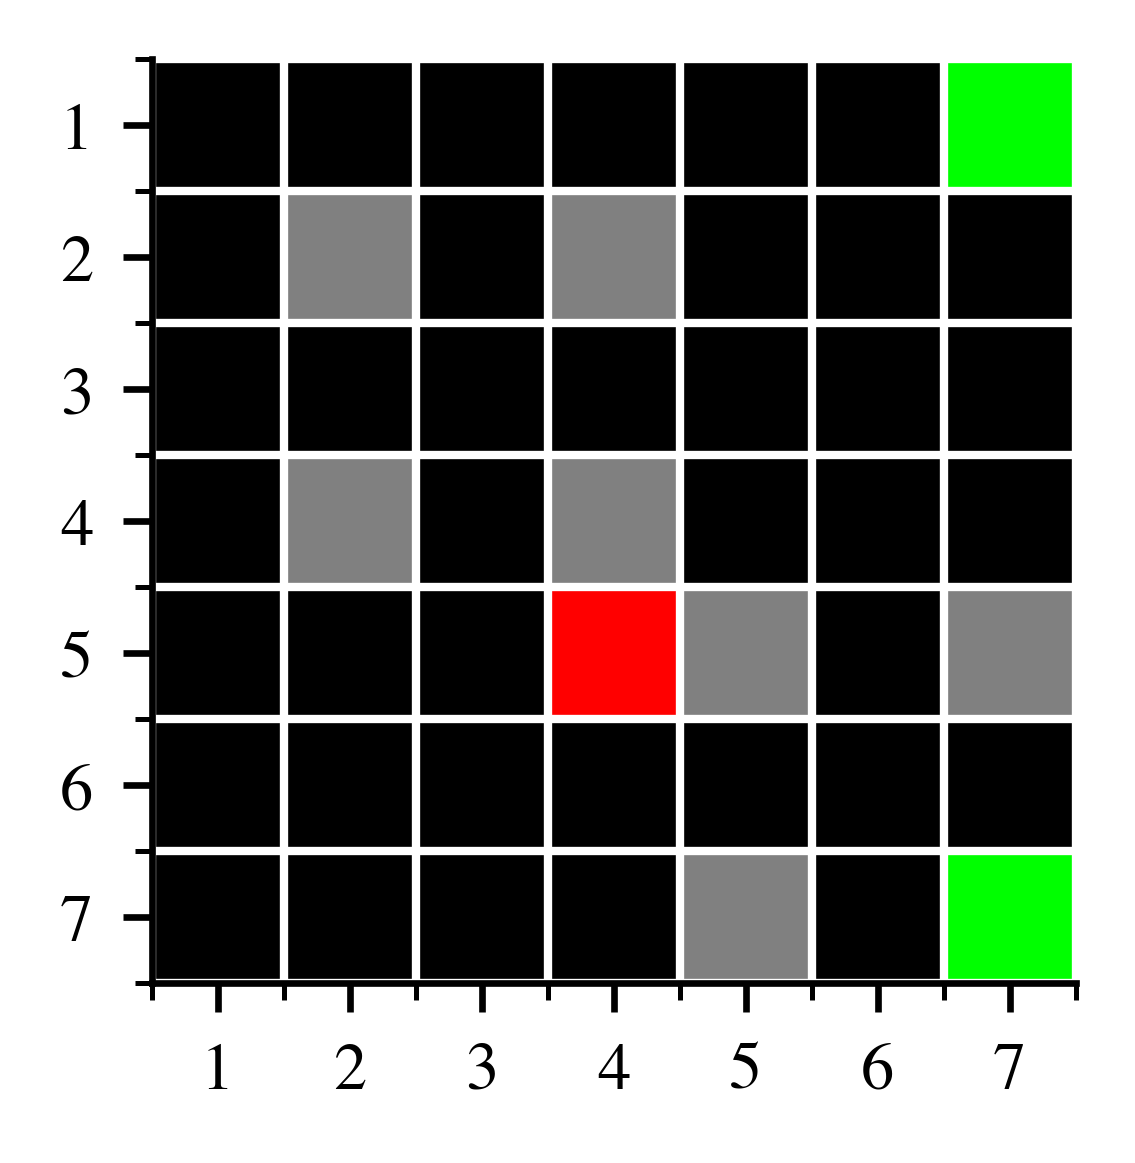

In [24]:
# # 7x7 Gridworld Environment

action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
reward_dict = {1:0, -1:1, -0.1:2, 0:3}

#####

# Environment Definition
env_width = 7
env_height = 7
env = Environment(dim=(env_width, env_height),
                  starts=[(2, 0), (6, 2), (2,4)],
                  terminals={(0, 6): +1, (6, 6): +1, (4, 3): -1},
                  obstacles=[[1, 1], [1, 3], [3, 1], [3, 3], [4,4], [6, 4], [4,6]],
                  stoc=0.)

env.render(title='7x7 Gridworld')

# Initialize the agent
agent = Agent(env)

#####

In [25]:
# # 5x5 Gridworld Environment
# action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
# reward_dict = {1:0, -1:1, -0.1:2, 0:3}

# #####

# # Environment Definition
# env_width = 5
# env_height = 5
# env = Environment(dim=(env_width, env_height),
#                   starts=[(4, 4), (4, 2)],
#                   terminals={(0, 1): +1, (4, 4): -1},
#                   obstacles=[[3,2],[3,3]],
#                   stoc=0.)

# env.render(title='Gridworld')

# # Initialize the agent
# agent = Agent(env)

# #####

### Collecting offline trajectory data

In [26]:
# # Generate offline data for the training
# num_episodes_dyna = 5
# num_agents_dyna = 10
# max_traj_len = 10
# num_pos_trajs = 250
# num_neg_trajs = 50
# offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

#####

In [27]:
# If you are planning to pickle these trajectories and use them instead of generating them every time...
num_episodes_dyna = 5
num_agents_dyna = 10
max_traj_len = 10
num_pos_trajs = 250
num_neg_trajs = 50

results_save_dir = './gridworld_results/grid_7by7/'
# with open(os.path.join(results_save_dir, 'offline_traj_transformers.pkl'), 'wb') as f:
#     pickle.dump(offline_data, f)

with open(os.path.join(results_save_dir, 'offline_traj_transformers.pkl'), 'rb') as f:
    offline_data = pickle.load(f)

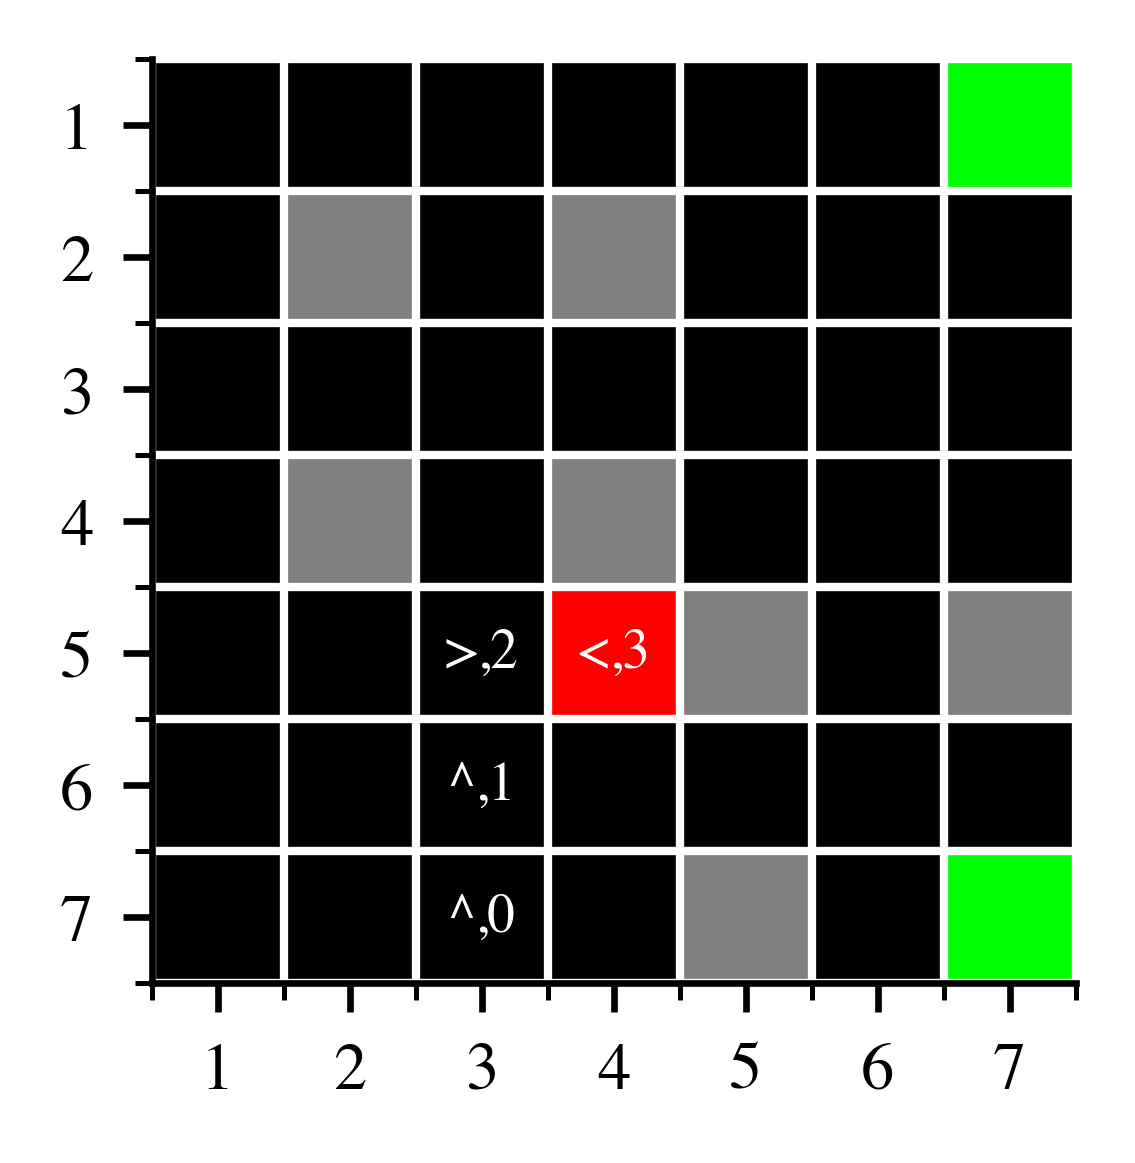

In [28]:
# Plot a trajectory to check if the data has been correctly formed
env.plot_traj(offline_data[-1])

In [29]:
def tokenizer(trajectories, state_space_dim, action_dict, reward_dict, max_traj_len = 25):
    """
        Tokenizer for capturing gridworld trajectories
    """

    action_space_dim = len(action_dict)
    reward_set_dim = len(reward_dict)
    
    # TOKEN IDs
    # 1 START TOKEN
    # 2 END TOKEN
    # 0 PAD TOKEN
    # STATE TOKENs
    # ACTION TOKENs
    # REWARD TOKENs
    
    complete_traj_tokens = []
    
    for traj in trajectories:
        # Traj contains (s,a,r,s')
        # We generate tokens for 's', 'a' and 'r'
        
        traj_tokens = []
        
        # Start token
        traj_tokens.append(1)
        
        for sars_ in traj:
            s = sars_[0]
            a = sars_[1]
            r = sars_[2]
            
            # State
            traj_tokens.append(3 + s)
            
            # Action
            traj_tokens.append(3 + state_space_dim + a)
            
            # Reward
            traj_tokens.append(3 + state_space_dim + action_space_dim + reward_dict[r])
        
        # Remove action and reward for terminal state, TO BE USED ONLY when (s_terminal, a_random, reward = 0, s_terminal) exists at the end of trajectory data
        traj_tokens.pop()
        traj_tokens.pop()
        
        # End token
        traj_tokens.append(2)
        
        # Pad with zero tokens
        if max_traj_len + 3 - len(traj) > 0:
            traj_tokens = traj_tokens + [0]*(3*(max_traj_len + 3 - len(traj)))
        
        complete_traj_tokens.append(torch.LongTensor(traj_tokens))
    
    return complete_traj_tokens

vocab_size = 3 + env_width*env_height + len(action_dict) + len(reward_dict)

tokenized_data = tokenizer(offline_data, 
                          state_space_dim = env_width*env_height, 
                          action_dict = action_dict, 
                          reward_dict = reward_dict, 
                          max_traj_len = max_traj_len)

Trying to include pre-trained transformers in our work 
- BERT 
- Trajectory Encoder

If you would like to use BERT keep the code as it is.

If you would like to use Trajectory Transformer comment the three cells below about BERT. And then uncomment the Trajectory Transformer Cell.

In [30]:
from transformers import AutoModel, AutoTokenizer

model_name = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_name, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [31]:
# tokenized_data_without_tensors = [tensor.tolist() for tensor in tokenized_data]
# tokenized_data_without_tensors
# # Convert list to dictionary with appropriate keys

# input_tokenized = {'input_ids': torch.stack(tokenized_data)} 
input_ids =  torch.stack(tokenized_data)
print(input_ids)

outputs = model(input_ids)
outputs

tensor([[ 1, 21, 54,  ...,  0,  0,  0],
        [ 1, 21, 53,  ...,  0,  0,  0],
        [ 1, 21, 54,  ...,  0,  0,  0],
        ...,
        [ 1, 47, 53,  ...,  0,  0,  0],
        [ 1, 47, 53,  ...,  0,  0,  0],
        [ 1, 47, 53,  ...,  0,  0,  0]])


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2904, -0.1074, -0.3806,  ..., -0.3527,  0.7705, -0.2546],
         [-0.2022, -0.0859, -0.3808,  ..., -0.4164,  0.7823, -0.2519],
         [-0.2103, -0.0894, -0.3614,  ..., -0.4385,  0.7570, -0.2631],
         ...,
         [-0.2619, -0.2185, -0.2453,  ..., -0.4212,  0.8205, -0.2723],
         [-0.2645, -0.2109, -0.2546,  ..., -0.4072,  0.8250, -0.2715],
         [-0.2712, -0.1873, -0.2682,  ..., -0.4012,  0.8173, -0.2903]],

        [[-0.2717, -0.1038, -0.3985,  ..., -0.3229,  0.7738, -0.2686],
         [-0.1731, -0.0841, -0.4023,  ..., -0.3931,  0.7703, -0.2697],
         [-0.2042, -0.0950, -0.3907,  ..., -0.3982,  0.7444, -0.2753],
         ...,
         [-0.2436, -0.2087, -0.2608,  ..., -0.3932,  0.8228, -0.2804],
         [-0.2469, -0.2011, -0.2696,  ..., -0.3782,  0.8279, -0.2801],
         [-0.2539, -0.1779, -0.2830,  ..., -0.3716,  0.8206, -0.3002]],

        [[-0.2904, -0.1074, -0.3806,  ..., -0.3527,  

In [32]:

traj_outs = outputs.last_hidden_state.mean(dim=1)
# traj_embeddings = outputs
# print(traj_outs.shape)
traj_embeddings = traj_outs.detach().numpy()

traj_embeddings.shape




(300, 768)

**Trajectory Transformer Cell**

In [ ]:
## TRAJECTORY TRANSFORMER CELL
# from transformers import TrajectoryTransformerModel
# import torch
# from torch.nn.utils.rnn import pad_sequence

# model = TrajectoryTransformerModel.from_pretrained(
#     "CarlCochet/trajectory-transformer-halfcheetah-medium-v2"
# )

# # model.to(device)
# model.eval()
# # print(torch.to_tensor(tokenized_data))
# # print(offline_data)

# # result = [[t[:-1] for t in inner_tuple] for inner_tuple in offline_data[0]]

# result = []
# for i in offline_data:
#     list_new = []
#     for t in i:
#         temp = list(t)
#         list_new.append(temp[:-1])
#     result.append(list_new)

# # print(result)
# # print(len(result))


# # Assuming my_list_of_lists is inconsistent
# # Pad shorter sublists with zeros to make them consistent
# inp = pad_sequence([torch.tensor(sublist) for sublist in result], batch_first=True)



# inp = inp.to(dtype=torch.long)

# inp = inp.view(num_pos_trajs + num_neg_trajs, inp.shape[1]*inp.shape[2])

# outputs = model(
#     trajectories = inp,
#     use_cache=True,
#     output_attentions=True,
#     output_hidden_states=True,
#     return_dict=True,
# )


# logits = outputs.logits.view(num_pos_trajs + num_neg_trajs, outputs.logits.shape[1]*outputs.logits.shape[2])
# traj_embeddings = logits.detach().numpy()
# traj_embeddings.shape

In [13]:
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_5.pth')
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_fourrooms.pth')
# torch.save(model.state_dict(), './ckpt_save_dir/transf_seq2seq.pth')

### PCA analysis of the trajectory embeddings

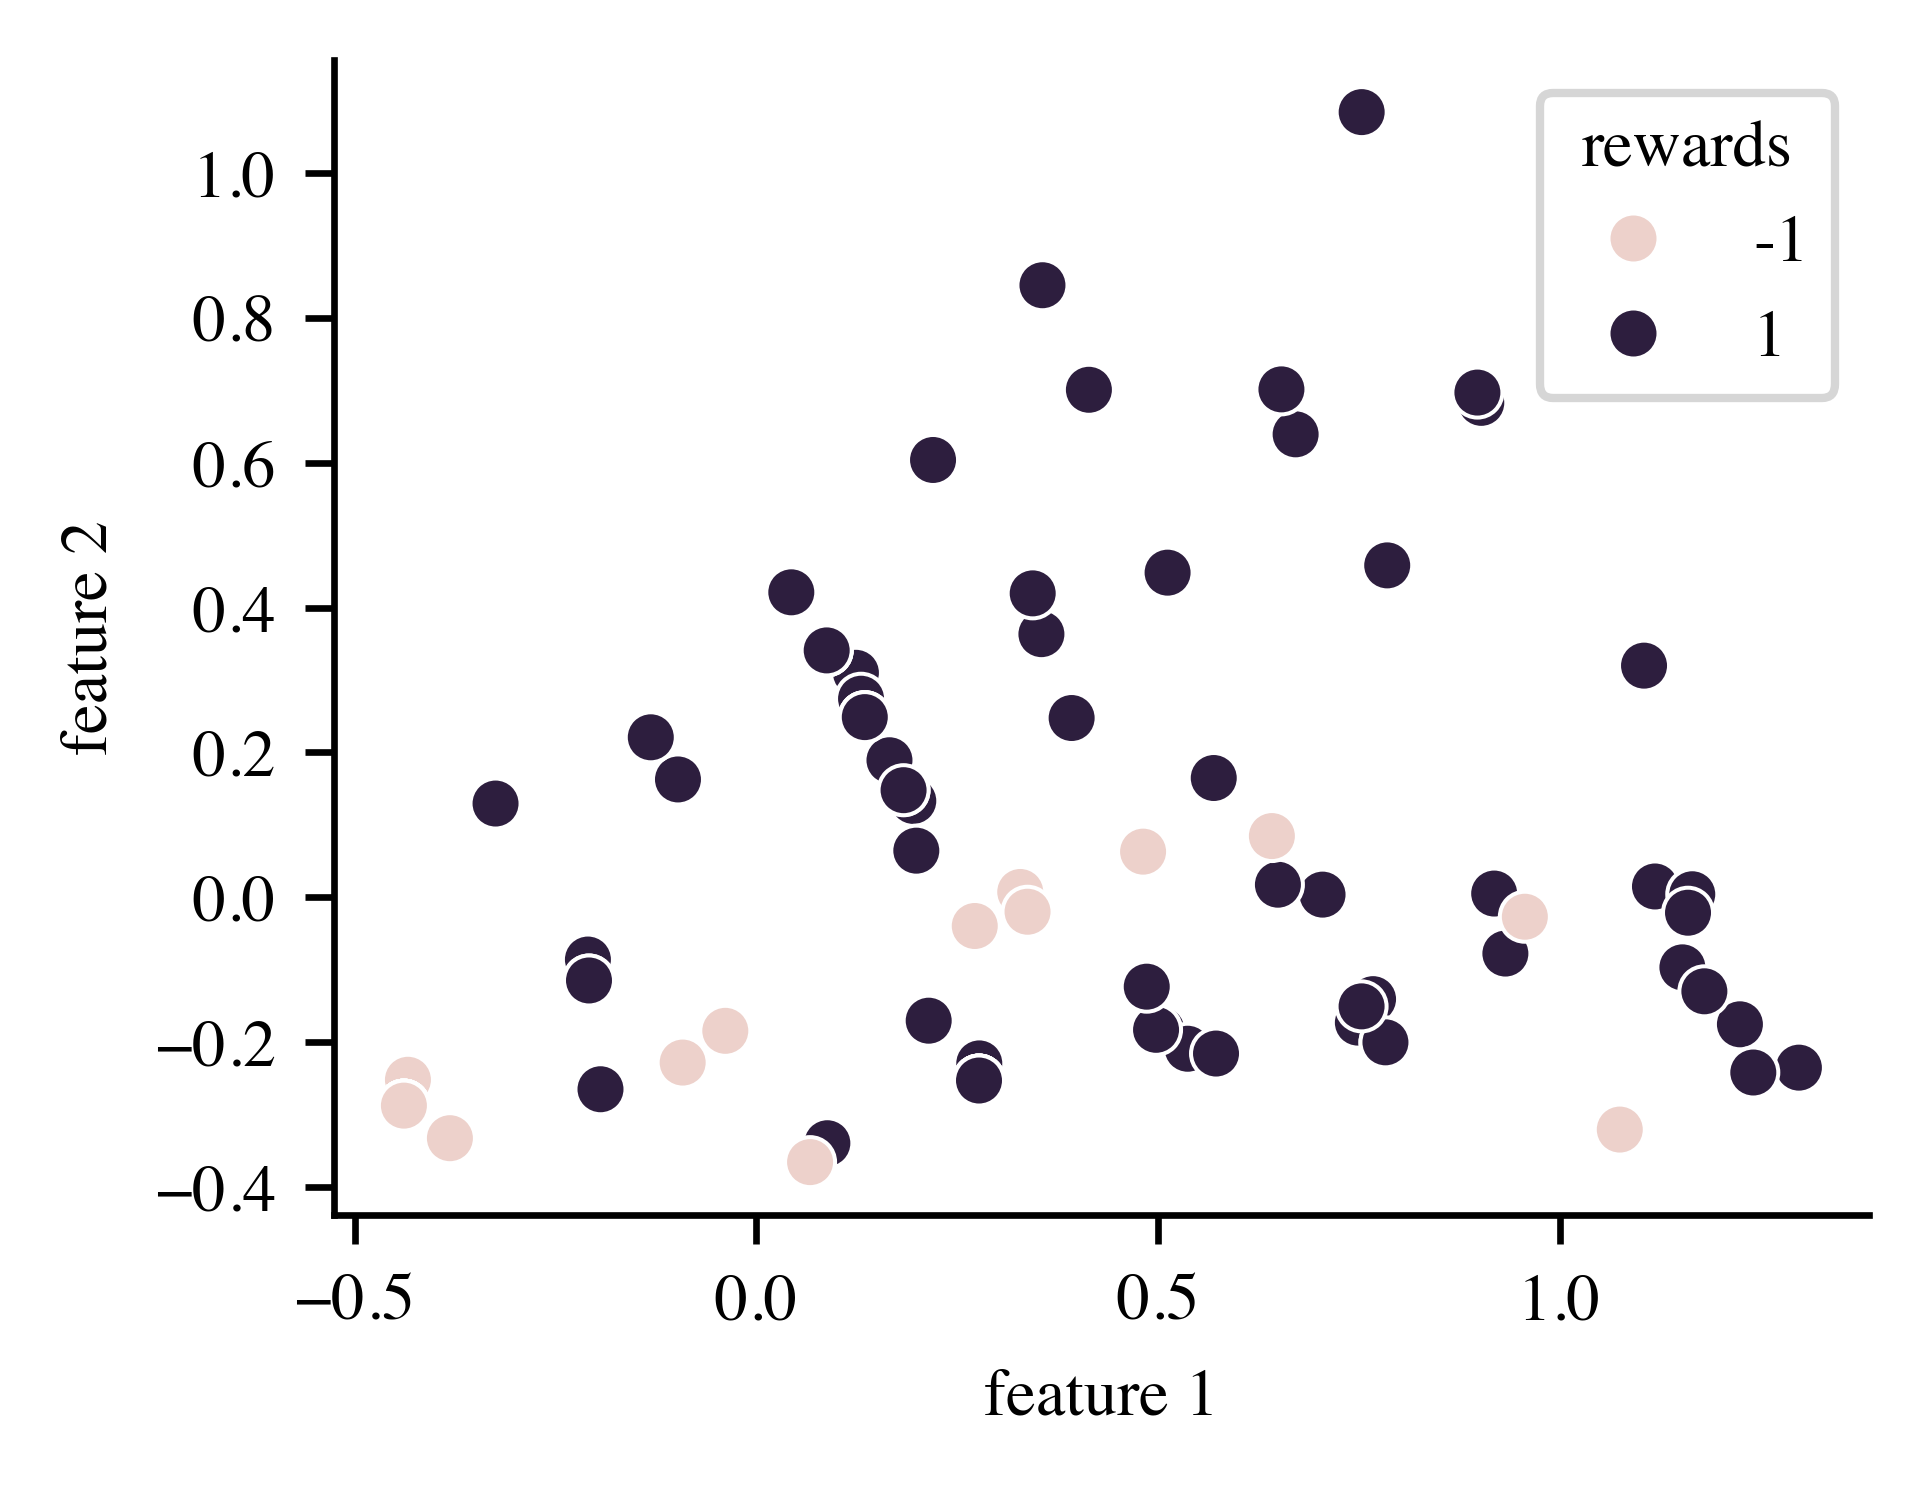

In [33]:
pca = PCA(n_components=2)
pca_traj_embeddings = pca.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeddings[:, 0], 'feature 2': pca_traj_embeddings[:, 1],
                 'rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs}
df = pd.DataFrame(plotting_data)

plt.figure()
sns.scatterplot(x='feature 1', y='feature 2', hue='rewards', data=df)
# plt.title('PCA: Trajectory Embeddings')
# plt.legend()
plt.show()

# plt.figure()
# data_ax = sns.scatterplot(x='x',
#                           y='y',
#                           hue='labels',
#                           palette='deep',
#                           data=df,
#                           legend=True)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
# plt.title('PCA: Cluster Embeddings using ' + embed_gen_config['method_name'])
# plt.show()

### Clustering of the trajectories using X-Means

**(ii) Trajectory Clustering**

The following cell is just extracting clustering using `xmeans` from `pyclustering.cluster.xmeans`

In [34]:
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(traj_embeddings, amount_initial_centers).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
## mre then 10 clusters is pointless because by plotting them we see visually there are no more then 9.
xmeans_instance = xmeans(traj_embeddings, initial_centers, 10)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())
print("Clusters:", clusters)
print('Number of clusters', len(clusters))

Total WCE: 8.634375821768398
Clusters: [[141, 142, 144, 146, 148, 153, 158, 163, 166, 169, 173, 182, 185, 192, 194, 196, 199, 208, 211, 212, 213], [218, 233, 252, 254, 255, 256, 257], [134, 135, 136, 137, 138, 139, 140, 143, 145, 147, 149, 151, 152, 154, 155, 156, 157, 159, 160, 161, 162, 164, 165, 167, 168, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 186, 187, 188, 189, 190, 191, 193, 195, 197, 198, 200], [202, 203, 204, 205, 206, 207, 209, 210, 215, 216, 217, 219, 221, 222, 223, 224, 228], [1, 25, 28, 33, 41, 43, 51, 60, 115, 126, 131, 258, 259, 260], [229, 232, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 250, 251, 253], [201, 214, 220, 225, 226, 227, 230, 231, 236, 247, 248, 249], [261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299], [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2

In [35]:
# for cluster_id, cluster in enumerate(clusters):
#     print('-'*10)
#     print('Cluster ID', cluster_id)
#     for traj_id in cluster:
#         env.plot_traj(offline_data[traj_id])    
#     print('-'*10)

Initializing cluster labels and assigning to every cluster a color

In [36]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id

traj_cluster_labels

array([8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 4, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 4, 8, 4,
       8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 9, 9, 4,
       9, 9, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 9, 2, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2,
       2, 0, 2, 6, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 6, 3, 3, 3, 1, 3,
       6, 3, 3, 3, 3, 6, 6, 6, 3, 5, 6, 6, 5, 1, 5, 5, 6, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 1, 5, 1, 1, 1, 1, 4, 4, 4, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [37]:
palette = sns.color_palette('husl', len(clusters) + 1)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8836443049112893, 0.5240073524369634, 0.19569304285113343),
 (0.710130687316902, 0.6046852192663268, 0.19426060163712158),
 (0.5432776721247529, 0.6540981095185215, 0.19324494273892204),
 (0.19592059105779686, 0.6981620017487838, 0.3452219818913641),
 (0.2067117296964458, 0.6829103404254792, 0.5829988925822328),
 (0.21420912437215422, 0.6714963557258681, 0.6986206664203177),
 (0.22537170008202412, 0.6531400148480775, 0.841007805313343),
 (0.5596943802099308, 0.5764402169887779, 0.9583930713150347),
 (0.8578978803740231, 0.44058452715322166, 0.957819659566579),
 (0.9628653850704806, 0.4025928454059796, 0.7779310354076443)]

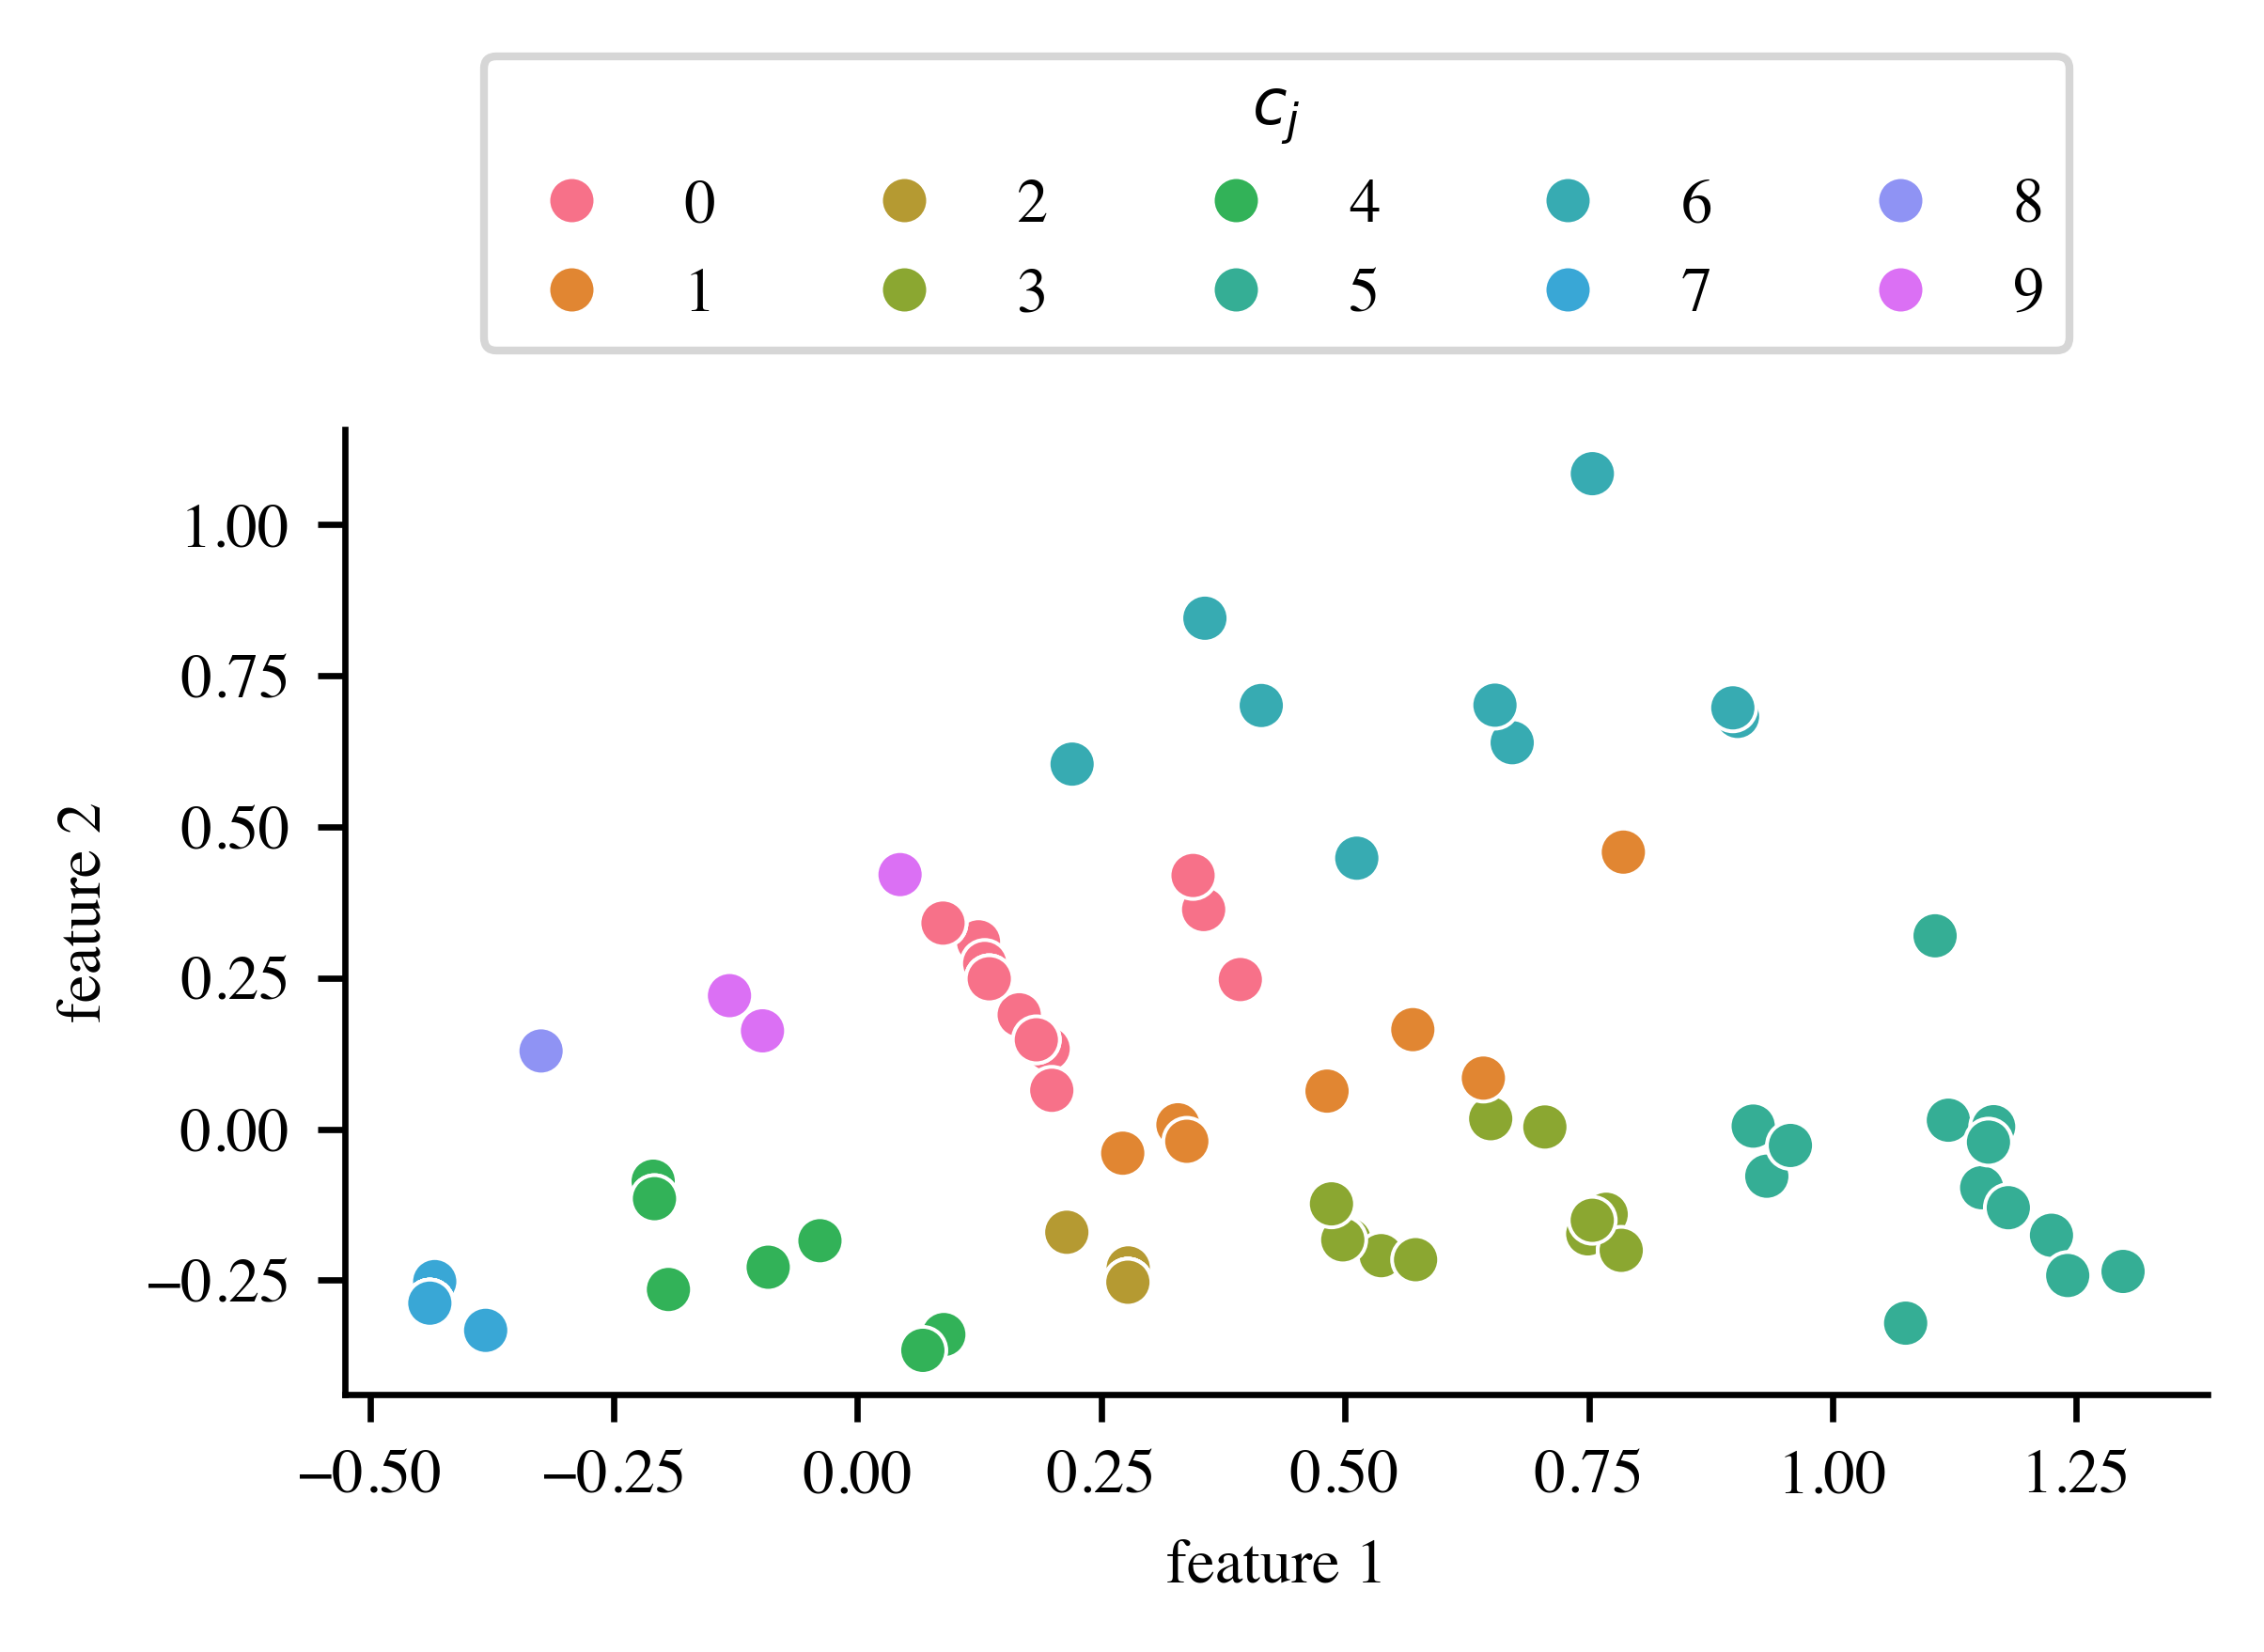

In [38]:
# cluster_data_embeds = [result_data_combinations[cid][1] for cid in result_data_combinations]
# cluster_data_embeds.pop(0)

pca_traj = PCA(n_components=2)
pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeds[:, 0],
                 'feature 2': pca_traj_embeds[:, 1],
                 'cluster id': traj_cluster_labels}
df = pd.DataFrame(plotting_data)

plt.figure(figsize=(4,3))
data_ax = sns.scatterplot(x='feature 1',
                          y='feature 2',
                          hue='cluster id',
                          palette=palette[:len(clusters)],
                          data=df,
                          legend=True)
plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
# plt.legend(title = '$c_{j}$', loc='center left', bbox_to_anchor=(1., 0.7), ncol=2)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
plt.tight_layout()
plt.savefig('./traj_clustering_grid.pdf')
plt.show()

## Encode sets of trajectories (iii)

**(iii) Data Embedding**

Next we encode cells following the procedure explained in Algorithm 3 in paper. 

- Give the embedding trajectories as input
- Sum and Normalize these embedding trajectories
- Finally apply softmax.
- This is the final data embedding. A final step is done to construct the so-called complementary data embedding sets.
    - A of complementary data embedding sets are created by leaving out each time those embeddings belonging to the same class a part from the first which is comprised of all trajectories
    This way these resulting complementary sets have all the trajectories from the original data except those belonging to one cluster, which every time changes creating the number of cluster + 1 

In [39]:
# def get_data_embedding(traj_embeddings):
# #     return np.exp(np.abs(np.array(traj_embeddings).sum(axis=0)/100.))/np.sum(np.abs(np.exp(np.array(traj_embeddings).sum(axis=0)/100.)))
#     return np.exp(np.array(traj_embeddings).sum(axis=0)/len(clusters))/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/len(clusters)))


# data_embedding = get_data_embedding(traj_embeddings)
# data_embedding

# def get_data_embedding(traj_embeddings):
#     return np.array(traj_embeddings).sum(axis=0)/len(clusters)

def get_data_embedding(traj_embeddings):
    max_val = np.max(traj_embeddings)
    exp_values = np.exp(np.array(traj_embeddings) - max_val)
    return exp_values.sum(axis=0) / len(clusters) / np.sum(exp_values)


data_embedding = get_data_embedding(traj_embeddings)
data_embedding

array([8.53424717e-05, 9.56943186e-05, 8.14579544e-05, 1.65270481e-04,
       7.32605331e-05, 6.30538416e-05, 1.20330573e-04, 1.60801617e-04,
       1.14990762e-04, 3.91976573e-05, 5.43722817e-05, 6.63782776e-05,
       6.13013108e-05, 2.78881780e-04, 1.74904708e-04, 2.35213403e-04,
       1.76583373e-04, 3.21856787e-04, 4.63370816e-05, 1.74477667e-04,
       3.65738379e-04, 1.47790328e-04, 1.51317479e-04, 6.11020019e-04,
       1.44106438e-04, 8.25212337e-05, 2.96515384e-04, 4.09436652e-05,
       1.23839534e-04, 6.50896691e-05, 1.19479933e-04, 1.29066757e-04,
       8.65527836e-05, 8.82186141e-05, 6.73824397e-05, 5.41162699e-05,
       1.27466570e-04, 1.00926656e-04, 8.73998142e-05, 1.49293497e-04,
       3.41387167e-05, 2.95689497e-05, 3.15360056e-04, 1.60195748e-04,
       7.92546125e-05, 2.12781106e-05, 5.74802943e-05, 1.28466767e-04,
       1.00397956e-04, 6.74673647e-05, 6.08845439e-05, 9.93756184e-05,
       1.34426620e-04, 1.36089366e-04, 2.41686881e-04, 3.98348609e-04,
      

## Train models on different cluster combinations (iv)

**(iv) Training Explanation Policies**

Notice how we did not yet create the complementary datasets we talked about in previous section. 

That is because we are going to probably do it now, in the `forloop` down below. 

In the `generate_model` function and `dp` function we are doing what?
In the following cell nothing, it is actually useless, but in general the two functions have the following objectives:
- `generate_model` is generating a transition model and a reward model based on the new trajectories.
- `dp` is instead creating the new explanation policy and returning also values and action_values.


In [40]:
transition_model, reward_model = generate_model(env, offline_data)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

Inside the following loop, for every cluster, we are basically creating the complementary data embeddings and generating new transition model and reward models (through `generate_model`) used to create (through `dp`) the `explanation policy` for that specific complementary data embedding set and storing also the `action_values` (which are representative of the actions taken by the agent under this newly trained RL model with for each complementary data embedding set). These `action_values` are going to be used in step (v) Cluster attribution.


In [41]:
result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data):
        if traj_id not in cluster:
            temp_data.append(offline_data[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

## Generate attributions (v)

**(v) Cluster Attribution**

Final step of algorithm:
For every state of the agent we compute distance between original action values (of the initial RL agent) and the new `action_values` computed before. 
We do this for every element of `result_data_combinations` dictionary, which is comprised of all the complementary data embedding sets for each cluster and the new sets of actions from the new trained agent for each cluster. 
It is a dict of key and a tuple made of (action_values_new, data_embedding_new) as value. 

<!-- That is why `result_data_combinations[data_combination_id][0].shape` = 64  `result_data_combinations[data_combination_id][1].shape` = (49 (7x7), 4) -->

If the two sets of actions are different we compare them through the `wasserstein_distance` and store this value.

We then save the cluster with smallest distance into `responsible_data_combination` by argsorting on the distances and selecting the zero-th element. 

If in that specific state the value corresponding to the smallest distance is either 1e9 or 0 then it means that either that complementary set caused the same state_actions as in the original data (1e9) or I AM NOT SURE WHY THE ZERO (must be some numerical error?). 
The point is if these are the smallest distance values then using different dataset has not caused any change in the behaviour of the agent. Meaning that state action has not been influenced by using a complementary data embedding set instead of original data. Thus we can go on looking for other states in order to find smallest data distance. 

The printed results show only those states which are indeed affected by the change in data. 

The numbers shown into `Responsible trajectory id` represent the trajectories belonging to the cluster which has influenced the most the trajectory in that state, which corresponds with the one with less distance. 

There are some prints in the following cell to help you understand. ##



In [42]:
attributions = []

for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals:
        continue
        
    orig_state_action_values = action_values[state]
    
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        # print("data_comb_id", data_combination_id)
        # print(action_values_new[data_combination_id])
        # print("state", state)
        # print(action_values_new[state])

        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]
        # print(new_state_action_values)

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)

    ## argsorting on the distances and selecting the zero-th element. This corresponds to the smallest distance cluster for that state for every complementary data embedding set.
    responsible_data_combination = np.argsort(distances)[0]
    # print(distances)


    ## if you want print these two, so that you can see the distances and the smallest distance cluster. 
    # print(distances, distances[responsible_data_combination], responsible_data_combination)
    ## if you print this, you understand how trajectories are grouped and why `Responsible trajectory id` is showing what it is showing.
    # print(clusters)


    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)

----------
State - (6, 2)
Distance - 1.8354884427177857e-08
Original Actions -['RIGHT']
New Action - ['UP']
Responsible data combination - data id 10
Responsible trajectory id [129, 130, 132, 133, 150]
----------
----------
State - (4, 3)
Distance - 1.2564616014287814e-07
Original Actions -['LEFT']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 4
Responsible trajectory id [202, 203, 204, 205, 206, 207, 209, 210, 215, 216, 217, 219, 221, 222, 223, 224, 228]
----------
----------
State - (5, 3)
Distance - 1.8354884427177857e-08
Original Actions -['RIGHT']
New Action - ['UP']
Responsible data combination - data id 10
Responsible trajectory id [129, 130, 132, 133, 150]
----------
----------
State - (6, 3)
Distance - 1.8354884427177857e-08
Original Actions -['RIGHT']
New Action - ['UP']
Responsible data combination - data id 10
Responsible trajectory id [129, 130, 132, 133, 150]
----------
----------
State - (1, 4)
Distance - 2.0431252778507753e-07
Origi

In [43]:
attributions

[{'state': (6, 2),
  'orig_act': ['RIGHT'],
  'new_act': ['UP'],
  'attributed_trajs': [129, 130, 132, 133, 150],
  'random_baseline_trajs': [86, 242, 225, 176, 181],
  'alternate_cluster_trajs': [1,
   25,
   28,
   33,
   41,
   43,
   51,
   60,
   115,
   126,
   131,
   258,
   259,
   260],
  'responsible_cluster': 9},
 {'state': (4, 3),
  'orig_act': ['LEFT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [202,
   203,
   204,
   205,
   206,
   207,
   209,
   210,
   215,
   216,
   217,
   219,
   221,
   222,
   223,
   224,
   228],
  'random_baseline_trajs': [56, 92, 285, 130, 30],
  'alternate_cluster_trajs': [229,
   232,
   234,
   235,
   237,
   238,
   239,
   240,
   241,
   242,
   243,
   244,
   245,
   246,
   250,
   251,
   253],
  'responsible_cluster': 3},
 {'state': (5, 3),
  'orig_act': ['RIGHT'],
  'new_act': ['UP'],
  'attributed_trajs': [129, 130, 132, 133, 150],
  'random_baseline_trajs': [58, 241, 85, 80, 87],
  'alternate_cluste

In [44]:
results_save_dir = './gridworld_results/grid_7by7_transformers_encoding/'
if not os.path.exists(results_save_dir):
    os.makedirs(results_save_dir)


# for traj_id, traj in enumerate(offline_data):
#     env.plot_traj(traj, path=os.path.join(results_save_dir, 'traj_' + str(traj_id) + '.png'))


In [45]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [46]:
# Data to save
data_to_be_saved = [
    {
        'attributions' : attributions,
    }
]

dumped = json.dumps(data_to_be_saved, cls=NumpyEncoder)

with open(os.path.join(results_save_dir, 'attribution_results.json'), 'w') as f:
    json.dump(dumped, f)

In [47]:
attributions

[{'state': (6, 2),
  'orig_act': ['RIGHT'],
  'new_act': ['UP'],
  'attributed_trajs': [129, 130, 132, 133, 150],
  'random_baseline_trajs': [86, 242, 225, 176, 181],
  'alternate_cluster_trajs': [1,
   25,
   28,
   33,
   41,
   43,
   51,
   60,
   115,
   126,
   131,
   258,
   259,
   260],
  'responsible_cluster': 9},
 {'state': (4, 3),
  'orig_act': ['LEFT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [202,
   203,
   204,
   205,
   206,
   207,
   209,
   210,
   215,
   216,
   217,
   219,
   221,
   222,
   223,
   224,
   228],
  'random_baseline_trajs': [56, 92, 285, 130, 30],
  'alternate_cluster_trajs': [229,
   232,
   234,
   235,
   237,
   238,
   239,
   240,
   241,
   242,
   243,
   244,
   245,
   246,
   250,
   251,
   253],
  'responsible_cluster': 3},
 {'state': (5, 3),
  'orig_act': ['RIGHT'],
  'new_act': ['UP'],
  'attributed_trajs': [129, 130, 132, 133, 150],
  'random_baseline_trajs': [58, 241, 85, 80, 87],
  'alternate_cluste

## Experiments

### Analyzing High-Level Cluster Behaviours


Cluster Behaviours

How to read `offline_data[clusters[i][j]`. 

For example 
`offline_data[clusters[i][j] = [(18, 1, -0.1, 11), (11, 1, -0.1, 4), (4, 2, -0.1, 5), (5, 2, 1.0, 6), (6, 1, 0, 6)]`

In [33]:
# env.plot_traj(offline_data[clusters[4][0]])

The first element is ((18, 1, -0.1, 11)). 
- 18 being the position of the starting point starting to count from position 1,1 which will be position 0. 
- 1 is the number corresponding to the ation taken in that position, being UP
- -0.1 is the reward corresponding to making an extra step without hitting a stopping point, in this case going to position 11.
- 11 is the destination position. 
That is why for the last but one element (5, 2, 1.0, 6)
- 5 is the position
- 2 is the encoding for RIGHT
- 1.0 is the reward corresponding to the fact we hit a terminal node in the next state
- 6 is the position of the next state
The last element state corresponds to (6, 1, 0, 6) where 
- 0 corresponds to the reward in being in an already terminal state.

In [34]:
clusters[8]


[220, 226, 227, 230, 231, 236, 247, 248, 249]

In [35]:
# used = [0]
# for i in used:
#     for j in range(len(clusters[i])):
#         env.plot_traj(offline_data[clusters[i][j]])

In [36]:
## finishing in top right corner 
## means having a positive reward in the last but one state 
## and going towards position 6
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

final_clusters = []
for proposed_cluster in range(len(clusters)):
    finished_in_top_right = 0

    for i in range(len(clusters[proposed_cluster])):
        if list(offline_data[clusters[proposed_cluster][i]])[-2][-2:] == (1.0, 6):
            finished_in_top_right+=1
            
    print("Cluster_id:", proposed_cluster)
    print("Percentage of trajectories finishing in top right {}%".format(finished_in_top_right/len(clusters[proposed_cluster]) * 100))
        
    if finished_in_top_right/len(clusters[proposed_cluster]) * 100 > 80 \
        and len(clusters[proposed_cluster]) > 2: 

        print(f"Success, cluster {proposed_cluster} is the cluster which has the high-level behaviour of finishing in top right")
        final_clusters.append(proposed_cluster)

print("Final clusters finishing in top right are {}".format(final_clusters))

Cluster_id: 0
Percentage of trajectories finishing in top right 0.0%
Cluster_id: 1
Percentage of trajectories finishing in top right 77.77777777777779%
Cluster_id: 2
Percentage of trajectories finishing in top right 100.0%
Success, cluster 2 is the cluster which has the high-level behaviour of finishing in top right
Cluster_id: 3
Percentage of trajectories finishing in top right 100.0%
Success, cluster 3 is the cluster which has the high-level behaviour of finishing in top right
Cluster_id: 4
Percentage of trajectories finishing in top right 0.0%
Cluster_id: 5
Percentage of trajectories finishing in top right 50.0%
Cluster_id: 6
Percentage of trajectories finishing in top right 28.57142857142857%
Cluster_id: 7
Percentage of trajectories finishing in top right 100.0%
Success, cluster 7 is the cluster which has the high-level behaviour of finishing in top right
Cluster_id: 8
Percentage of trajectories finishing in top right 100.0%
Success, cluster 8 is the cluster which has the high-leve

In [37]:
## finishing in lava 
## means having a -1 reward in last but one state
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

final_clusters = []
for proposed_cluster in range(len(clusters)):
    finished_in_lava = 0

    for i in range(len(clusters[proposed_cluster])):
        
        if list(offline_data[clusters[proposed_cluster][i]])[-2][-2] == (-1.0):
            finished_in_lava+=1
    print("Cluster_id:", proposed_cluster)
    print("Percentage of trajectories finishing in lava {}%".format(finished_in_lava/len(clusters[proposed_cluster]) * 100))
    if finished_in_lava/len(clusters[proposed_cluster]) * 100 > 80 \
        and len(clusters[proposed_cluster]) > 2:
        print(f"Success, cluster {proposed_cluster} is the cluster which has the high-level behaviour of finishing in lava")
        final_clusters.append(proposed_cluster)

print("Final clusters finishing in lava are {}".format(final_clusters))

Cluster_id: 0
Percentage of trajectories finishing in lava 100.0%
Success, cluster 0 is the cluster which has the high-level behaviour of finishing in lava
Cluster_id: 1
Percentage of trajectories finishing in lava 22.22222222222222%
Cluster_id: 2
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 3
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 4
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 5
Percentage of trajectories finishing in lava 50.0%
Cluster_id: 6
Percentage of trajectories finishing in lava 71.42857142857143%
Cluster_id: 7
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 8
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 9
Percentage of trajectories finishing in lava 11.538461538461538%
Final clusters finishing in lava are [0]


In [38]:
## starting from mid-grid and finishing with goal
## means having a positive reward in the last but one state
## and having a starting point which is mid-grid
## How do we define mid-grid? Any starting point between position
## 7 and 35 in height and 
## thus:
# Set the seeds


final_clusters = []
for proposed_cluster in range(len(clusters)):
    started_mid_grid_finished_goal = 0

    for i in range(len(clusters[proposed_cluster])):
        if list(offline_data[clusters[proposed_cluster][i]])[0][0] in range(7, 40)  \
            and list(offline_data[clusters[proposed_cluster][i]])[-2][-2] == (1.0):
            started_mid_grid_finished_goal+=1 

    print("Cluster_id:", proposed_cluster)
    print("Percentage of trajectories starting in mid-grid and finishing in goal {}%".format(started_mid_grid_finished_goal/len(clusters[proposed_cluster]) * 100))
    if started_mid_grid_finished_goal/len(clusters[proposed_cluster]) * 100 > 80 \
        and len(clusters[proposed_cluster]) > 2: 
        print(f"Success, cluster {proposed_cluster} is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal")
        final_clusters.append(proposed_cluster)

print("Final clusters starting in mid-grid and finishing in goal are {}".format(final_clusters))

Cluster_id: 0
Percentage of trajectories starting in mid-grid and finishing in goal 0.0%
Cluster_id: 1
Percentage of trajectories starting in mid-grid and finishing in goal 77.77777777777779%
Cluster_id: 2
Percentage of trajectories starting in mid-grid and finishing in goal 100.0%
Success, cluster 2 is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal
Cluster_id: 3
Percentage of trajectories starting in mid-grid and finishing in goal 100.0%
Success, cluster 3 is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal
Cluster_id: 4
Percentage of trajectories starting in mid-grid and finishing in goal 0.0%
Cluster_id: 5
Percentage of trajectories starting in mid-grid and finishing in goal 50.0%
Cluster_id: 6
Percentage of trajectories starting in mid-grid and finishing in goal 28.57142857142857%
Cluster_id: 7
Percentage of trajectories starting in mid-grid and finishing in goal 100.0%
Success, cluster 7 is t

In [39]:
counter = 0
for i in range(len(clusters)):
    for j in range(len(clusters[i])):
        # env.plot_traj(offline_data[clusters[0][j]])
        len_0 = len(offline_data[clusters[i][0]])
        if len(offline_data[clusters[i][j]]) != len_0:
            print("Cluster {} trajectory {} is not of lenght {}".format(i, j, len_0))
            counter += 1
    print("Cluster {} has all trajectories of length = {}".format(i, len_0))
if counter == 0:
    print("All trajectories belonging to the same clusters are of the same length")

Cluster 0 has all trajectories of length = 4
Cluster 1 trajectory 7 is not of lenght 5
Cluster 1 trajectory 8 is not of lenght 5
Cluster 1 has all trajectories of length = 5
Cluster 2 trajectory 119 is not of lenght 5
Cluster 2 trajectory 120 is not of lenght 5
Cluster 2 trajectory 121 is not of lenght 5
Cluster 2 trajectory 122 is not of lenght 5
Cluster 2 has all trajectories of length = 5
Cluster 3 has all trajectories of length = 5
Cluster 4 trajectory 49 is not of lenght 7
Cluster 4 trajectory 50 is not of lenght 7
Cluster 4 trajectory 51 is not of lenght 7
Cluster 4 trajectory 52 is not of lenght 7
Cluster 4 trajectory 53 is not of lenght 7
Cluster 4 trajectory 54 is not of lenght 7
Cluster 4 trajectory 55 is not of lenght 7
Cluster 4 trajectory 56 is not of lenght 7
Cluster 4 has all trajectories of length = 7
Cluster 5 has all trajectories of length = 6
Cluster 6 trajectory 1 is not of lenght 9
Cluster 6 trajectory 2 is not of lenght 9
Cluster 6 trajectory 4 is not of lenght 9


## Metrics Section

The following section is about metrics used to compare different policies. 
1. Initial State Value Estimate 
    - Measure of expecteed long-term returns.
2. Local Mean Absolute Action-Value difference (Average delta q)
3. Action Contrast Measure



### Initial State Value Estimates

`result_data_combinations` is notghing but the dict comprising of all the complementary data embedding sets for each cluster and the new sets of actions from the new trained agent. 
It is a dict of key and a tuple made of (action_values_new, data_embedding_new) as value. 

In [40]:
ivs_xmean = []
for data_combination_id in result_data_combinations:
    ## uncomment the following lines to get a better view if necesary
    # print(data_combination_id)
    # print(result_data_combinations[data_combination_id][0])
    # print('max')
    # print(result_data_combinations[data_combination_id][0].max(axis=1))
    print('data_combination_id', data_combination_id)
    print(round(result_data_combinations[data_combination_id][0].max(axis=1).mean(), 4))
    
    ivs_xmean.append(result_data_combinations[data_combination_id][0].max(axis=1).mean())

sum(ivs_xmean)/len(ivs_xmean)

data_combination_id 0
0.348
data_combination_id 1
0.3495
data_combination_id 2
0.3492
data_combination_id 3
0.3485
data_combination_id 4
0.3485
data_combination_id 5
0.3279
data_combination_id 6
0.3496
data_combination_id 7
0.3492
data_combination_id 8
0.344
data_combination_id 9
0.3492
data_combination_id 10
0.3063


0.34273050777730424

In [38]:
ivs_xmean_normal_encoder = [0.3061, 0.3055, 0.3053,
                             0.3049, 0.2857, 0.2987,
                               0.3057, 0.3046, 0.3055, 
                               0.3057, 0.3046]

In [39]:
round(sum(ivs_xmean)/len(ivs_xmean),4), round(sum(ivs_xmean_normal_encoder)/len(ivs_xmean_normal_encoder),4)

(0.3385, 0.3029)

### Average delta q

As the average delta is a technique measuring how the original policy percieves suggestions given by explanation policies you are keeping `result_data_combinations[0][0]` because corresponding to `data_combination_id` == 0 is the original dataset and thus ` result_data_combinations[0][0]` corresponds to the original set of actions. 

In [40]:
deltaq_xmean = []
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
    ## Expected value of the difference
    print(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))
    deltaq_xmean.append(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))
sum(deltaq_xmean)/len(deltaq_xmean)

0.0
0.02106074009466362
0.017711812923764458
0.11097565682275727
0.002504629810194653
0.0022597114813665054
0.003944996095157217
0.0031143840281157385
0.14385856006383319
0.009279574671832581
0.13343121091997112


0.04074011608287786

### Compare the actions

In [41]:
action_comparison = {}
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    action_comparison[data_combination_id] = 0
    for i in range(env_width*env_height):
            orig_actions = np.where(result_data_combinations[0][0][i] == np.max(result_data_combinations[0][0][i]))[0]
            alternate_actions = np.where(result_data_combinations[data_combination_id][0][i] == np.max(result_data_combinations[data_combination_id][0][i]))[0]
            
            if list(orig_actions) == list(alternate_actions):
                action_comparison[data_combination_id] += 1 
#             alternate_actions = 
#     print(np.sum(np.argmax(action_values_new, axis=1) != np.argmax(result_data_combinations[0][0], axis=1))/(env_width*env_height))

In [42]:
action_comparison_xmean = np.array(list(action_comparison.values()))/(env_width*env_height)
sum(list(action_comparison_xmean))/len(list(action_comparison_xmean))

0.8645640074211502

On top of this they compare distances between embeddings of original and complementary datasets using Wasserstein metric and cluster attribution frequency

### Data distances

In [43]:
data_distances = np.zeros(len(result_data_combinations))
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding, data_embedding_new)

In [44]:
datadistances_xmean = []
with np.printoptions(precision=5, suppress=True):
    # print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))
    datadistances_xmean.append((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))

datadistances_xmean[0].mean()

0.11412316699547675

### Cluster Attribution Frequency

In [45]:
cluster_attr_freq = np.zeros(len(clusters))

In [46]:
for attribution in attributions:
    cluster_attr_freq[attribution['responsible_cluster']] += 1 

In [47]:
cluster_attr_freq_xmean = cluster_attr_freq/cluster_attr_freq.sum()
cluster_attr_freq_xmean

array([0.        , 0.        , 0.36842105, 0.        , 0.        ,
       0.26315789, 0.        , 0.10526316, 0.        , 0.26315789])

# Hyper Parameter Tuning

1. We start by analizing how encoder's loss results and the cluster represtentation changes by tweaking the following hyperparameters:
    - embedding_dim
    - hidden_dim
    - learning rate

        $\rightarrow$ Even though the lowest loss is obtained with different parameters then the original ones, the metrics are not showing significant improvements. 
2. We then move to changing hyperparameters belonging to the agent training function:
    

In [1]:
# Regular data science libraries
import numpy as np
import pandas as pd
import json
import os
import pickle
import random


# DNN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


# Import utility functions from other files
from utils import generate_model, dp, generate_offline_data
from env import Agent, Environment


# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('ieee')


# Clustering libraries
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from scipy.stats import wasserstein_distance

# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)



from tqdm.notebook import tqdm



### Instantiate the Environment

Pick one of the three provided environments: FourRooms, 7x7 (default), or 5x5. The environment implementation is provided in a script attached with this notebook.

In [2]:
# # Four Rooms Environment

# action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
# reward_dict = {1:0, -1:1, -0.1:2, 0:3}

# #####

# # Environment Definition
# env_width = 11
# env_height = 11
# env = Environment(dim=(env_width, env_height),
# #                   starts=[(2, 0), (6, 2), (2,4), (5,5)],
#                   terminals={(0, 0): +1, (0, 10): +1, (4, 3): -1, (8, 2):-1, (2, 8):+1, (3, 6):-1, (7,7):-1, (10, 6):-1, (10, 4):+1, (10, 8):+1},
#                   obstacles=[[0, 5], [1, 5], [3, 5], [4, 5], [5, 0], [5, 2], [5, 3], [5, 4], [5, 5], [6, 5], [7, 5], [8, 5], [10, 5], [6, 6], [6, 7], [6, 9], [6, 10]],
#                   stoc=0.)

# env.render(title='Four Rooms')

# # Initialize the agent
# agent = Agent(env)

# #####

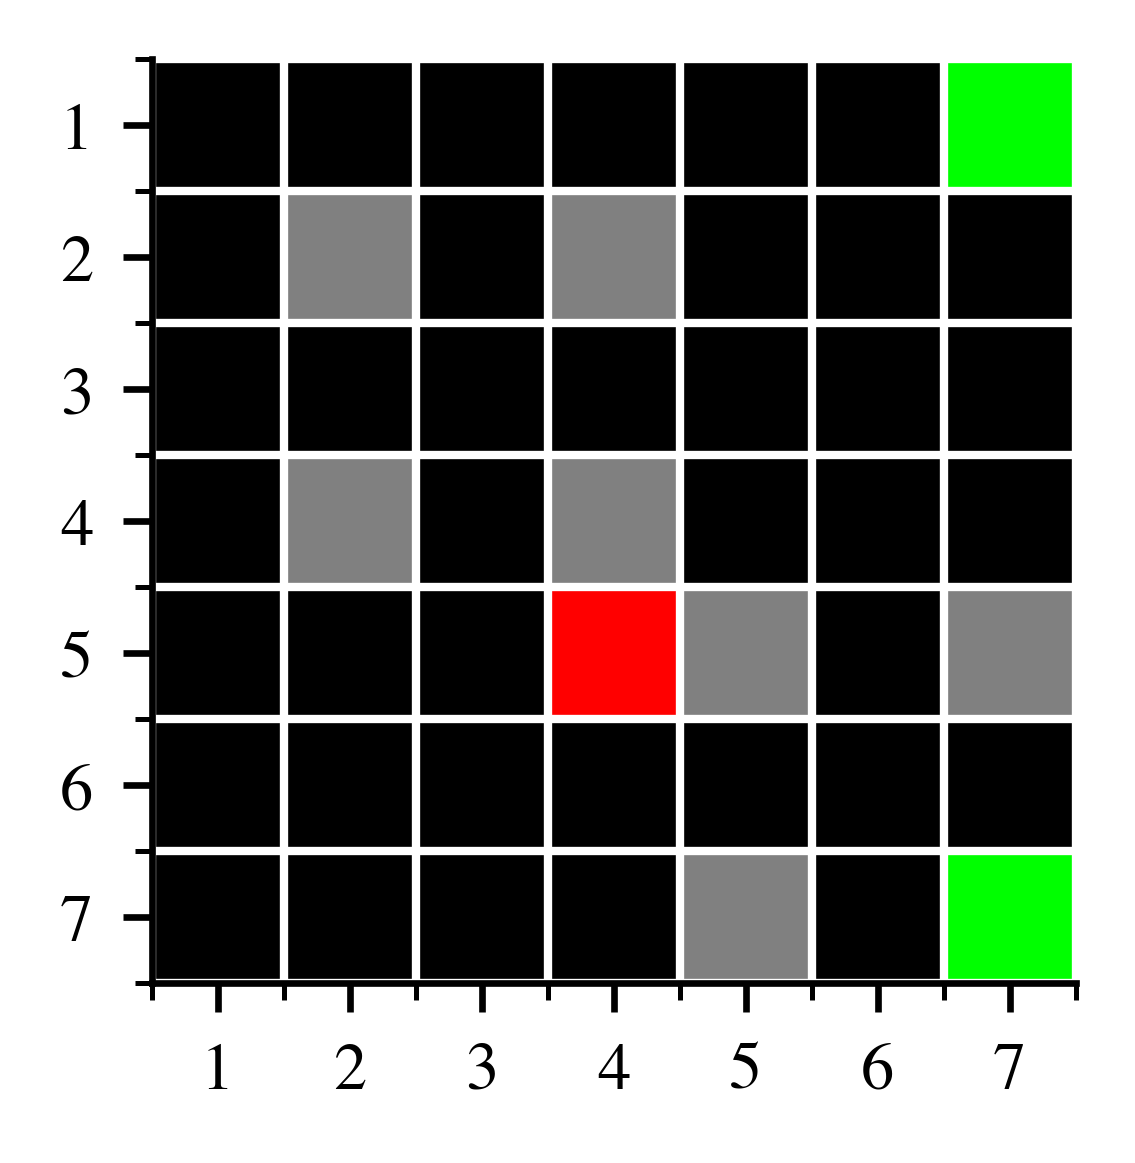

In [3]:
# # 7x7 Gridworld Environment
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
reward_dict = {1:0, -1:1, -0.1:2, 0:3}

#####

# Environment Definition
env_width = 7
env_height = 7
env = Environment(dim=(env_width, env_height),
                  starts=[(2, 0), (6, 2), (2,4)],
                  terminals={(0, 6): +1, (6, 6): +1, (4, 3): -1},
                  obstacles=[[1, 1], [1, 3], [3, 1], [3, 3], [4,4], [6, 4], [4,6]],
                  stoc=0.)

env.render(title='7x7 Gridworld')

# Initialize the agent
agent = Agent(env)

#####

In [4]:
# Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

def tokenizer(trajectories, state_space_dim, action_dict, reward_dict, max_traj_len = 25):
    """
        Tokenizer for capturing gridworld trajectories
    """

    action_space_dim = len(action_dict)
    reward_set_dim = len(reward_dict)
    
    # TOKEN IDs
    # 1 START TOKEN
    # 2 END TOKEN
    # 0 PAD TOKEN
    # STATE TOKENs
    # ACTION TOKENs
    # REWARD TOKENs
    
    complete_traj_tokens = []
    
    for traj in trajectories:
        # Traj contains (s,a,r,s')
        # We generate tokens for 's', 'a' and 'r'
        
        traj_tokens = []
        
        # Start token
        traj_tokens.append(1)
        
        for sars_ in traj:
            s = sars_[0]
            a = sars_[1]
            r = sars_[2]
            
            # State
            traj_tokens.append(3 + s)
            
            # Action
            traj_tokens.append(3 + state_space_dim + a)
            
            # Reward
            traj_tokens.append(3 + state_space_dim + action_space_dim + reward_dict[r])
        
        # Remove action and reward for terminal state, TO BE USED ONLY when (s_terminal, a_random, reward = 0, s_terminal) exists at the end of trajectory data
        traj_tokens.pop()
        traj_tokens.pop()
        
        # End token
        traj_tokens.append(2)
        
        # Pad with zero tokens
        if max_traj_len + 3 - len(traj) > 0:
            traj_tokens = traj_tokens + [0]*(3*(max_traj_len + 3 - len(traj)))
        
        complete_traj_tokens.append(torch.LongTensor(traj_tokens))
    
    return complete_traj_tokens

In [5]:
class LSTMEncoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.token_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size)

    def forward(self, traj):
        embeds = self.token_embeddings(traj)
        o, (h_n, c_n) = self.lstm(embeds.view(len(traj), 1, -1)) # Batch first is false, -> Input shape (L(seq len), N(num seq), H_in(hidden size))
        # The LSTM output contains :
        # o - Outputs of individual cells : shape (L, N, H)
        # h_n - Final hidden state
        # c_n - Final cell state
        return o[-1], (h_n, c_n)
    
class LSTMDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                    embedding_dim=embedding_size,
                                    )

        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden_state, cell_state):
        # Input is START TOKEN
        # Hidden state, Cell state are taken from encoder's output

        # Get embedding
        embedded = self.embedding(input)        
        output = embedded.view(len(input), 1, -1)
        
        # Run LSTM to decode the trajectory
        output, _ = self.lstm(output, (hidden_state, cell_state))
        
        # Convert LSTM logits to vocab size softmax 
        out = self.out(output.squeeze(1))
        output = F.log_softmax(out, dim=1)
        
        return output

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, traj):
        traj_embedding = self.encoder(traj[1:])
        decoded_traj = self.decoder(traj[:-1], traj_embedding[1][0], traj_embedding[1][1])
        return decoded_traj, traj_embedding


## 1

### Collecting offline trajectory data

In [6]:
# # Generate offline data for the training
# # # Set the seeds
# # random.seed(0)
# # np.random.seed(0)
# # torch.manual_seed(0)

# num_episodes_dyna = 5
# num_agents_dyna = 10
# max_traj_len = 10
# num_pos_trajs = 250
# num_neg_trajs = 50
# offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

#####

In [7]:
# Generate offline data for the training
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

# num_episodes_dyna = 2
# num_agents_dyna = 5
# max_traj_len = 10
# num_pos_trajs = 50
# num_neg_trajs = 10
# offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

# #####

In [8]:
# # If you are planning to pickle these trajectories and use them instead of generating them every time...
# # # 300 trajectories
# num_episodes_dyna = 5
# num_agents_dyna = 10
# max_traj_len = 10
# num_pos_trajs = 250
# num_neg_trajs = 50
# results_save_dir = './gridworld_results/grid_7by7/'
# # with open(os.path.join(results_save_dir, 'offline_traj300.pkl'), 'wb') as f:
# #     pickle.dump(offline_data, f)

# with open(os.path.join(results_save_dir, 'offline_traj300.pkl'), 'rb') as f:
#     offline_data = pickle.load(f)

In [9]:
# # # ## 60 trajectories
num_episodes_dyna = 2
num_agents_dyna = 5
max_traj_len = 10
num_pos_trajs = 50
num_neg_trajs = 10
results_save_dir = './gridworld_results/grid_7by7/'
# with open(os.path.join(results_save_dir, 'offline_traj60.pkl'), 'wb') as f:
#     pickle.dump(offline_data, f)

with open(os.path.join(results_save_dir, 'offline_traj60.pkl'), 'rb') as f:
    offline_data = pickle.load(f)

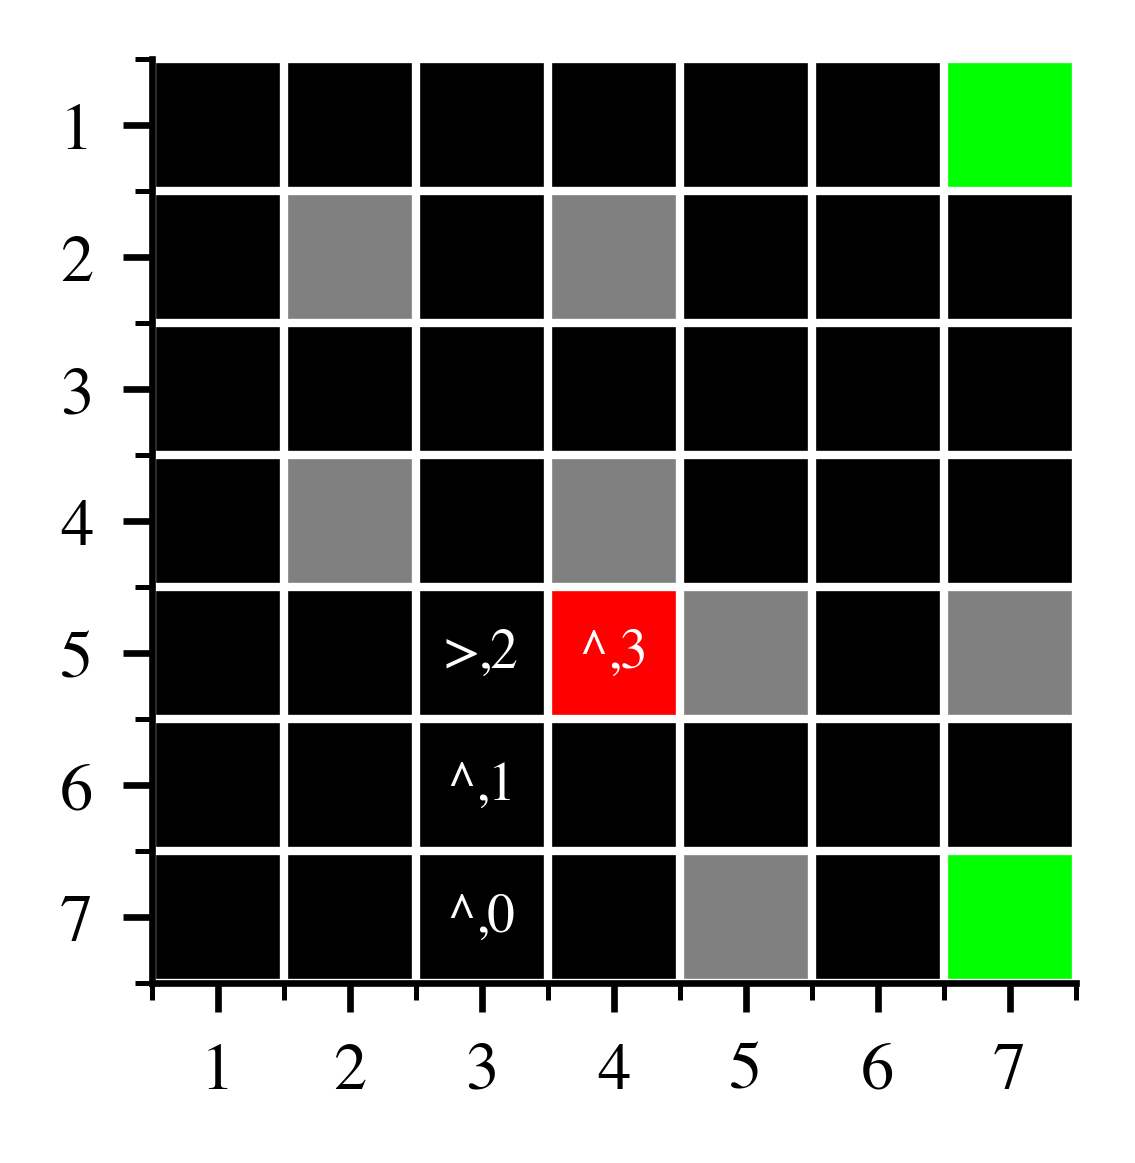

In [11]:
# Plot a trajectory to check if the data has been correctly formed
env.plot_traj(offline_data[-1])

### Sequential Encoder (i)

We use sequential encoder to parse the offline data and create clusters of the trajectories which will be used for attributing the decisions in the later steps.

Embedding dim: 16, Hidden dim: 32, Learning rate: 1
Epoch: 1, Loss:1.11340346544981
Epoch: 2, Loss:0.5122088016569615
Epoch: 3, Loss:0.3917909574881196
Epoch: 4, Loss:0.3165824056789279
Epoch: 5, Loss:0.2592676686123013
Epoch: 6, Loss:0.2183819454908371
Epoch: 7, Loss:0.19150890585035085
Epoch: 8, Loss:0.17201273366808892
Epoch: 9, Loss:0.1587253575026989
Epoch: 10, Loss:0.14653272299095987
Epoch: 11, Loss:0.13742611272260546
Epoch: 12, Loss:0.13037823842838406
Epoch: 13, Loss:0.1249823035672307
Epoch: 14, Loss:0.11977013442665338
Epoch: 15, Loss:0.11483585722744465
Epoch: 16, Loss:0.1119763720780611
Epoch: 17, Loss:0.1080980883911252
Epoch: 18, Loss:0.10567527451552451
Epoch: 19, Loss:0.10390043838880957
Epoch: 20, Loss:0.1015754290111363
Epoch: 21, Loss:0.10098108118399977
Epoch: 22, Loss:0.09863811549730599
Epoch: 23, Loss:0.09720131874084473
Epoch: 24, Loss:0.0958835768327117
Epoch: 25, Loss:0.09479318615980446
Best loss model updated to the one having:  1 16 32


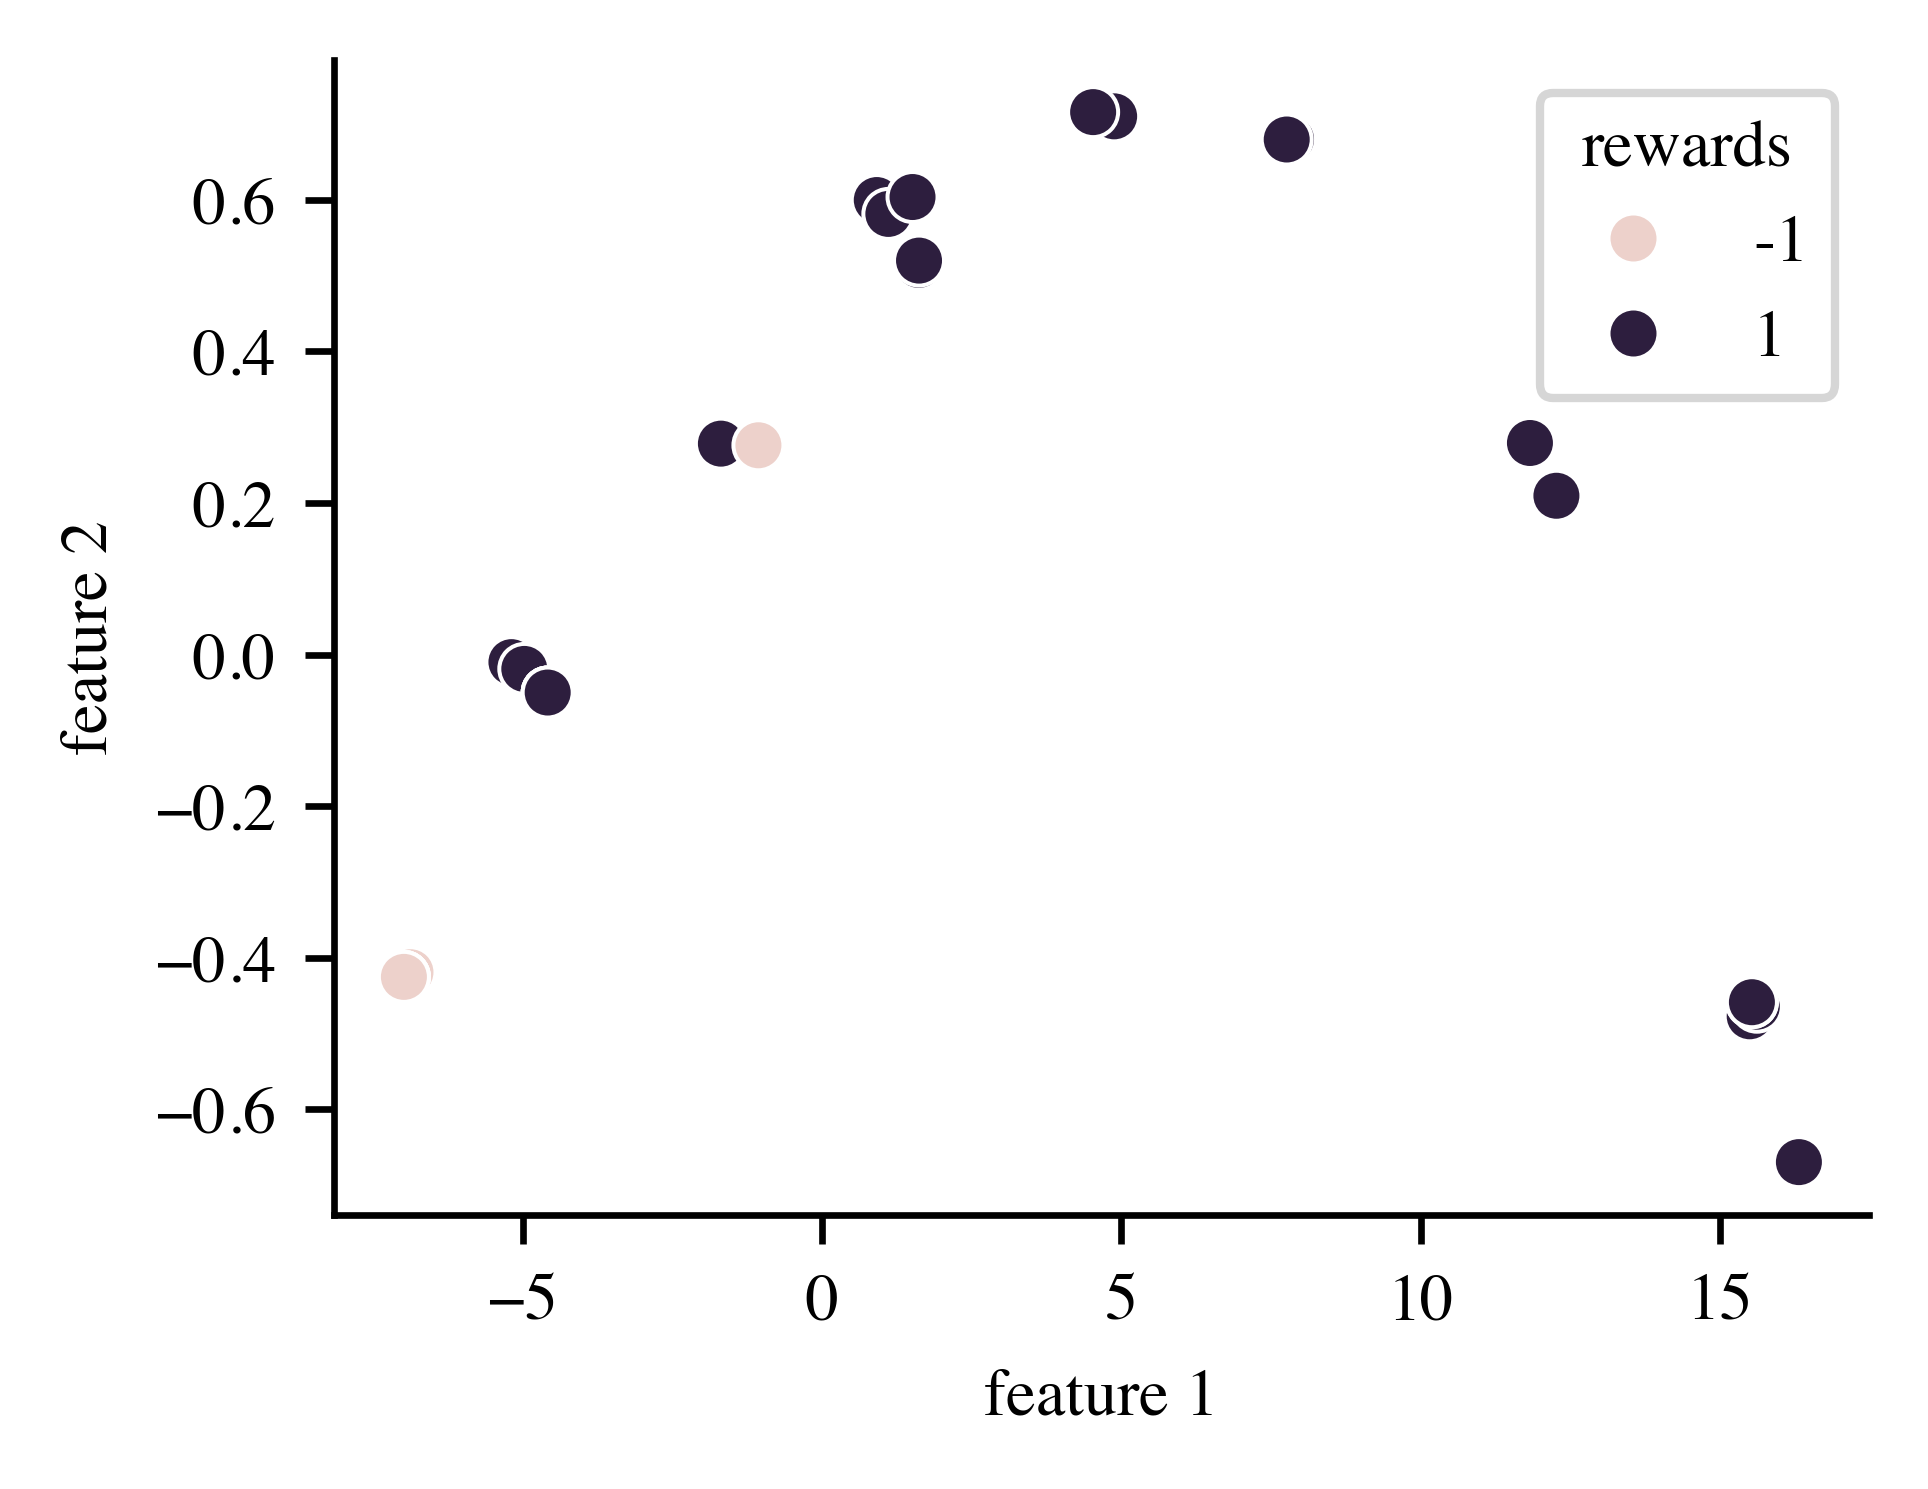

Total WCE: 2.6428404538520986
Clusters: [[0, 5, 12, 21], [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25], [51, 52, 53, 54, 56, 57, 58, 59], [55], [27, 28, 29, 30, 31, 32, 33, 34, 35], [26, 50], [42, 43, 44, 45, 46, 47, 48, 49], [40, 41], [38, 39], [36, 37]]
Number of clusters 10


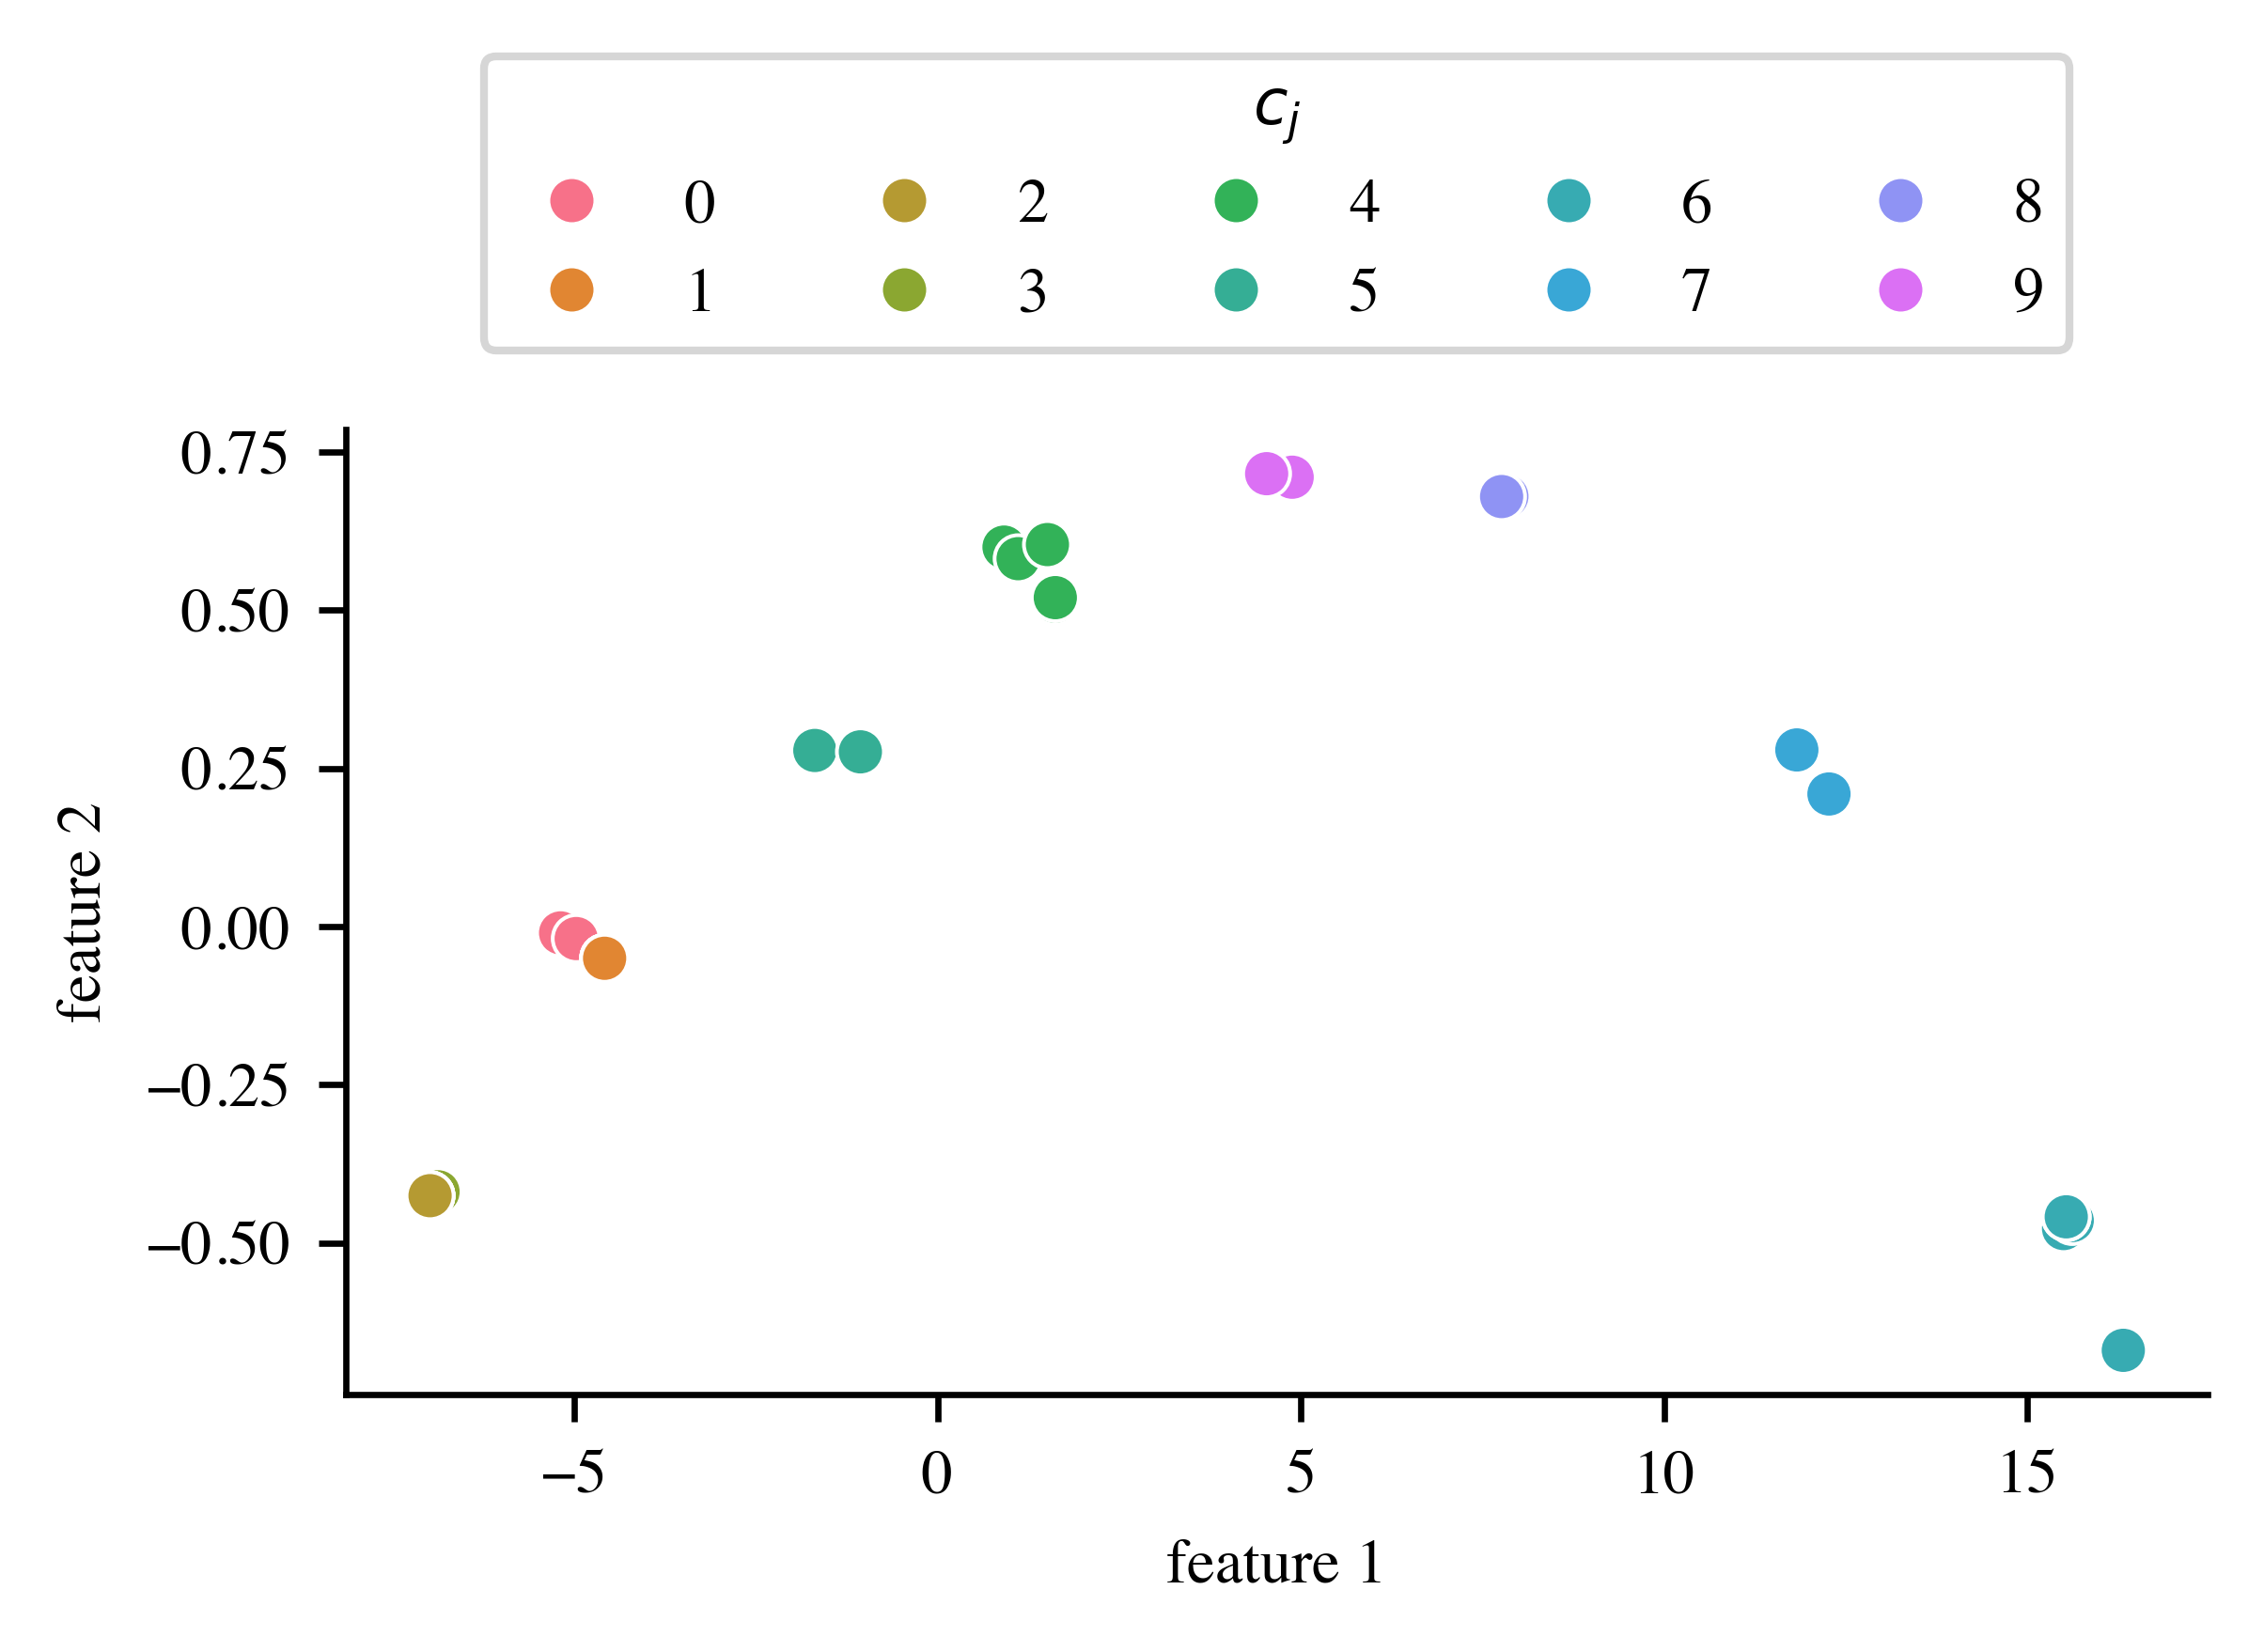

Embedding dim: 16, Hidden dim: 32, Learning rate: 0.1
Epoch: 1, Loss:2.2299352049827577
Epoch: 2, Loss:1.8041277170181274
Epoch: 3, Loss:1.588840489387512
Epoch: 4, Loss:1.3822097194194793
Epoch: 5, Loss:1.1760485672950745
Epoch: 6, Loss:1.0099099498987198
Epoch: 7, Loss:0.8859466260671616
Epoch: 8, Loss:0.7941667711734772
Epoch: 9, Loss:0.7251165860891342
Epoch: 10, Loss:0.6694401735067368
Epoch: 11, Loss:0.6224382758140564
Epoch: 12, Loss:0.5822017771005631
Epoch: 13, Loss:0.5475464448332786
Epoch: 14, Loss:0.517769549190998
Epoch: 15, Loss:0.49223091796040536
Epoch: 16, Loss:0.4699565204977989
Epoch: 17, Loss:0.45018415823578833
Epoch: 18, Loss:0.4325986625254154
Epoch: 19, Loss:0.41700427904725074
Epoch: 20, Loss:0.40247257515788076
Epoch: 21, Loss:0.38885577097535134
Epoch: 22, Loss:0.37602085098624227
Epoch: 23, Loss:0.36357505768537524
Epoch: 24, Loss:0.3520291462540627
Epoch: 25, Loss:0.3409638933092356
Embedding dim: 16, Hidden dim: 32, Learning rate: 0.01
Epoch: 1, Loss:2.420

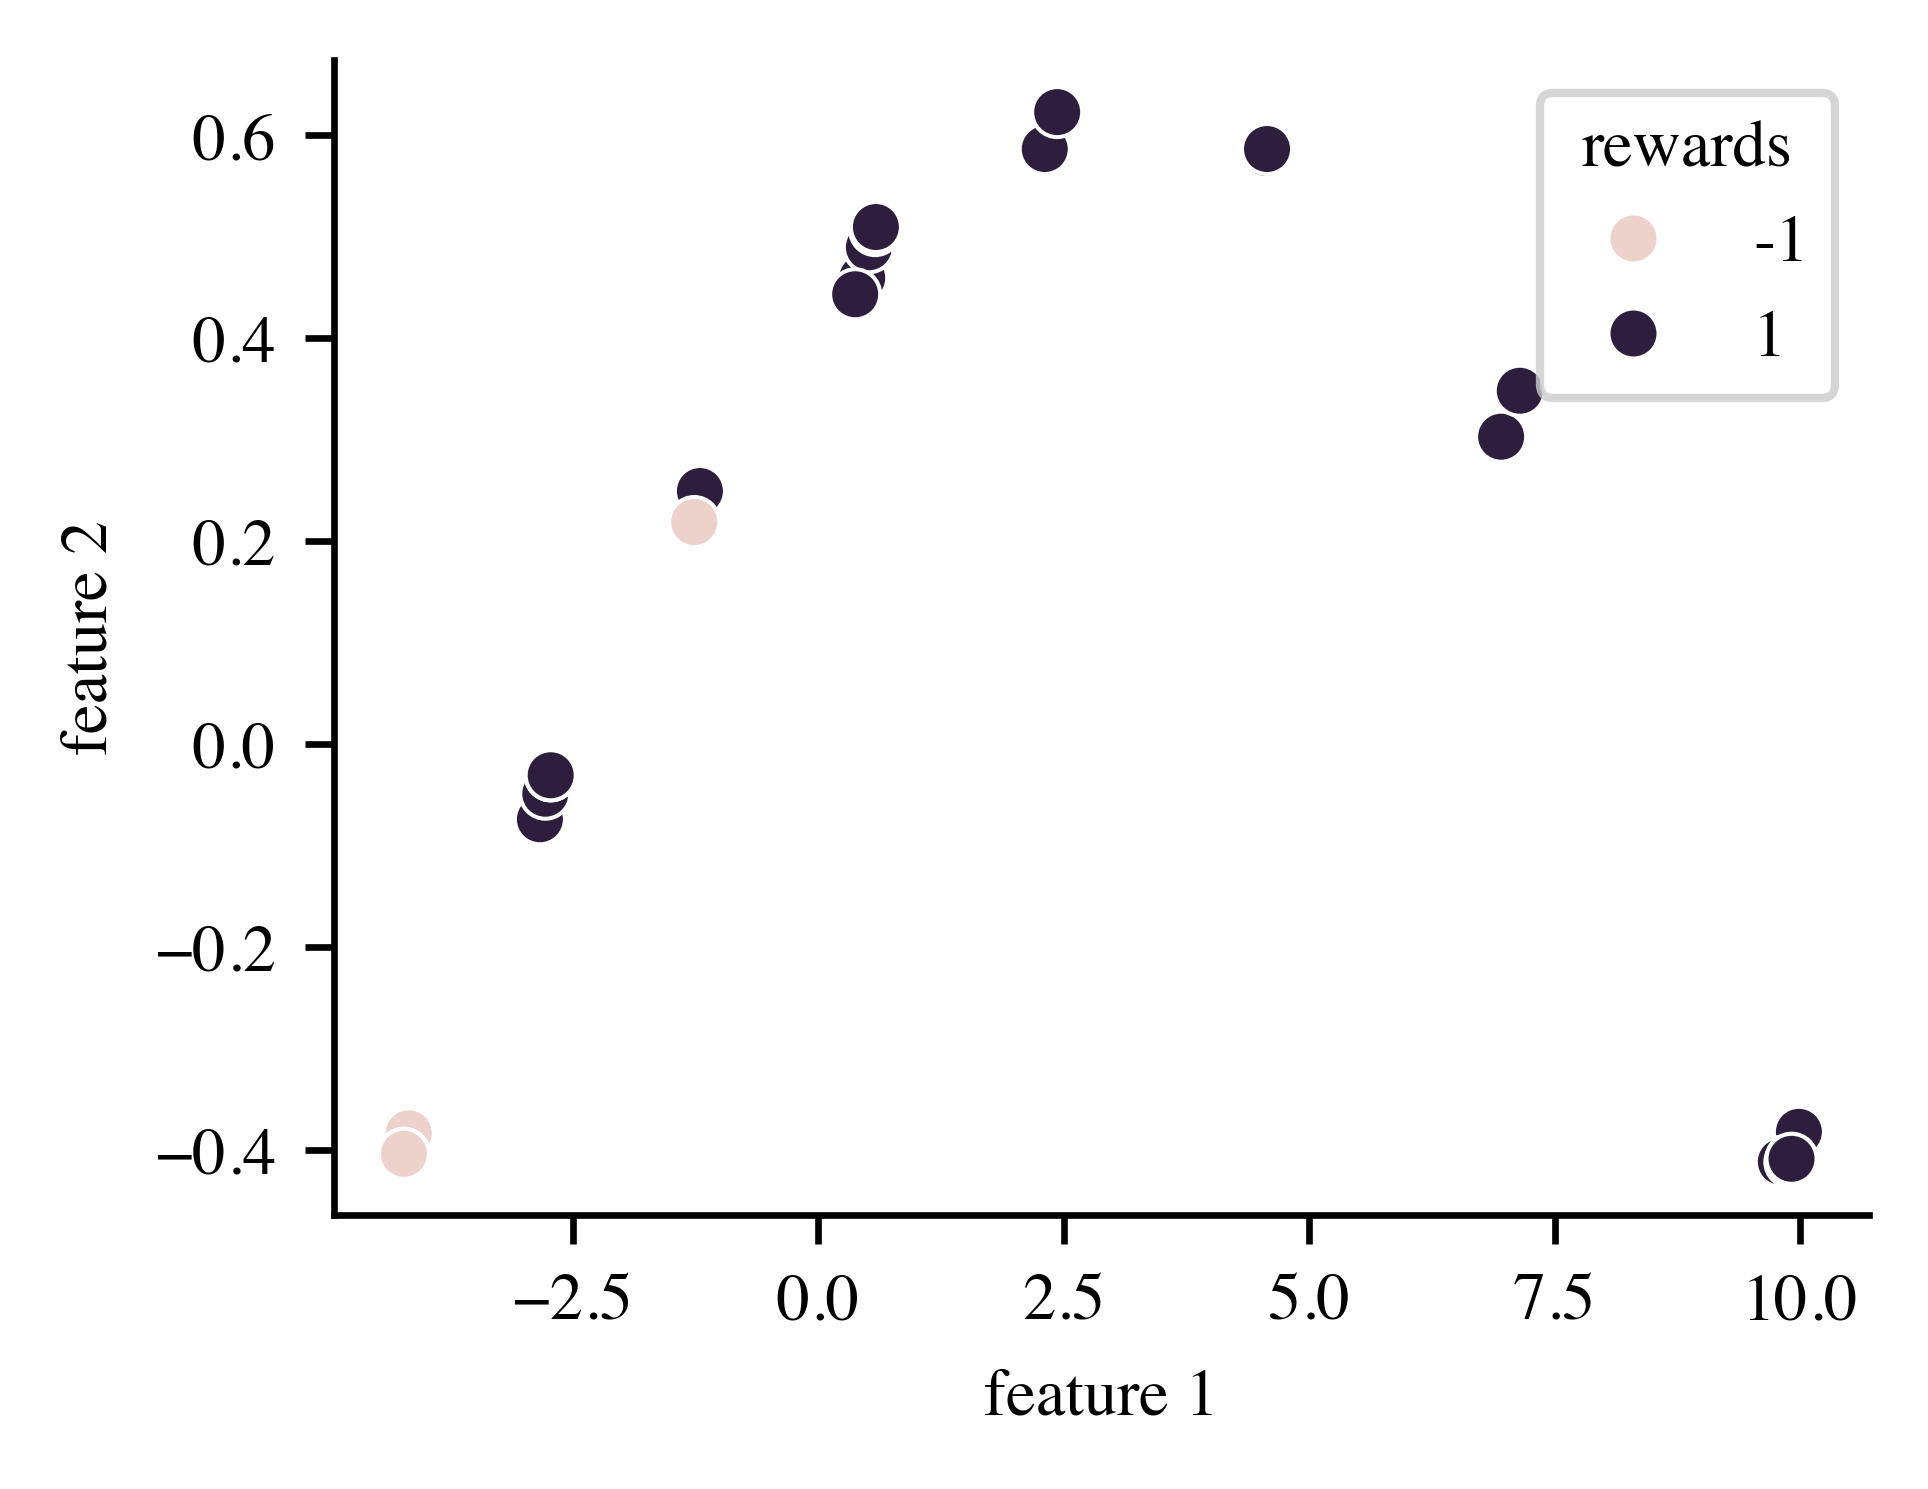

Total WCE: 0.15644116287317975
Clusters: [[26, 50], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], [51, 52, 53, 54, 56, 57, 58, 59], [55], [27, 28, 29, 30, 31, 32, 33, 34, 35], [36, 37], [42, 43, 44, 45, 47, 48, 49], [46], [40, 41], [38, 39]]
Number of clusters 10


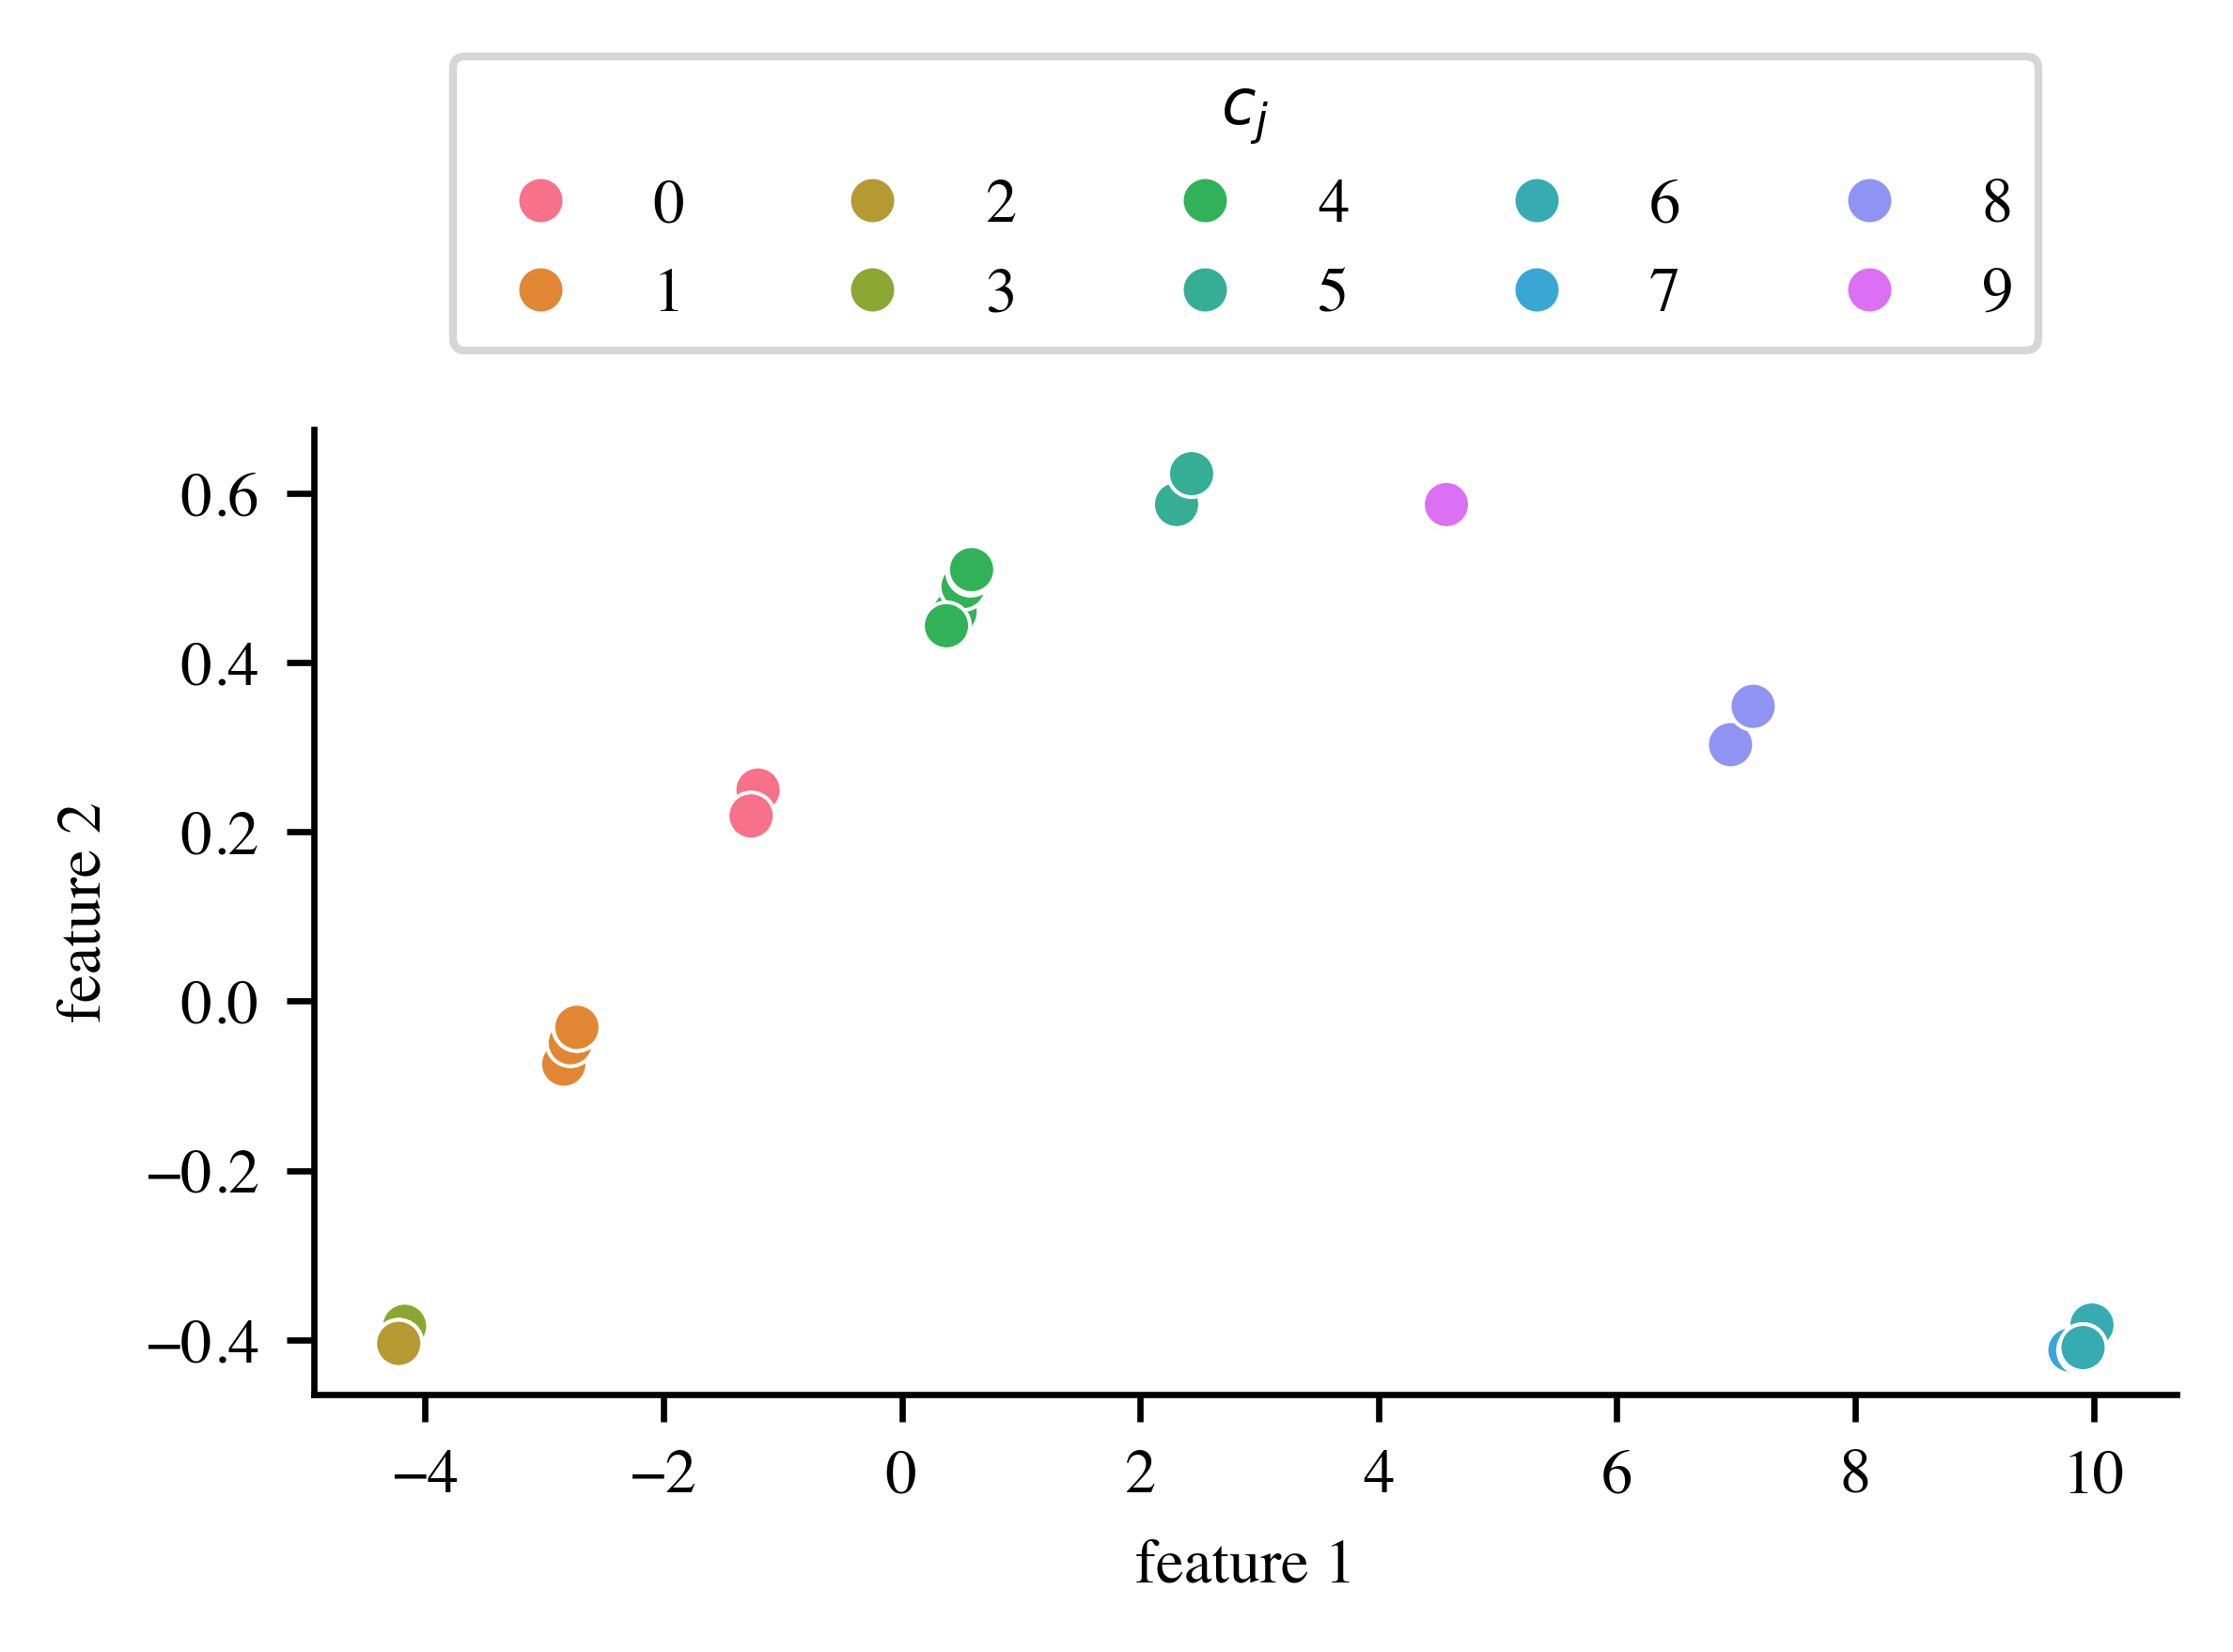

Embedding dim: 16, Hidden dim: 64, Learning rate: 0.1
Epoch: 1, Loss:2.1846820878982545
Epoch: 2, Loss:1.7340230417251588
Epoch: 3, Loss:1.5082005596160888
Epoch: 4, Loss:1.2875102078914642
Epoch: 5, Loss:1.077262488603592
Epoch: 6, Loss:0.9072523099184037
Epoch: 7, Loss:0.7780204626917839
Epoch: 8, Loss:0.6837579551339149
Epoch: 9, Loss:0.6143552261590958
Epoch: 10, Loss:0.5640828455984592
Epoch: 11, Loss:0.5178759990632534
Epoch: 12, Loss:0.48199096411466597
Epoch: 13, Loss:0.45176889389753344
Epoch: 14, Loss:0.4235563038289547
Epoch: 15, Loss:0.4007422951608896
Epoch: 16, Loss:0.3814855653047562
Epoch: 17, Loss:0.3634136888384819
Epoch: 18, Loss:0.34716939233243466
Epoch: 19, Loss:0.3324500048160553
Epoch: 20, Loss:0.31874763913452625
Epoch: 21, Loss:0.3054107830673456
Epoch: 22, Loss:0.29262525588274
Epoch: 23, Loss:0.28044344648718833
Epoch: 24, Loss:0.2689231550693512
Epoch: 25, Loss:0.25804467022418975
Embedding dim: 16, Hidden dim: 64, Learning rate: 0.01
Epoch: 1, Loss:2.44734

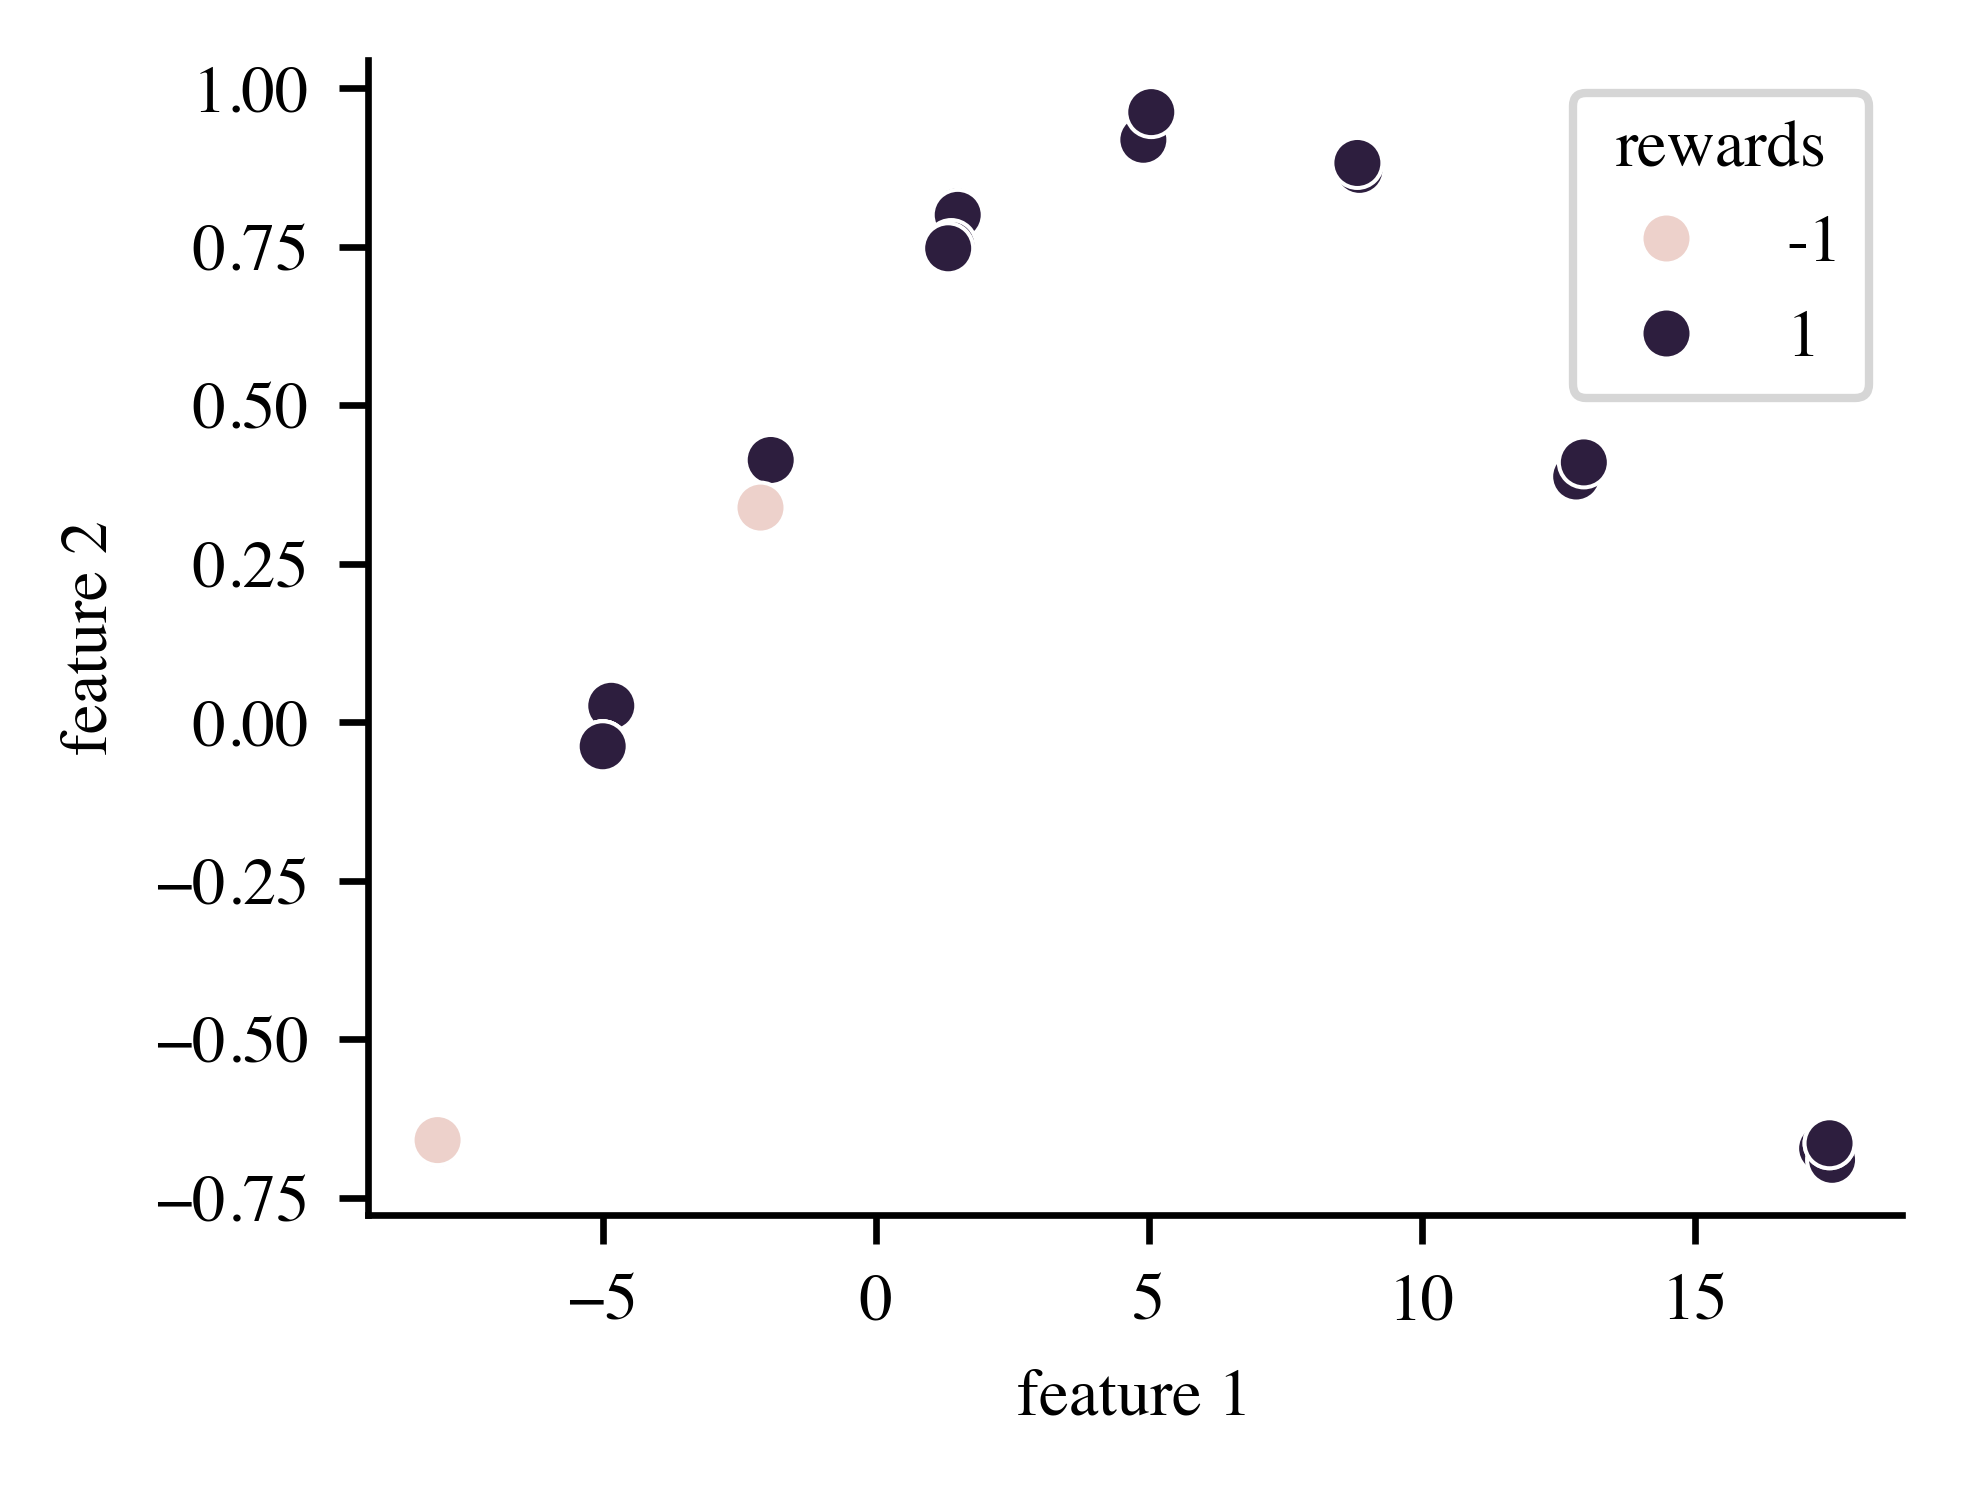

Total WCE: 0.18694037758379523
Clusters: [[0, 5, 12, 21], [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25], [51, 52, 53, 54, 56, 57, 58, 59], [55], [27, 28, 29, 30, 31, 32, 33, 34, 35], [26, 50], [42, 43, 44, 45, 46, 47, 48, 49], [40, 41], [38, 39], [36, 37]]
Number of clusters 10


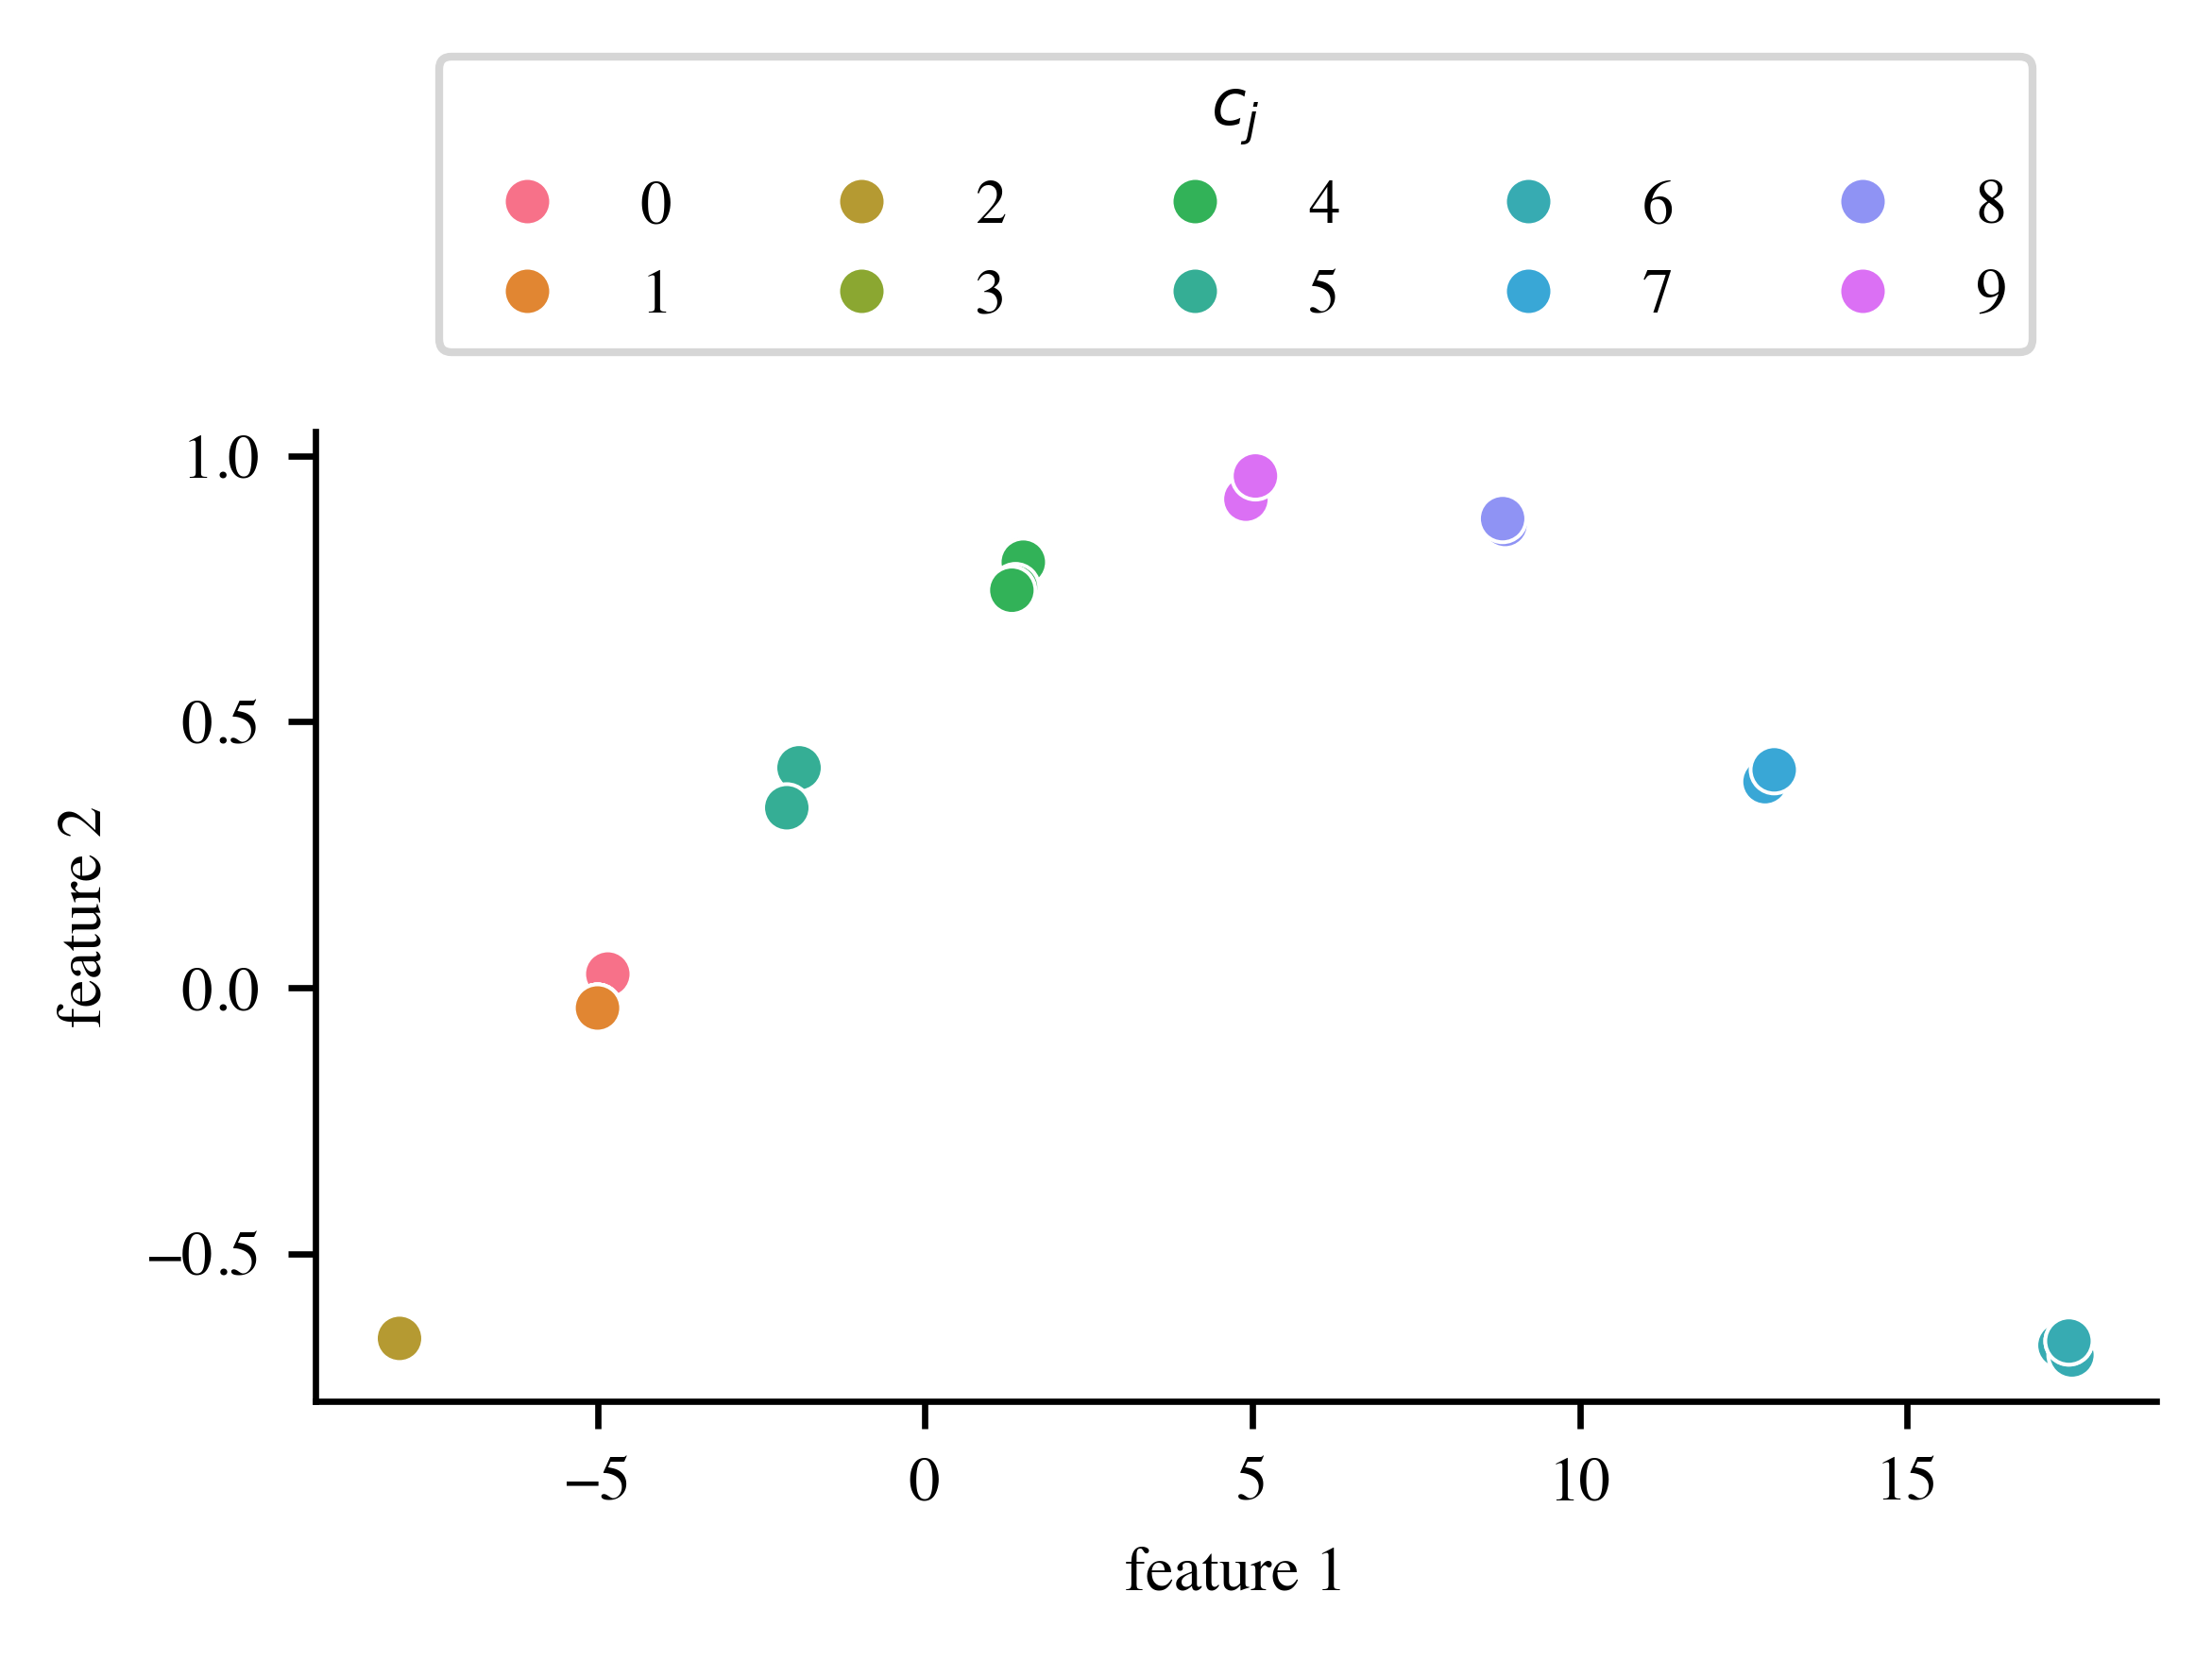

Embedding dim: 16, Hidden dim: 128, Learning rate: 0.1
Epoch: 1, Loss:2.1824117422103884
Epoch: 2, Loss:1.7224817943572999
Epoch: 3, Loss:1.4998338758945464
Epoch: 4, Loss:1.272848733663559
Epoch: 5, Loss:1.028138475418091
Epoch: 6, Loss:0.8290927517414093
Epoch: 7, Loss:0.6973673316836357
Epoch: 8, Loss:0.6136273282766342
Epoch: 9, Loss:0.5581641077995301
Epoch: 10, Loss:0.5124181453883648
Epoch: 11, Loss:0.4715429799258709
Epoch: 12, Loss:0.44011154033243655
Epoch: 13, Loss:0.414374912455678
Epoch: 14, Loss:0.3937397615611553
Epoch: 15, Loss:0.3765211537480354
Epoch: 16, Loss:0.36421315252780917
Epoch: 17, Loss:0.34485293433070185
Epoch: 18, Loss:0.3307442045211792
Epoch: 19, Loss:0.31709292739629746
Epoch: 20, Loss:0.3041525542736053
Epoch: 21, Loss:0.2918842111155391
Epoch: 22, Loss:0.2796762814745307
Epoch: 23, Loss:0.26789897501468657
Epoch: 24, Loss:0.2568840141966939
Epoch: 25, Loss:0.245987318046391
Embedding dim: 16, Hidden dim: 128, Learning rate: 0.01
Epoch: 1, Loss:2.43829

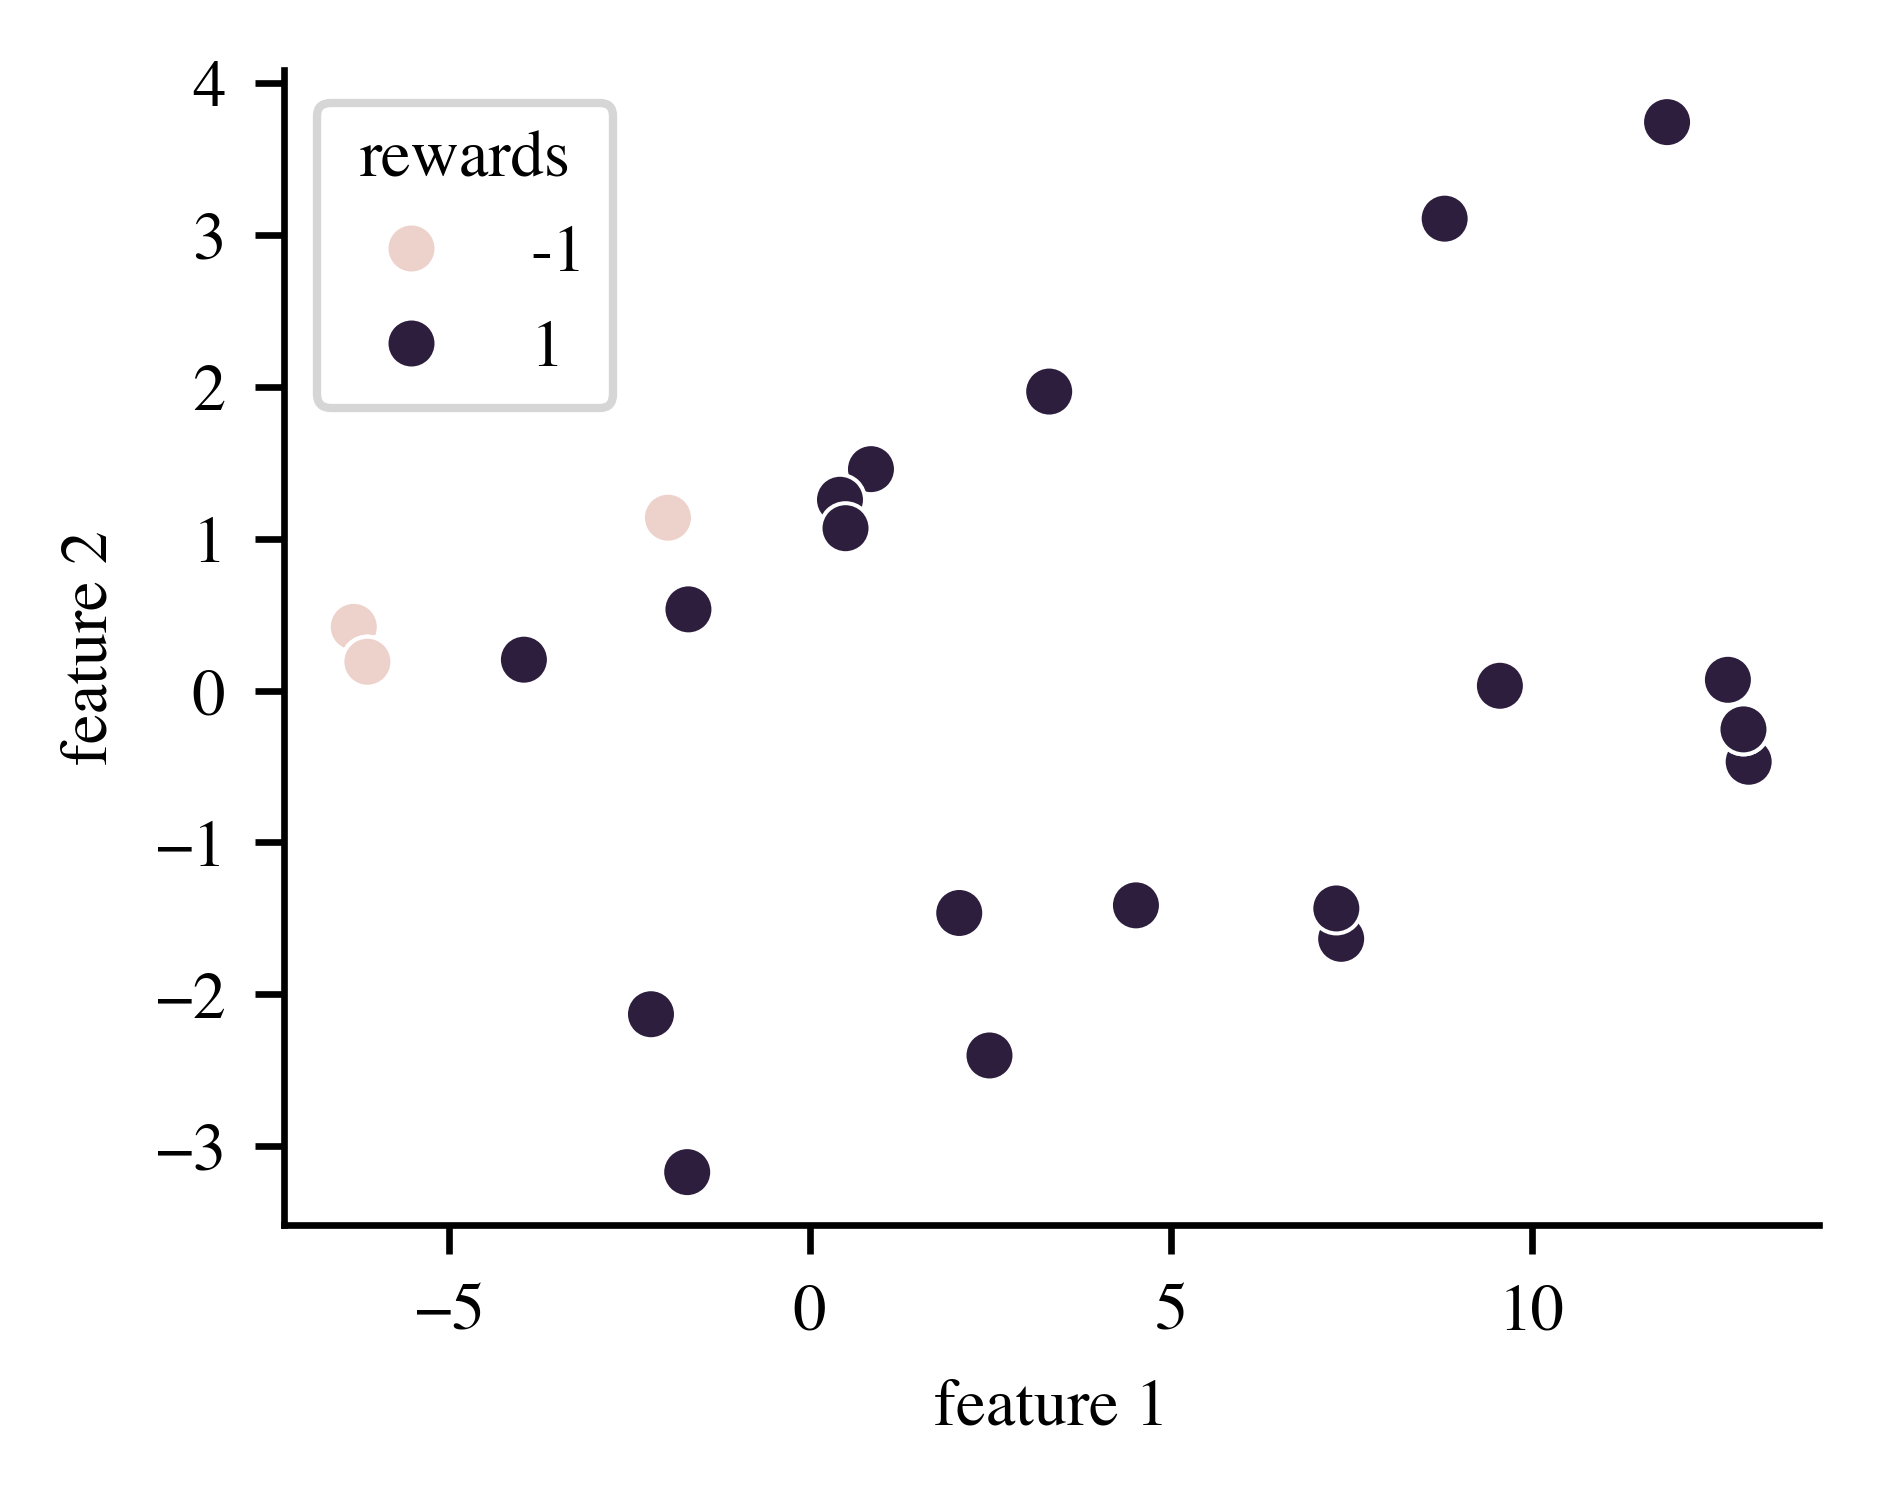

Total WCE: 50.7299390416945
Clusters: [[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 51, 52, 53, 54, 55, 56, 57, 58, 59], [26, 50], [21], [0, 5, 12], [28, 29, 30, 33, 34, 35, 36], [27, 31, 32], [40, 46], [42, 43, 44, 45, 47, 48, 49], [38, 39, 41], [37]]
Number of clusters 10


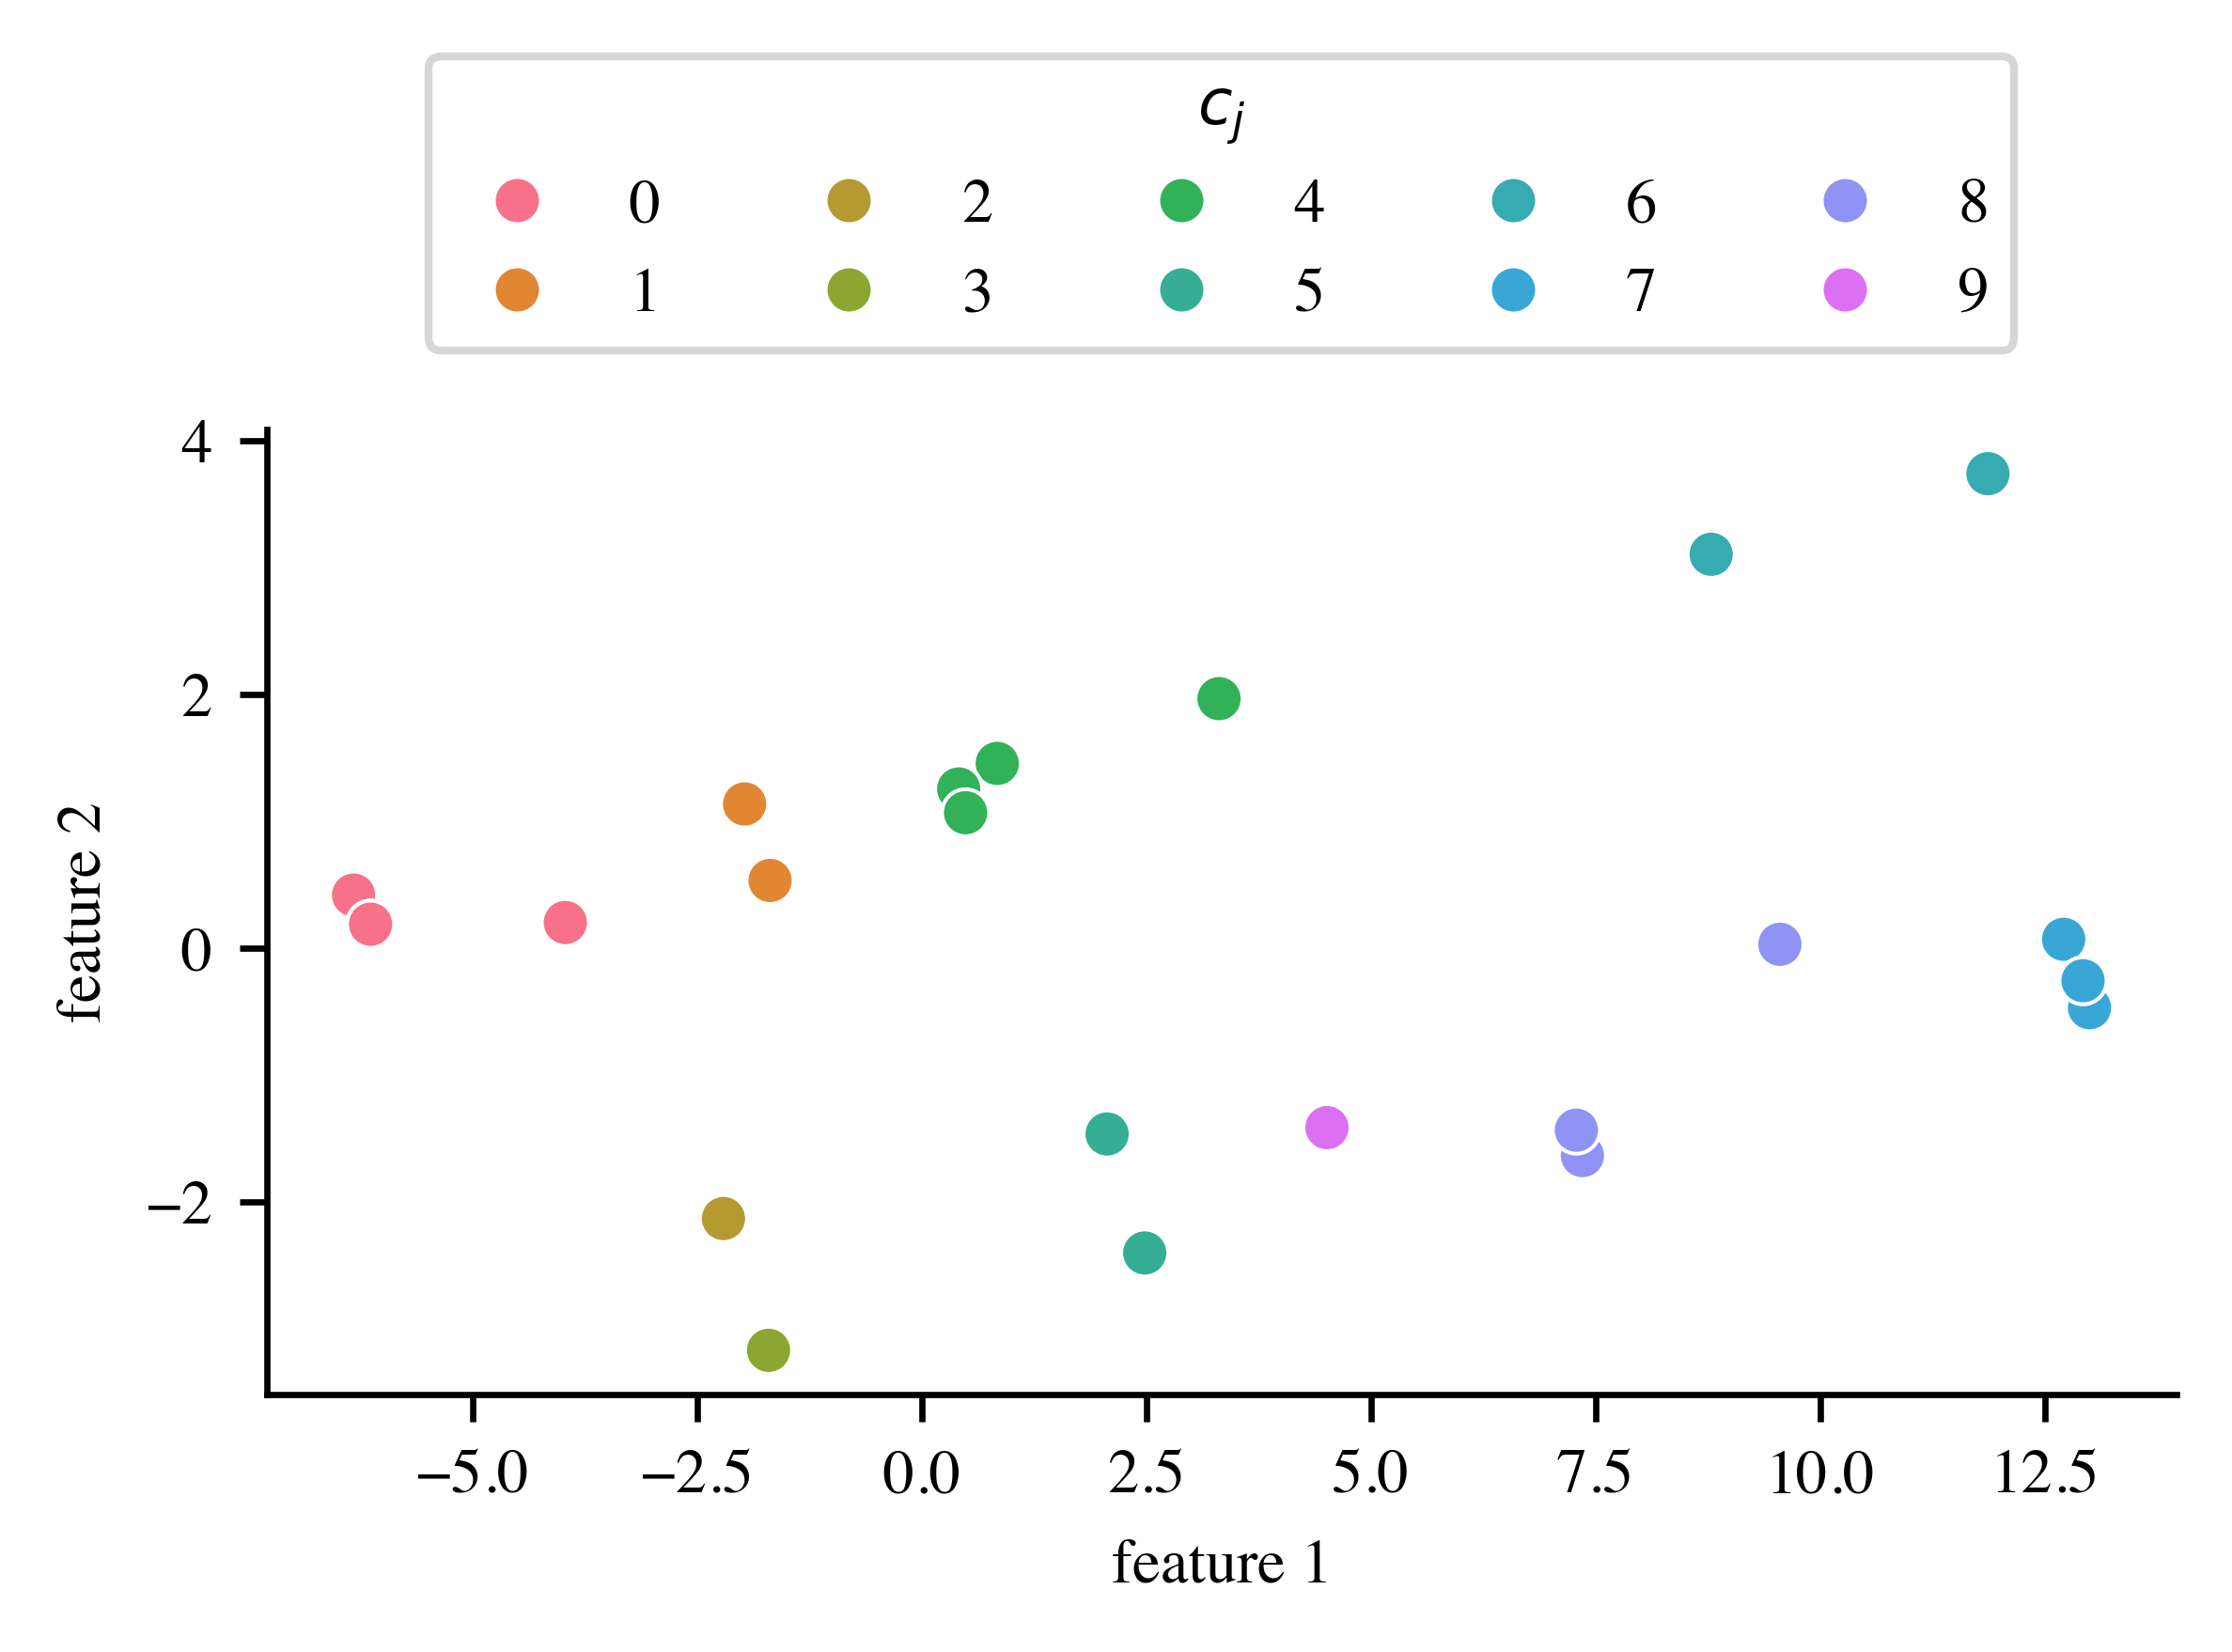

Embedding dim: 32, Hidden dim: 64, Learning rate: 0.1
Epoch: 1, Loss:2.0771379232406617
Epoch: 2, Loss:1.5761344623565674
Epoch: 3, Loss:1.2653931963443756
Epoch: 4, Loss:0.9975221943855286
Epoch: 5, Loss:0.8169458162784576
Epoch: 6, Loss:0.703750705420971
Epoch: 7, Loss:0.6274686068296432
Epoch: 8, Loss:0.5695517598092557
Epoch: 9, Loss:0.5222715844213962
Epoch: 10, Loss:0.4822372964024544
Epoch: 11, Loss:0.44772822797298434
Epoch: 12, Loss:0.41836916118860246
Epoch: 13, Loss:0.39366492241621015
Epoch: 14, Loss:0.3725898706167936
Epoch: 15, Loss:0.35408070296049116
Epoch: 16, Loss:0.3376454721391201
Epoch: 17, Loss:0.3231472159177065
Epoch: 18, Loss:0.31016488760709765
Epoch: 19, Loss:0.2984760358184576
Epoch: 20, Loss:0.2878970184922218
Epoch: 21, Loss:0.278204336091876
Epoch: 22, Loss:0.2691966428607702
Epoch: 23, Loss:0.2607213180884719
Epoch: 24, Loss:0.2526761684194207
Epoch: 25, Loss:0.24499712828546763
Embedding dim: 32, Hidden dim: 64, Learning rate: 0.01
Epoch: 1, Loss:2.4201

In [47]:
embed_list = [16, 32, 64, 128]
hidden_list = [32, 64, 128]
lr_list = [1, 0.1, 0.01]

best_loss_model = []
optimal_loss = 1e9

for embedding_dim in embed_list:
    for hidden_size in hidden_list:
        for lr in lr_list:
            if hidden_size > embedding_dim:
                print("Embedding dim: {}, Hidden dim: {}, Learning rate: {}".format(embedding_dim, hidden_size, lr))

                vocab_size = 3 + env_width*env_height + len(action_dict) + len(reward_dict)

                tokenized_data = tokenizer(offline_data, 
                                        state_space_dim = env_width*env_height, 
                                        action_dict = action_dict, 
                                        reward_dict = reward_dict, 
                                        max_traj_len = max_traj_len)
                
                traj_encoder = LSTMEncoder(embedding_dim=embedding_dim, vocab_size= vocab_size, hidden_size=hidden_size)
                traj_decoder = LSTMDecoder(embedding_size=embedding_dim, hidden_size=hidden_size, vocab_size=vocab_size)

                model = Seq2Seq(traj_encoder, traj_decoder)

                # Hyperparameters 
                num_epochs = 25

                # Optimizer
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)

                # # Set the seeds
                # random.seed(0)
                # np.random.seed(0)
                # torch.manual_seed(0)

                for epoch_id, epoch in enumerate(range(num_epochs)):
                    total_loss = 0
                    for traj_id, traj in enumerate(tokenized_data):
                        optimizer.zero_grad()
                        
                        # Get decoded trajectory and its embedding
                        decoded_traj, traj_embedding = model(traj)
                        # Loss
                        loss = F.nll_loss(decoded_traj.view(-1, vocab_size),
                                        traj[1:].contiguous().view(-1),
                                        ignore_index=0)
                        
                        # Optimize the model
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
                        optimizer.step()
                        
                        # Record loss
                        total_loss += loss.data.item()

                    total_loss = total_loss / 100
                    
                    print(f'Epoch: {epoch_id + 1}, Loss:{total_loss}')
                
                if total_loss < optimal_loss:
                    optimal_loss = total_loss
                    best_loss_model = model
                    print("Best loss model updated to the one having: ", embedding_dim, hidden_size, lr)


                    # Load and generate trajectory embeddings
                    traj_embeddings = []

                    for traj_id, traj in enumerate(tokenized_data):
                        with torch.no_grad():
                            decoded_traj, traj_embedding = best_loss_model(traj)
                            # print(traj_embedding[1])
                            traj_embeddings.append(torch.cat(traj_embedding[1], axis=-1).numpy().reshape(-1))

                    ## PCA
                    traj_embeddings[59].shape


                    pca = PCA(n_components=2)
                    pca_traj_embeddings = pca.fit_transform(traj_embeddings)
                    plotting_data = {'feature 1': pca_traj_embeddings[:, 0], 'feature 2': pca_traj_embeddings[:, 1],
                                    'rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs}
                    df = pd.DataFrame(plotting_data)

                    plt.figure()
                    sns.scatterplot(x='feature 1', y='feature 2', hue='rewards', data=df)
                    # plt.title('PCA: Trajectory Embeddings')
                    # plt.legend()
                    plt.show()

                    amount_initial_centers = 2
                    initial_centers = kmeans_plusplus_initializer(traj_embeddings, amount_initial_centers, random_state = 0).initialize()
                    
                    # Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
                    # number of clusters that can be allocated is 10.
                    ## mre then 10 clusters is pointless because by plotting them we see visually there are no more then 9.
                    xmeans_instance = xmeans(traj_embeddings, initial_centers, 10, random_state=0)
                    xmeans_instance.process()
                    
                    # Extract clustering results: clusters and their centers
                    clusters = xmeans_instance.get_clusters()
                    centers = xmeans_instance.get_centers()
                    
                    # Print total sum of metric errors
                    print("Total WCE:", xmeans_instance.get_total_wce())
                    print("Clusters:", clusters)
                    print('Number of clusters', len(clusters))


                    traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

                    for cluster_id, cluster in enumerate(clusters):
                        for traj_id in cluster:
                            traj_cluster_labels[traj_id] = cluster_id


                    palette = sns.color_palette('husl', len(clusters) + 1)

                    pca_traj = PCA(n_components=2)
                    pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
                    plotting_data = {'feature 1': pca_traj_embeds[:, 0],
                                    'feature 2': pca_traj_embeds[:, 1],
                                    'cluster id': traj_cluster_labels}
                    df = pd.DataFrame(plotting_data)

                    plt.figure(figsize=(4,3))
                    data_ax = sns.scatterplot(x='feature 1',
                                            y='feature 2',
                                            hue='cluster id',
                                            palette=palette[:len(clusters)],
                                            data=df,
                                            legend=True)
                    plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
                    # plt.legend(title = '$c_{j}$', loc='center left', bbox_to_anchor=(1., 0.7), ncol=2)
                    # for cid, _ in enumerate(cluster_data_embeds):
                    #     data_ax.text(pca_data_embeds[:, 0][cid],
                    #                  pca_data_embeds[:, 1][cid],
                    #                  str(cid),
                    #                  horizontalalignment='left',
                    #                  size='medium',
                    #                  color='black',
                    #                  weight='semibold')
                    plt.tight_layout()
                    plt.savefig('./traj_clustering_grid.pdf')
                    plt.show()



# print("Best final loss model: ", best_loss_model, "with loss: ", optimal_loss, "learning rate: ", lr, "and embedding dim: ", embedding_dim, "and hidden dim: ", hidden_size)
# torch.save(best_loss_model.state_dict(), './ckpt_save_dir/best_model_hyperparameter_tuning.pth')



### Encode sets of trajectories (iii)

**(iii) Data Embedding**

Next we encode cells following the procedure explained in Algorithm 3 in paper. 

- Give the embedding trajectories as input
- Sum and Normalize these embedding trajectories
- Finally apply softmax.
- This is the final data embedding. A final step is done to construct the so-called complementary data embedding sets.
    - A of complementary data embedding sets are created by leaving out each time those embeddings belonging to the same class a part from the first which is comprised of all trajectories
    This way these resulting complementary sets have all the trajectories from the original data except those belonging to one cluster, which every time changes creating the number of cluster + 1 

Question I have is: what is T_soft from Algorithm 3? 
- Figured it out,it is the number of clusters 

In [57]:
# def get_data_embedding(traj_embeddings):
# #     return np.exp(np.abs(np.array(traj_embeddings).sum(axis=0)/100.))/np.sum(np.abs(np.exp(np.array(traj_embeddings).sum(axis=0)/100.)))
#     return np.exp(np.array(traj_embeddings).sum(axis=0)/len(clusters))/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/len(clusters)))

def get_data_embedding(traj_embeddings):
    max_val = np.max(traj_embeddings)
    exp_values = np.exp(np.array(traj_embeddings) - max_val)
    return exp_values.sum(axis=0) / len(clusters) / np.sum(exp_values)


data_embedding = get_data_embedding(traj_embeddings)
data_embedding

array([1.31530556e-04, 1.62292505e-04, 1.32357702e-04, 2.04922966e-04,
       6.50285147e-05, 1.39114927e-04, 1.62284981e-04, 8.62144807e-05,
       9.87262974e-05, 7.31773762e-05, 1.81667900e-04, 1.16367657e-04,
       7.44548379e-05, 1.40922537e-04, 8.00451744e-05, 2.66204297e-04,
       8.45253307e-05, 2.19795940e-04, 2.03827454e-04, 6.90001398e-05,
       2.22323972e-04, 9.74719878e-05, 7.64924698e-05, 7.04793638e-05,
       2.57318810e-04, 6.70688678e-05, 7.48278835e-05, 1.27130785e-04,
       2.51866033e-04, 2.65382987e-04, 1.41205586e-04, 2.16416927e-04,
       1.40676668e-04, 2.08248559e-04, 1.99316681e-04, 1.93047352e-04,
       7.42530974e-05, 6.90263623e-05, 1.23246486e-04, 2.02922995e-04,
       7.77343812e-05, 1.35325972e-04, 7.48609818e-05, 7.77689202e-05,
       1.59314659e-04, 8.90711817e-05, 6.91976675e-05, 2.57535226e-04,
       2.70529359e-04, 1.12683527e-04, 2.57174397e-04, 6.73559698e-05,
       2.03592412e-04, 7.39520910e-05, 6.50436486e-05, 2.02192779e-04,
      

### Train models on different cluster combinations (iv)


In [58]:
transition_model, reward_model = generate_model(env, offline_data)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

In [59]:
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data):
        if traj_id not in cluster:
            temp_data.append(offline_data[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

### Generate attributions (v)

In [60]:
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

attributions = []

for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals:
        continue
        
    orig_state_action_values = action_values[state]
    
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        # print("data_comb_id", data_combination_id)
        # print(action_values_new[data_combination_id])
        # print("state", state)
        # print(action_values_new[state])

        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]
        # print(new_state_action_values)

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)

    ## argsorting on the distances and selecting the zero-th element. This corresponds to the smallest distance cluster for that state for every complementary data embedding set.
    responsible_data_combination = np.argsort(distances)[0]
    # print(distances)


    ## if you want print these two, so that you can see the distances and the smallest distance cluster. 
    # print(distances, distances[responsible_data_combination], responsible_data_combination)
    ## if you print this, you understand how trajectories are grouped and why `Responsible trajectory id` is showing what it is showing.
    # print(clusters)


    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)

----------
State - (1, 1)
Distance - 2.7389923932558125e-05
Original Actions -['RIGHT']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 47, 48, 49]
----------
----------
State - (2, 1)
Distance - 2.7389923932558125e-05
Original Actions -['RIGHT']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 47, 48, 49]
----------
----------
State - (1, 2)
Distance - 2.7389923932558125e-05
Original Actions -['UP']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 47, 48, 49]
----------
----------
State - (5, 2)
Distance - 2.3936948057023955e-06
Original Actions -['UP']
New Action - ['RIGHT']
Responsible data combination - data id 4
Responsible trajectory id [55]
----------
----------
State - (1, 3)
Distance - 2.3936948057023955e-06
Original Actions -['UP']
New Act

In [61]:
attributions

[{'state': (1, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 47, 48, 49],
  'random_baseline_trajs': [0, 3, 59, 3, 39],
  'alternate_cluster_trajs': [27, 28, 29, 30, 31, 32, 33, 34, 35],
  'responsible_cluster': 6},
 {'state': (2, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 47, 48, 49],
  'random_baseline_trajs': [21, 50, 36, 23, 6],
  'alternate_cluster_trajs': [51, 52, 53, 54, 56, 57, 58, 59],
  'responsible_cluster': 6},
 {'state': (1, 2),
  'orig_act': ['UP'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 47, 48, 49],
  'random_baseline_trajs': [24, 12, 58, 1, 38],
  'alternate_cluster_trajs': [40, 41],
  'responsible_cluster': 6},
 {'state': (5, 2),
  'orig_act': ['UP'],
  'new_act': ['RIGHT'],
  'attributed_trajs': [55],
  'random_baseline_trajs': [23, 46, 24, 17, 37],
  'alternate_cluster_trajs': [46],
  

### Metrics Section

#### Initial State Value Estimates

In [62]:
# ivs_xmean = []
# for data_combination_id in result_data_combinations:
#     ## uncomment the following lines to get a better view if necesary
    
#     print(data_combination_id, result_data_combinations[data_combination_id][0].max(axis=1).mean())
#     ivs_xmean.append(result_data_combinations[data_combination_id][0].max(axis=1).mean())

ivs_xmean = []
for data_combination_id in result_data_combinations:
    ## uncomment the following lines to get a better view if necesary
    # print(data_combination_id)
    # print(result_data_combinations[data_combination_id][0])
    # print('max')
    # print(result_data_combinations[data_combination_id][0].max(axis=1))
    print('data_combination_id', data_combination_id)
    print(round(result_data_combinations[data_combination_id][0].max(axis=1).mean(), 4))
    
    ivs_xmean.append(result_data_combinations[data_combination_id][0].max(axis=1).mean())


sum(ivs_xmean)/len(ivs_xmean)

data_combination_id 0
0.3053
data_combination_id 1
0.2993
data_combination_id 2
0.3057
data_combination_id 3
0.3046
data_combination_id 4
0.3045
data_combination_id 5
0.3059
data_combination_id 6
0.3046
data_combination_id 7
0.2848
data_combination_id 8
0.3059
data_combination_id 9
0.3059
data_combination_id 10
0.3046


0.30282028087587326

In [63]:
results = []
for data_combination_id in result_data_combinations:
    # modify the below such that you print them in the order of value, together with a string that says which data combination it is
    temp = result_data_combinations[data_combination_id][0].max(axis=1).mean()
    results.append(temp)

#create a dictionary with the data combination id as the key and the value as the value
results_dict = {}
for i in range(len(results)):
    results_dict[i] = results[i]

#sort the dictionary by value
sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=True)

# print the results in order
for i in range(len(sorted_results)):
    print(sorted_results[i])

(8, 0.30587933605968415)
(9, 0.30587559876321796)
(5, 0.3058591760688117)
(2, 0.305660754084558)
(0, 0.3053176602793982)
(10, 0.304607773012524)
(6, 0.3045769397754054)
(3, 0.3045628372612289)
(4, 0.3045250520927269)
(1, 0.29931281875457433)
(7, 0.2848451434824769)


#### Average delta q

In [64]:
deltaq_xmean = []
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
    ## Expected value of the difference
    print(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))
    deltaq_xmean.append(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))

sum(deltaq_xmean)/len(deltaq_xmean)

0.0
0.031371902068813975
0.0011166713505075716
0.001616211083124529
0.022111349976304175
0.039148360862792164
0.029548630676397545
0.060203776864478406
0.012097230355864253
0.027449042404743787
0.0018768168514518692


0.020594544772225297

#### Compare the actions

In [65]:
action_comparison = {}
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    action_comparison[data_combination_id] = 0
    for i in range(env_width*env_height):
            orig_actions = np.where(result_data_combinations[0][0][i] == np.max(result_data_combinations[0][0][i]))[0]
            alternate_actions = np.where(result_data_combinations[data_combination_id][0][i] == np.max(result_data_combinations[data_combination_id][0][i]))[0]
            
            if list(orig_actions) == list(alternate_actions):
                action_comparison[data_combination_id] += 1 
#             alternate_actions = 
#     print(np.sum(np.argmax(action_values_new, axis=1) != np.argmax(result_data_combinations[0][0], axis=1))/(env_width*env_height))

In [66]:
action_comparison_xmean = np.array(list(action_comparison.values()))/(env_width*env_height)
action_comparison_xmean
sum(action_comparison_xmean)/len(action_comparison_xmean)


0.9313543599257886

On top of this they compare distances between embeddings of original and complementary datasets using Wasserstein metric and cluster attribution frequency

#### Data distances

In [67]:
data_distances = np.zeros(len(result_data_combinations))
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding, data_embedding_new)

In [68]:
datadistances_xmean = []
with np.printoptions(precision=5, suppress=True):
    print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))
    datadistances_xmean.append((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))
    
sum(datadistances_xmean)/len(datadistances_xmean)

[0.      0.00966 1.      0.29581 0.03122 0.15629 0.06076 0.35726 0.04857
 0.09967 0.08839]


array([0.        , 0.00966035, 1.        , 0.29581096, 0.03122238,
       0.15628599, 0.06076289, 0.35726302, 0.04856605, 0.09966622,
       0.08838506])

#### Cluster Attribution Frequency

In [70]:
cluster_attr_freq = np.zeros(len(clusters))

In [71]:
for attribution in attributions:
    cluster_attr_freq[attribution['responsible_cluster']] += 1 

In [72]:
cluster_attr_freq_xmean = cluster_attr_freq/cluster_attr_freq.sum()
cluster_attr_freq_xmean

# sum(cluster_attr_freq_xmean)/len(cluster_attr_freq_xmean)

array([0.125, 0.   , 0.   , 0.5  , 0.   , 0.   , 0.375, 0.   , 0.   ,
       0.   ])

## 2

In [6]:
num_episodes_dyna = 2
num_agents_dyna = 5
max_traj_len = 10
num_pos_trajs = 50
num_neg_trajs = 10
alpha_list=[0.1, 0.01, 0.001]
# alpha_list=[0.1]
gamma_list=[0.95, 0.5, 0.1, 0.01]
# gamma_list=[0.95]
eval_epochs_list=[5, 10, 15]
# eval_epochs_list=[5]
optimal_loss = 1000
best_loss_model=[]

for alpha in tqdm(alpha_list):
    for gamma in gamma_list:
        for eval_epochs in eval_epochs_list:
            print("Alpha: ", alpha, "Gamma: ", gamma, "Eval epochs: ", eval_epochs)
            offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, 
                                                 num_pos_trajs, num_neg_trajs, tuning=True, alpha=alpha, gamma=gamma, eval_epochs=eval_epochs)
            
            vocab_size = 3 + env_width*env_height + len(action_dict) + len(reward_dict)

            tokenized_data = tokenizer(offline_data, 
                                    state_space_dim = env_width*env_height, 
                                    action_dict = action_dict, 
                                    reward_dict = reward_dict, 
                                    max_traj_len = max_traj_len)
     
            traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
            traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

            model = Seq2Seq(traj_encoder, traj_decoder)
            num_epochs = 25

            # Optimizer
            optimizer = torch.optim.SGD(model.parameters(), lr=1)

            model.train()

            for epoch_id, epoch in enumerate(range(num_epochs)):
                total_loss = 0
                for traj_id, traj in enumerate(tokenized_data):
                    optimizer.zero_grad()
                    
                    # Get decoded trajectory and its embedding
                    decoded_traj, traj_embedding = model(traj)
                    # Loss
                    loss = F.nll_loss(decoded_traj.view(-1, vocab_size),
                                    traj[1:].contiguous().view(-1),
                                    ignore_index=0)
                    
                    # Optimize the model
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
                    optimizer.step()
                    
                    # Record loss
                    total_loss += loss.data.item()

                total_loss = total_loss / 100
                
                print(f'Epoch: {epoch_id + 1}, Loss:{total_loss}')

            if total_loss < optimal_loss:
                    optimal_loss = total_loss
                    best_loss_model = model
                    print("Best loss model updated to the one having: ", alpha, gamma, eval_epochs)

                    # Load and generate trajectory embeddings
                    traj_embeddings = []

                    for traj_id, traj in enumerate(tokenized_data):
                        with torch.no_grad():
                            decoded_traj, traj_embedding = best_loss_model(traj)
                            # print(traj_embedding[1])
                            traj_embeddings.append(torch.cat(traj_embedding[1], axis=-1).numpy().reshape(-1))



                    

  0%|          | 0/3 [00:00<?, ?it/s]

Alpha:  0.1 Gamma:  0.95 Eval epochs:  5
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 41.79it/s]

# POS TRAJs 1
# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 2
# POS TRAJs 3
# NEG TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# NEG TRAJs 4
# POS TRAJs 7
# NEG TRAJs 5
# POS TRAJs 8
# NEG TRAJs 6
# POS TRAJs 9
# POS TRAJs 10
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:1.11340346544981
Epoch: 2, Loss:0.5122088016569615
Epoch: 3, Loss:0.3917909574881196
Epoch: 4, Loss:0.3165824056789279
Epoch: 5, Loss:0.2592676686123013
Epoch: 6, Loss:0.2183819454908371
Epoch: 7, Loss:0.19150890585035085
Epoch: 8, Loss:0.17201273366808892
Epoch: 9, Loss:0.1587253575026989
Epoch: 10, Loss:0.14653272299095987
Epoch: 11, Loss:0.13742611272260546
Epoch: 12, Loss:0.13037823842838406
Epoch: 13, Loss:0.1249823035672307
Epoch: 14, Loss:0.11977013442665338
Epoch: 15, Loss:0.11483585722744465
Epoch: 16, Loss:0.1119763720780611
Epoch: 17, Loss:0.1080980883911252
Epoch: 18, Loss:0.10567527451552451
Epoch: 19, Loss:0.10390043838880957
Epoch: 20, Loss:0.1015754290111363
Epoch: 21, Loss:0.10098108118399977
Epoch: 22, Loss:0.09863811549730599
Epoch: 23, Loss:0.09720131874084473
Epoch: 24, Loss:0.0958835768327117
Epoch: 25, Loss:0.09479318615980446
Best loss model updated to the one having:  0.1 0.95 5
Alpha:  0.1 Gamma:  0.95 Eval epochs:  10
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 57.61it/s]

# NEG TRAJs 1
# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# NEG TRAJs 2
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# NEG TRAJs 3
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# NEG TRAJs 4
# POS TRAJs 50
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:1.233287324309349
Epoch: 2, Loss:0.5606137695908546
Epoch: 3, Loss:0.39013184860348704
Epoch: 4, Loss:0.2965635294467211
Epoch: 5, Loss:0.24874751172959805
Epoch: 6, Loss:0.20676047198474407
Epoch: 7, Loss:0.1765774380415678
Epoch: 8, Loss:0.15650911970064044
Epoch: 9, Loss:0.14368117226287722
Epoch: 10, Loss:0.13338950330391527
Epoch: 11, Loss:0.12493126651272178
Epoch: 12, Loss:0.11856431592255831
Epoch: 13, Loss:0.11385886965319514
Epoch: 14, Loss:0.10982722028158605
Epoch: 15, Loss:0.10755286594852805
Epoch: 16, Loss:0.10828315196558833
Epoch: 17, Loss:0.10423940876498819
Epoch: 18, Loss:0.10106393932364881
Epoch: 19, Loss:0.09816046691499651
Epoch: 20, Loss:0.09575692852027715
Epoch: 21, Loss:0.09374866750091314
Epoch: 22, Loss:0.09265377650037408
Epoch: 23, Loss:0.09094197280704976
Epoch: 24, Loss:0.0895462634973228
Epoch: 25, Loss:0.08851372280158103
Best loss model updated to the one having:  0.1 0.95 10
Alpha:  0.1 Gamma:  0.95 Eval epochs:  15
Training 5 Agents

100%|██████████| 5/5 [00:00<00:00, 36.55it/s]

# POS TRAJs 1
# POS TRAJs 2
# NEG TRAJs 1
# POS TRAJs 3
# NEG TRAJs 2
# NEG TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# NEG TRAJs 4
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# NEG TRAJs 5
# POS TRAJs 13
# POS TRAJs 14
# NEG TRAJs 6
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# NEG TRAJs 7
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# NEG TRAJs 8
# POS TRAJs 22
# NEG TRAJs 9
# POS TRAJs 23
# POS TRAJs 24
# NEG TRAJs 10
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:1.2860824185609818
Epoch: 2, Loss:0.6448796725273133
Epoch: 3, Loss:0.4458360429108143
Epoch: 4, Loss:0.32568284280598164
Epoch: 5, Loss:0.2468627068400383
Epoch: 6, Loss:0.20948536951094865
Epoch: 7, Loss:0.18295164402574302
Epoch: 8, Loss:0.16725771140307188
Epoch: 9, Loss:0.15848660787567495
Epoch: 10, Loss:0.14448245774954557
Epoch: 11, Loss:0.13446625281125307
Epoch: 12, Loss:0.1281717700138688
Epoch: 13, Loss:0.12321167767047882
Epoch: 14, Loss:0.11886344604194164
Epoch: 15, Loss:0.11569056695327162
Epoch: 16, Loss:0.11331155365332961
Epoch: 17, Loss:0.11102369965985417
Epoch: 18, Loss:0.10985206551849842
Epoch: 19, Loss:0.10824483372271061
Epoch: 20, Loss:0.10671317828819156
Epoch: 21, Loss:0.1056907389126718
Epoch: 22, Loss:0.10345599550753831
Epoch: 23, Loss:0.10312519824132323
Epoch: 24, Loss:0.10162314433604479
Epoch: 25, Loss:0.1018918738514185
Alpha:  0.1 Gamma:  0.5 Eval epochs:  5
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 112.29it/s]

# NEG TRAJs 1
# POS TRAJs 1
# NEG TRAJs 2
# POS TRAJs 2
# NEG TRAJs 3
# POS TRAJs 3
# POS TRAJs 4
# NEG TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# NEG TRAJs 5
# NEG TRAJs 6
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# NEG TRAJs 7
# POS TRAJs 23
# NEG TRAJs 8
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:1.1282015526294709
Epoch: 2, Loss:0.5165507172048092
Epoch: 3, Loss:0.3985822425782681
Epoch: 4, Loss:0.3351091938465834
Epoch: 5, Loss:0.29628188982605935
Epoch: 6, Loss:0.25768652006983755
Epoch: 7, Loss:0.2350070934742689
Epoch: 8, Loss:0.2165522985905409
Epoch: 9, Loss:0.20403097912669182
Epoch: 10, Loss:0.1909004633501172
Epoch: 11, Loss:0.1801056918501854
Epoch: 12, Loss:0.17032855853438378
Epoch: 13, Loss:0.16368328601121904
Epoch: 14, Loss:0.15535881724208594
Epoch: 15, Loss:0.14971542801707982
Epoch: 16, Loss:0.14807611104100943
Epoch: 17, Loss:0.14373573761433364
Epoch: 18, Loss:0.13791989330202342
Epoch: 19, Loss:0.13472776357084512
Epoch: 20, Loss:0.13253296505659817
Epoch: 21, Loss:0.12984070245176554
Epoch: 22, Loss:0.1265542648360133
Epoch: 23, Loss:0.1325355979055166
Epoch: 24, Loss:0.12723717104643584
Epoch: 25, Loss:0.12545107200741767
Alpha:  0.1 Gamma:  0.5 Eval epochs:  10
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 98.38it/s]

# NEG TRAJs 1
# POS TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# POS TRAJs 2
# NEG TRAJs 5
# POS TRAJs 3
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 4
# POS TRAJs 5
# NEG TRAJs 9
# POS TRAJs 6
# NEG TRAJs 10
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:1.2831412655115129
Epoch: 2, Loss:0.6169107335805893
Epoch: 3, Loss:0.4471650694310665
Epoch: 4, Loss:0.33661019302904605
Epoch: 5, Loss:0.28301981776952745
Epoch: 6, Loss:0.25467996288090944
Epoch: 7, Loss:0.22117655891925098
Epoch: 8, Loss:0.2030069613829255
Epoch: 9, Loss:0.1863113660737872
Epoch: 10, Loss:0.17569364197552204
Epoch: 11, Loss:0.1665538851544261
Epoch: 12, Loss:0.158761071190238
Epoch: 13, Loss:0.15225949831306934
Epoch: 14, Loss:0.14598052095621825
Epoch: 15, Loss:0.14369585938751697
Epoch: 16, Loss:0.13985766544938089
Epoch: 17, Loss:0.1364959705993533
Epoch: 18, Loss:0.1326471783220768
Epoch: 19, Loss:0.13014138776808978
Epoch: 20, Loss:0.12890446830540894
Epoch: 21, Loss:0.12451277140527964
Epoch: 22, Loss:0.124232745654881
Epoch: 23, Loss:0.12283050365746022
Epoch: 24, Loss:0.12318340603262186
Epoch: 25, Loss:0.12082067117094994
Alpha:  0.1 Gamma:  0.5 Eval epochs:  15
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 72.27it/s]

# NEG TRAJs 1
# POS TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# POS TRAJs 2
# POS TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# NEG TRAJs 9
# POS TRAJs 7
# POS TRAJs 8
# NEG TRAJs 10
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:1.2418227016925811
Epoch: 2, Loss:0.5489895078539848
Epoch: 3, Loss:0.38760584101080897
Epoch: 4, Loss:0.2992208006978035
Epoch: 5, Loss:0.2418577591329813
Epoch: 6, Loss:0.21309113524854184
Epoch: 7, Loss:0.19107211217284203
Epoch: 8, Loss:0.17481145296245815
Epoch: 9, Loss:0.16207579519599677
Epoch: 10, Loss:0.152510108910501
Epoch: 11, Loss:0.14609020277857782
Epoch: 12, Loss:0.13971920177340508
Epoch: 13, Loss:0.1339858877658844
Epoch: 14, Loss:0.12923160411417484
Epoch: 15, Loss:0.1286069268360734
Epoch: 16, Loss:0.1284639697894454
Epoch: 17, Loss:0.12373223092406987
Epoch: 18, Loss:0.12262992132455111
Epoch: 19, Loss:0.12140106111764908
Epoch: 20, Loss:0.11941068533807993
Epoch: 21, Loss:0.11749064531177282
Epoch: 22, Loss:0.11614431548863649
Epoch: 23, Loss:0.11512193128466607
Epoch: 24, Loss:0.11566430240869523
Epoch: 25, Loss:0.11432635795325041
Alpha:  0.1 Gamma:  0.1 Eval epochs:  5
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 351.45it/s]

# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# NEG TRAJs 1
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# NEG TRAJs 2
# POS TRAJs 12
# NEG TRAJs 3
# POS TRAJs 13
# POS TRAJs 14
# NEG TRAJs 4
# NEG TRAJs 5
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# NEG TRAJs 6
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# NEG TRAJs 7
# POS TRAJs 24
# NEG TRAJs 8
# POS TRAJs 25
# POS TRAJs 26
# NEG TRAJs 9
# POS TRAJs 27


# POS TRAJs 28
# NEG TRAJs 10
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------
Epoch: 1, Loss:1.026968497633934
Epoch: 2, Loss:0.4080261999368668
Epoch: 3, Loss:0.2942709708213806
Epoch: 4, Loss:0.2492784982174635
Epoch: 5, Loss:0.21957475673407317
Epoch: 6, Loss:0.1969748166948557
Epoch: 7, Loss:0.17819197464734315
Epoch: 8, Loss:0.16739279739558696
Epoch: 9, Loss:0.15664357662200928
Epoch: 10, Loss:0.14686676573008298
Epoch: 11, Loss:0.1394025208428502
Epoch: 12, Loss:0.13290284939110278
Epoch: 13, Loss:0.12870619628578425
Epoch: 14, Loss:0.12291279025375842
Epoch: 15, Loss:0.1185988878086209

100%|██████████| 5/5 [00:00<00:00, 180.32it/s]

# POS TRAJs 1
# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# POS TRAJs 2
# POS TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# POS TRAJs 4
# NEG TRAJs 6
# NEG TRAJs 7
# POS TRAJs 5
# POS TRAJs 6
# NEG TRAJs 8
# POS TRAJs 7
# POS TRAJs 8
# NEG TRAJs 9
# POS TRAJs 9
# NEG TRAJs 10
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19


# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------
Epoch: 1, Loss:1.1555971229076385
Epoch: 2, Loss:0.5107888843119145
Epoch: 3, Loss:0.37652993604540824
Epoch: 4, Loss:0.2996874552220106
Epoch: 5, Loss:0.24647544771432878
Epoch: 6, Loss:0.22398989856243134
Epoch: 7, Loss:0.19707234151661396
Epoch: 8, Loss:0.18192190509289502
Epoch: 9, Loss:0.16829851374030114
Epoch: 10, Loss:0.1592622058093548
Epoch: 11, Loss:0.15211715802550316
Epoch: 12, Loss:0.1459905669093132

100%|██████████| 5/5 [00:00<00:00, 143.72it/s]

# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# NEG TRAJs 1
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# NEG TRAJs 2
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# NEG TRAJs 3
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# NEG TRAJs 4
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# NEG TRAJs 5
# POS TRAJs 39
# POS TRAJs 40
# NEG TRAJs 6
# NEG TRAJs 7
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# NEG TRAJs 8
# NEG TRAJs 9
# POS TRAJs 47
# POS TRAJs 48
# NEG TRAJs 10
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:1.1057246160507201
Epoch: 2, Loss:0.4551476375758648
Epoch: 3, Loss:0.3036125273257494
Epoch: 4, Loss:0.24745583467185497
Epoch: 5, Loss:0.20433686122298242
Epoch: 6, Loss:0.17809097986668349
Epoch: 7, Loss:0.15943796165287494
Epoch: 8, Loss:0.14885055907070638
Epoch: 9, Loss:0.14163942627608775
Epoch: 10, Loss:0.13427979476749896
Epoch: 11, Loss:0.12969890642911197
Epoch: 12, Loss:0.12531492728739976
Epoch: 13, Loss:0.12218759002164006
Epoch: 14, Loss:0.11896336900070309
Epoch: 15, Loss:0.11588363571092486
Epoch: 16, Loss:0.1132049704156816
Epoch: 17, Loss:0.11252644095569848
Epoch: 18, Loss:0.10867954635992647
Epoch: 19, Loss:0.10786095663905143
Epoch: 20, Loss:0.10643250932916999
Epoch: 21, Loss:0.10443603627383709
Epoch: 22, Loss:0.10395503690466285
Epoch: 23, Loss:0.10171158988028765
Epoch: 24, Loss:0.10188225477933884
Epoch: 25, Loss:0.10180178839713334
Alpha:  0.1 Gamma:  0.01 Eval epochs:  5
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 223.12it/s]

# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# POS TRAJs 1
# NEG TRAJs 10
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31


# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------
Epoch: 1, Loss:1.3310278207063675
Epoch: 2, Loss:0.6606920665502548
Epoch: 3, Loss:0.4769894754886627
Epoch: 4, Loss:0.36463187120854856
Epoch: 5, Loss:0.30587555654346943
Epoch: 6, Loss:0.26664167679846285
Epoch: 7, Loss:0.24010039180517195
Epoch: 8, Loss:0.22422393277287483
Epoch: 9, Loss:0.20474666215479373
Epoch: 10, Loss:0.19139896616339683
Epoch: 11, Loss:0.1824948363006115
Epoch: 12, Loss:0.18071613516658544
Epoch: 13, Loss:0.17109557587653398
Epoch: 14, Loss:0.16641669400036335
Epoch: 15, Loss:0.1651585617288947
Epoch: 16, Loss:0.1602941557765007
Epoch: 17, Loss:0.1590714856982231
E

100%|██████████| 5/5 [00:00<00:00, 121.24it/s]

# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 1
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# POS TRAJs 2
# POS TRAJs 3
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25


# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------
Epoch: 1, Loss:1.2802435839176178
Epoch: 2, Loss:0.6808945661783219
Epoch: 3, Loss:0.5004196226596832
Epoch: 4, Loss:0.40831303134560587
Epoch: 5, Loss:0.3461240617185831
Epoch: 6, Loss:0.3027431408315897
Epoch: 7, Loss:0.27640788435935976
Epoch: 8, Loss:0.25099797248840333
Epoch: 9, Loss:0.23261110328137874
Epoch: 10, Loss:0.22001994177699088
Epoch: 11, Loss:0.20854484338313342
Epoch: 12, Loss:0.20016901914030313
Epoch: 13, Loss:0.18867938950657845
Epoch: 14, Loss:0.1822702595219016
Epoch: 15, Loss:0.

100%|██████████| 5/5 [00:00<00:00, 123.74it/s]

# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# POS TRAJs 1
# NEG TRAJs 5
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# NEG TRAJs 6
# NEG TRAJs 7
# POS TRAJs 5
# NEG TRAJs 8
# NEG TRAJs 9
# POS TRAJs 6
# NEG TRAJs 10
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37


# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------
Epoch: 1, Loss:1.1805207753181457
Epoch: 2, Loss:0.5201328390836716
Epoch: 3, Loss:0.36912544757127763
Epoch: 4, Loss:0.2958042130619287
Epoch: 5, Loss:0.252831909134984
Epoch: 6, Loss:0.22291517652571202
Epoch: 7, Loss:0.20013479147106408
Epoch: 8, Loss:0.1844474944844842
Epoch: 9, Loss:0.17502135764807464
Epoch: 10, Loss:0.1699111209064722
Epoch: 11, Loss:0.16302954386919738
Epoch: 12, Loss:0.15692917309701443
Epoch: 13, Loss:0.15283995136618614
Epoch: 14, Loss:0.14990033786743878
Epoch: 15, Loss:0.14945853393524886
Epoch: 16, Loss:0.14532255932688712
Epoch: 17, Loss:0.14230297930538655
Epoch: 18, Loss:0.1406022670865059
Epoch: 19, Loss:0.1390722255036235
Epoch: 20, Loss:0.139

100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


# POS TRAJs 1
# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# POS TRAJs 3
# NEG TRAJs 7
# POS TRAJs 4
# NEG TRAJs 8
# POS TRAJs 5
# NEG TRAJs 9
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# NEG TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


# NEG TRAJs 1
# POS TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# POS TRAJs 2
# NEG TRAJs 4
# POS TRAJs 3
# NEG TRAJs 5
# POS TRAJs 4
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 4
# NEG TRAJs 3
# POS TRAJs 5
# POS TRAJs 6
# NEG TRAJs 4
# NEG TRAJs 5
# POS TRAJs 7
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 8
# NEG TRAJs 9
# POS TRAJs 9
# NEG TRAJs 10
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00, 48.68it/s]

# POS TRAJs 1
# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# POS TRAJs 2
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# POS TRAJs 3
# POS TRAJs 4
# NEG TRAJs 7
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29


# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------
Epoch: 1, Loss:1.1300501936674119
Epoch: 2, Loss:0.4192893034219742
Epoch: 3, Loss:0.27007973872125146
Epoch: 4, Loss:0.2099614205956459
Epoch: 5, Loss:0.18251899126917123
Epoch: 6, Loss:0.16334518015384675
Epoch: 7, Loss:0.15818816114217044
Epoch: 8, Loss:0.14549689618870615
Epoch: 9, Loss:0.1391197089292109
Epoch: 10, Loss:0.12921324327588082
Epoch: 11, Loss:0.12363777425140142
Epoch: 12, Loss:0.11939129948616028
Epoch: 13, Loss:0.11579657236114144
Epoch: 14, Loss:0.112077781483531
Epoch: 15, Loss:0.11002129651606082
Epoch: 16, Loss:0.11630470117554069
Epoch:

100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# NEG TRAJs 3
# NEG TRAJs 4
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# NEG TRAJs 5
# POS TRAJs 15
# NEG TRAJs 6
# POS TRAJs 16
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# NEG TRAJs 9
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# NEG TRAJs 10
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00, 21.29it/s]


# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 1
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# POS TRAJs 2
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00, 38.84it/s]

# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# NEG TRAJs 1
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# NEG TRAJs 2
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:1.0360668498277663
Epoch: 2, Loss:0.32171078339219095
Epoch: 3, Loss:0.20882218984887005
Epoch: 4, Loss:0.15961301572620867
Epoch: 5, Loss:0.13486087906174363
Epoch: 6, Loss:0.11719720067456364
Epoch: 7, Loss:0.10317302083596587
Epoch: 8, Loss:0.09572327665053308
Epoch: 9, Loss:0.08797322227619589
Epoch: 10, Loss:0.08560580441728234
Epoch: 11, Loss:0.0807091789599508
Epoch: 12, Loss:0.07734575278125704
Epoch: 13, Loss:0.07353331305086613
Epoch: 14, Loss:0.07066977334208786
Epoch: 15, Loss:0.06887715277727693
Epoch: 16, Loss:0.06757182823028415
Epoch: 17, Loss:0.06653739279601723
Epoch: 18, Loss:0.06554937128908932
Epoch: 19, Loss:0.06465216859709472
Epoch: 20, Loss:0.0638480308931321
Epoch: 21, Loss:0.06311956966761499
Epoch: 22, Loss:0.062453502514399586
Epoch: 23, Loss:0.06187133845407516
Epoch: 24, Loss:0.06140413740184158
Epoch: 25, Loss:0.06103120585903525
Alpha:  0.01 Gamma:  0.1 Eval epochs:  10
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 41.08it/s]

# NEG TRAJs 1
# POS TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 2
# NEG TRAJs 9
# POS TRAJs 3
# NEG TRAJs 10
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:0.9335714842379094
Epoch: 2, Loss:0.3244740279763937
Epoch: 3, Loss:0.236379474401474
Epoch: 4, Loss:0.1866786688938737
Epoch: 5, Loss:0.15549790168181063
Epoch: 6, Loss:0.13246685421094298
Epoch: 7, Loss:0.11762925055809319
Epoch: 8, Loss:0.10723196347244084
Epoch: 9, Loss:0.09917773920111358
Epoch: 10, Loss:0.09374657328240574
Epoch: 11, Loss:0.08995767411775887
Epoch: 12, Loss:0.08692138476297259
Epoch: 13, Loss:0.08424826290458441
Epoch: 14, Loss:0.08256371161900461
Epoch: 15, Loss:0.07976760394871235
Epoch: 16, Loss:0.07766270202584565
Epoch: 17, Loss:0.0765070833079517
Epoch: 18, Loss:0.07527992244809865
Epoch: 19, Loss:0.07423696909099817
Epoch: 20, Loss:0.07328899616375566
Epoch: 21, Loss:0.07234855667687952
Epoch: 22, Loss:0.07154574184678494
Epoch: 23, Loss:0.07147523812949658
Epoch: 24, Loss:0.07114265915006399
Epoch: 25, Loss:0.07049704061821103
Alpha:  0.01 Gamma:  0.1 Eval epochs:  15
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 42.23it/s]

# POS TRAJs 1
# POS TRAJs 2
# NEG TRAJs 1
# POS TRAJs 3
# NEG TRAJs 2
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# NEG TRAJs 3
# POS TRAJs 9
# POS TRAJs 10
# NEG TRAJs 4
# NEG TRAJs 5
# POS TRAJs 11
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 12
# NEG TRAJs 9
# POS TRAJs 13
# NEG TRAJs 10
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:1.1982901203632355
Epoch: 2, Loss:0.4273629827797413
Epoch: 3, Loss:0.2582823888212442
Epoch: 4, Loss:0.1872609283030033
Epoch: 5, Loss:0.1499089463800192
Epoch: 6, Loss:0.13376600451767445
Epoch: 7, Loss:0.11838853703811765
Epoch: 8, Loss:0.10953791979700327
Epoch: 9, Loss:0.10072164292447269
Epoch: 10, Loss:0.09335014495067298
Epoch: 11, Loss:0.0880406222678721
Epoch: 12, Loss:0.08454698128625751
Epoch: 13, Loss:0.08250592879951
Epoch: 14, Loss:0.0796913193911314
Epoch: 15, Loss:0.07817154385149479
Epoch: 16, Loss:0.07597443044185638
Epoch: 17, Loss:0.07468146624974907
Epoch: 18, Loss:0.07362095760181546
Epoch: 19, Loss:0.07269752166233957
Epoch: 20, Loss:0.07183506427332759
Epoch: 21, Loss:0.07098285097628831
Epoch: 22, Loss:0.06992833892814815
Epoch: 23, Loss:0.06699641131795943
Epoch: 24, Loss:0.059636419350281356
Epoch: 25, Loss:0.05510380070656538
Alpha:  0.01 Gamma:  0.01 Eval epochs:  5
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 285.19it/s]

# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# POS TRAJs 5
# NEG TRAJs 6
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 11
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:0.8181161975860596
Epoch: 2, Loss:0.18612988714128734
Epoch: 3, Loss:0.13093235353007912
Epoch: 4, Loss:0.1059019104577601
Epoch: 5, Loss:0.08896825121715665
Epoch: 6, Loss:0.07771389565430581
Epoch: 7, Loss:0.07052231227979064
Epoch: 8, Loss:0.06516713568940759
Epoch: 9, Loss:0.059921850883401934
Epoch: 10, Loss:0.0560886166524142
Epoch: 11, Loss:0.0538783369679004
Epoch: 12, Loss:0.05208492706064135
Epoch: 13, Loss:0.05101902136579156
Epoch: 14, Loss:0.0499735974567011
Epoch: 15, Loss:0.04909441302996129
Epoch: 16, Loss:0.04831698505207896
Epoch: 17, Loss:0.04762475282419473
Epoch: 18, Loss:0.04703027904033661
Epoch: 19, Loss:0.04654847425408661
Epoch: 20, Loss:0.046186433243565264
Epoch: 21, Loss:0.045955710480920973
Epoch: 22, Loss:0.045849312976934016
Epoch: 23, Loss:0.045816958397626874
Epoch: 24, Loss:0.045808303225785496
Epoch: 25, Loss:0.045810472476296125
Alpha:  0.01 Gamma:  0.01 Eval epochs:  10
Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 105.74it/s]

# POS TRAJs 1
# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# POS TRAJs 3
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49


# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------
Epoch: 1, Loss:1.279265474677086
Epoch: 2, Loss:0.5195443585515023
Epoch: 3, Loss:0.36489941902458667
Epoch: 4, Loss:0.30226418375968933
Epoch: 5, Loss:0.2597589863836765
Epoch: 6, Loss:0.2232579007744789
Epoch: 7, Loss:0.19761576995253563
Epoch: 8, Loss:0.177385835647583
Epoch: 9, Loss:0.16160582825541497
Epoch: 10, Loss:0.1508989537321031
Epoch: 11, Loss:0.14530287010595203
Epoch: 12, Loss:0.13887040818110108
Epoch: 13, Loss:0.1321075103804469
Epoch: 14, Loss:0.12777162229642272
Epoch: 15, Loss:0.12481838762760163
Epoch: 16, Loss:0.12169533612206579
Epoch: 17, Loss:0.11905870193615556
Epoch: 18, Loss:0.11625819031149148
Epoch: 19, Loss:0.11438813533633947
Epoch: 20, Loss:0.11256270969286561
Epoch: 21, Loss:0.11239444678649306
Epoch: 22, Loss:0.11166114341467619
Epoch: 23, Loss:0.11101396162062883
Epoch: 24, Loss:0.1112678686901927
Epoch: 25, Loss:0.1097

100%|██████████| 5/5 [00:00<00:00, 26.98it/s]

# POS TRAJs 1
# NEG TRAJs 1
# POS TRAJs 2
# NEG TRAJs 2
# POS TRAJs 3
# NEG TRAJs 3
# POS TRAJs 4
# NEG TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# NEG TRAJs 5
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# NEG TRAJs 6
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# NEG TRAJs 7
# POS TRAJs 23
# POS TRAJs 24
# NEG TRAJs 8
# NEG TRAJs 9
# POS TRAJs 25
# NEG TRAJs 10
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


Epoch: 1, Loss:0.8760883101820945
Epoch: 2, Loss:0.2756992247328162
Epoch: 3, Loss:0.2021000782959163
Epoch: 4, Loss:0.16735328098759056
Epoch: 5, Loss:0.14272007160820066
Epoch: 6, Loss:0.12610974367707967
Epoch: 7, Loss:0.11886811568401753
Epoch: 8, Loss:0.10915893684141338
Epoch: 9, Loss:0.10315476684831083
Epoch: 10, Loss:0.09508754576556384
Epoch: 11, Loss:0.08806760293897241
Epoch: 12, Loss:0.08305560281034559
Epoch: 13, Loss:0.07859091083519161
Epoch: 14, Loss:0.07515596798155456
Epoch: 15, Loss:0.07181152385193855
Epoch: 16, Loss:0.0689474426396191
Epoch: 17, Loss:0.06678888954222202
Epoch: 18, Loss:0.06508128808345645
Epoch: 19, Loss:0.06368902235291898
Epoch: 20, Loss:0.06208661154843867
Epoch: 21, Loss:0.06070537958294153
Epoch: 22, Loss:0.05942888775840402
Epoch: 23, Loss:0.05806356947403401
Epoch: 24, Loss:0.05668498338200152
Epoch: 25, Loss:0.0553905508806929
Alpha:  0.001 Gamma:  0.95 Eval epochs:  5
Training 5 Agents


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


# NEG TRAJs 1
# POS TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# POS TRAJs 2
# POS TRAJs 3
# NEG TRAJs 5
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# NEG TRAJs 6
# POS TRAJs 9
# POS TRAJs 10
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# POS TRAJs 11
# NEG TRAJs 10
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# POS TRAJs 1
# POS TRAJs 2
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# NEG TRAJs 4
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# NEG TRAJs 5
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# POS TRAJs 1
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 5
# POS TRAJs 6
# NEG TRAJs 3
# POS TRAJs 7
# NEG TRAJs 4
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# POS TRAJs 14
# POS TRAJs 15
# NEG TRAJs 8
# POS TRAJs 16
# POS TRAJs 17
# NEG TRAJs 9
# POS TRAJs 18
# POS TRAJs 19
# NEG TRAJs 10
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00, 10.01it/s]


# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


# POS TRAJs 1
# POS TRAJs 2
# NEG TRAJs 1
# POS TRAJs 3
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# POS TRAJs 4
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# POS TRAJs 5
# NEG TRAJs 10
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# NEG TRAJs 3
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# NEG TRAJs 4
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# NEG TRAJs 5
# POS TRAJs 23
# NEG TRAJs 6
# POS TRAJs 24
# POS TRAJs 25
# NEG TRAJs 7
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# NEG TRAJs 8
# POS TRAJs 36
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


# NEG TRAJs 1
# NEG TRAJs 2
# NEG TRAJs 3
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00, 12.41it/s]


# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# NEG TRAJs 1
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# NEG TRAJs 2
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# NEG TRAJs 3
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
# NEG TRAJs 4
# NEG TRAJs 5
# NEG TRAJs 6
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


100%|██████████| 5/5 [00:00<00:00, 10.89it/s]


# NEG TRAJs 1
# POS TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# NEG TRAJs 2
# POS TRAJs 5
# NEG TRAJs 3
# POS TRAJs 6
# NEG TRAJs 4
# POS TRAJs 7
# NEG TRAJs 5
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# NEG TRAJs 6
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# POS TRAJs 16
# POS TRAJs 17
# NEG TRAJs 10
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


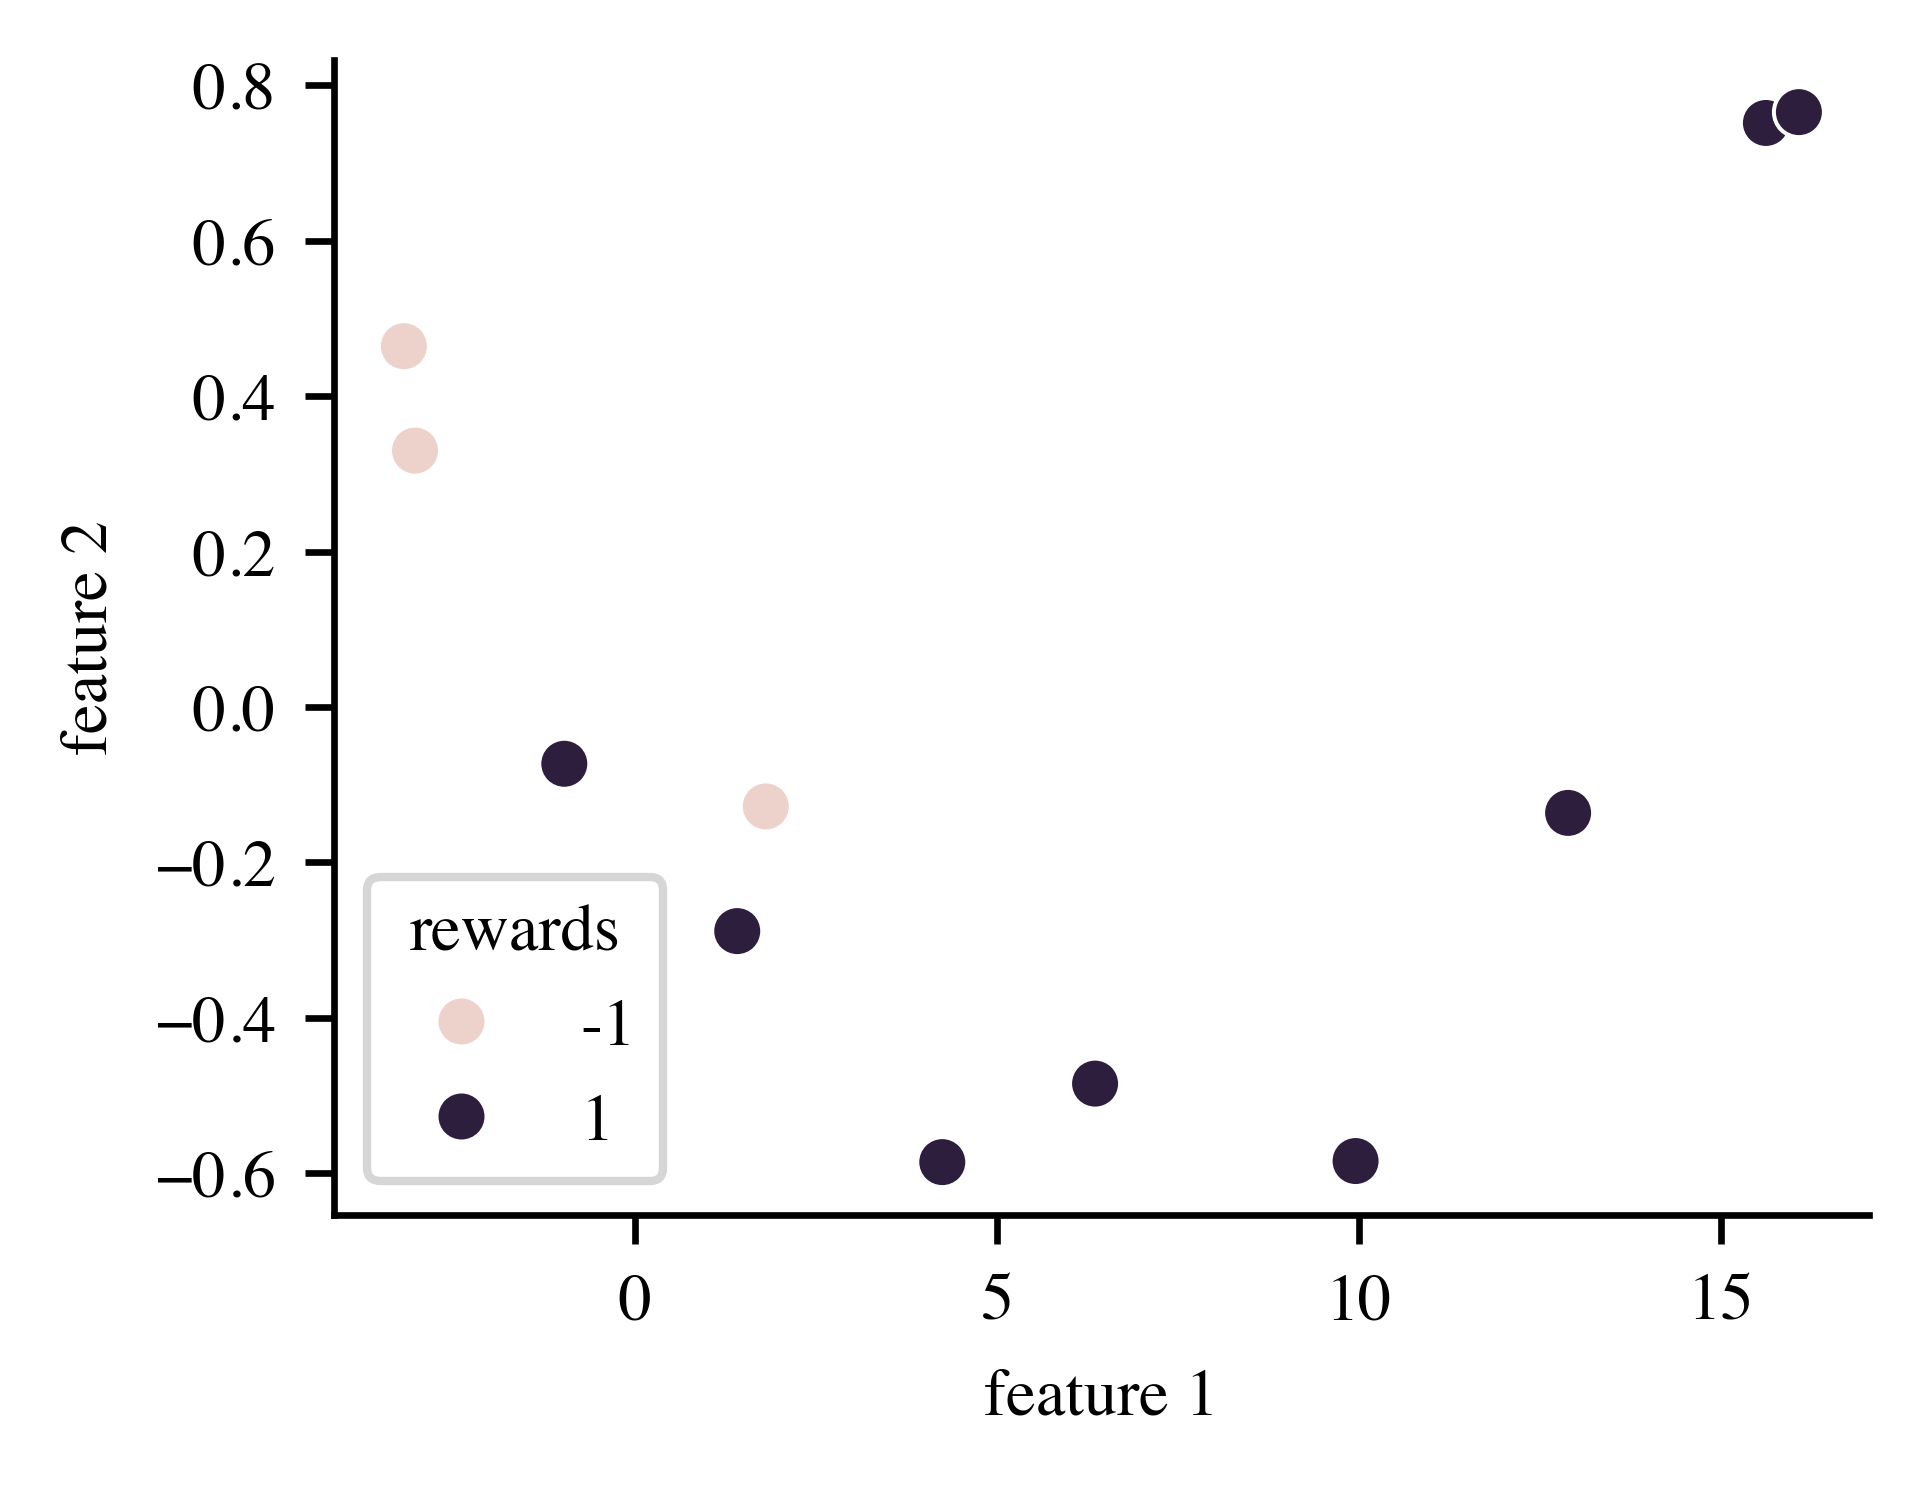

In [7]:
pca = PCA(n_components=2)
pca_traj_embeddings = pca.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeddings[:, 0], 'feature 2': pca_traj_embeddings[:, 1],
                'rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs}
df = pd.DataFrame(plotting_data)

plt.figure()
sns.scatterplot(x='feature 1', y='feature 2', hue='rewards', data=df)
# plt.title('PCA: Trajectory Embeddings')
# plt.legend()
plt.show()

In [9]:
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(traj_embeddings, amount_initial_centers, random_state = 0).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
## mre then 10 clusters is pointless because by plotting them we see visually there are no more then 9.
xmeans_instance = xmeans(traj_embeddings, initial_centers, 10, random_state=0)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())
print("Clusters:", clusters)
print('Number of clusters', len(clusters))




Total WCE: 0.1319096854685009
Clusters: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], [51, 52, 53, 54, 56, 57, 58, 59], [55], [42, 43], [50], [44], [48, 49], [47], [46], [45]]
Number of clusters 10


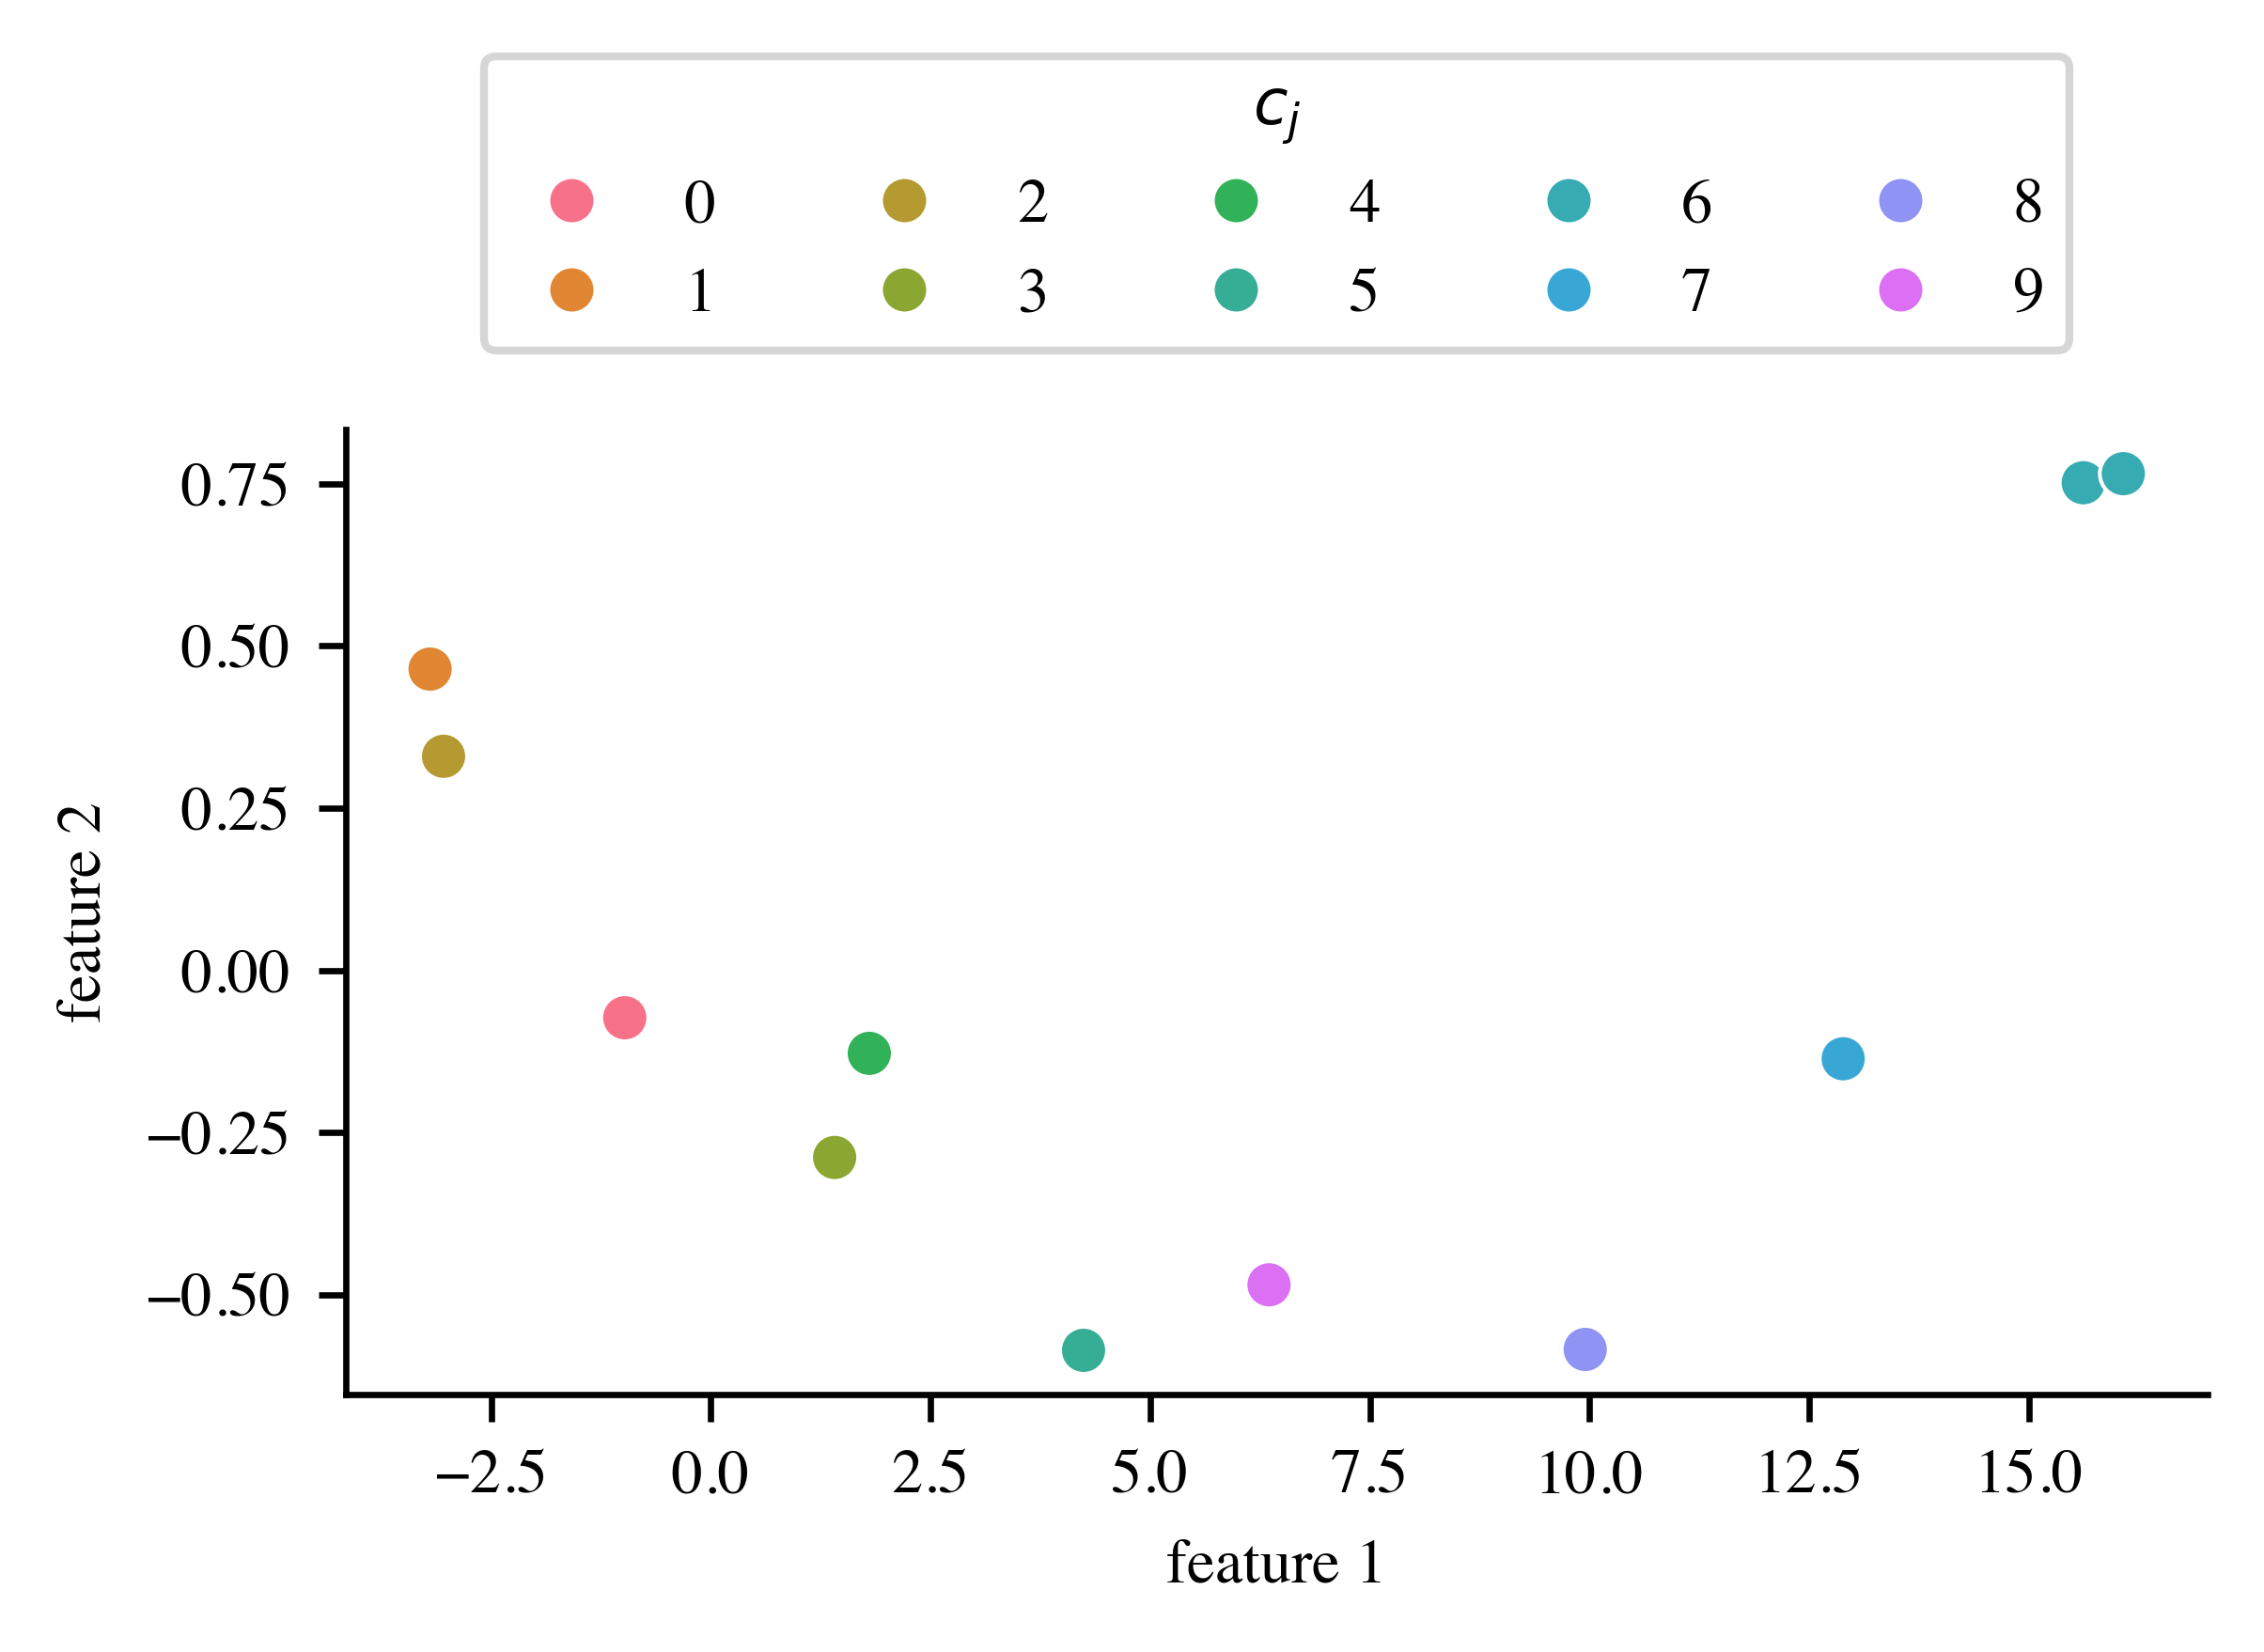

In [10]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id


palette = sns.color_palette('husl', len(clusters) + 1)

pca_traj = PCA(n_components=2)
pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeds[:, 0],
                'feature 2': pca_traj_embeds[:, 1],
                'cluster id': traj_cluster_labels}
df = pd.DataFrame(plotting_data)

plt.figure(figsize=(4,3))
data_ax = sns.scatterplot(x='feature 1',
                        y='feature 2',
                        hue='cluster id',
                        palette=palette[:len(clusters)],
                        data=df,
                        legend=True)
plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
plt.tight_layout()
plt.savefig('./traj_clustering_grid.pdf')
plt.show()
            


### Encode sets of trajectories (iii)

In [11]:
# def get_data_embedding(traj_embeddings):
# #     return np.exp(np.abs(np.array(traj_embeddings).sum(axis=0)/100.))/np.sum(np.abs(np.exp(np.array(traj_embeddings).sum(axis=0)/100.)))
#     return np.exp(np.array(traj_embeddings).sum(axis=0)/len(clusters))/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/len(clusters)))

def get_data_embedding(traj_embeddings):
    max_val = np.max(traj_embeddings)
    exp_values = np.exp(np.array(traj_embeddings) - max_val)
    return exp_values.sum(axis=0) / len(clusters) / np.sum(exp_values)


data_embedding = get_data_embedding(traj_embeddings)
data_embedding

array([3.9726888e-10, 3.2857284e-10, 4.4883516e-10, 1.6774139e-10,
       1.1914758e-10, 1.1763533e-10, 3.7734610e-10, 3.8206402e-10,
       4.7042570e-10, 1.5083738e-10, 4.8417531e-10, 1.3295755e-10,
       2.3049702e-10, 2.0578957e-10, 5.1102250e-10, 1.7522751e-10,
       3.0929184e-10, 1.5623093e-10, 3.8202377e-10, 3.7267406e-10,
       1.9810520e-10, 2.9650390e-10, 3.2904446e-10, 1.4191642e-10,
       1.5432773e-10, 5.0890209e-10, 3.0774222e-10, 1.7620508e-10,
       1.9401936e-10, 3.5244976e-10, 1.4203069e-10, 4.9078780e-10,
       8.4962148e-10, 2.4739812e-09, 1.6954557e-09, 1.2911437e-10,
       3.6721784e-12, 3.6298374e-11, 3.2741308e-08, 4.8138948e-10,
       6.4709189e-09, 4.6760922e-11, 8.3308077e-10, 8.5858308e-12,
       1.3989740e-10, 1.3169985e-10, 1.2558405e-09, 2.3090447e-12,
       5.5848193e-09, 9.4914077e-11, 5.6936633e-10, 9.9810138e-02,
       1.5857447e-10, 5.0470006e-10, 3.6377001e-10, 1.8662344e-11,
       1.9718363e-12, 1.8978975e-04, 3.5026368e-10, 1.0213243e

### Train models on different cluster combinations (iv)

In [12]:
transition_model, reward_model = generate_model(env, offline_data)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

In [13]:
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data):
        if traj_id not in cluster:
            temp_data.append(offline_data[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

### Generate attributions (v)

In [14]:
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

attributions = []

for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals:
        continue
        
    orig_state_action_values = action_values[state]
    
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        # print("data_comb_id", data_combination_id)
        # print(action_values_new[data_combination_id])
        # print("state", state)
        # print(action_values_new[state])

        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]
        # print(new_state_action_values)

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)

    ## argsorting on the distances and selecting the zero-th element. This corresponds to the smallest distance cluster for that state for every complementary data embedding set.
    responsible_data_combination = np.argsort(distances)[0]
    # print(distances)


    ## if you want print these two, so that you can see the distances and the smallest distance cluster. 
    # print(distances, distances[responsible_data_combination], responsible_data_combination)
    ## if you print this, you understand how trajectories are grouped and why `Responsible trajectory id` is showing what it is showing.
    # print(clusters)


    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)

----------
State - (7, 4)
Distance - 1.8471084401521193e-11
Original Actions -['UP']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [48, 49]
----------
----------
State - (1, 5)
Distance - 1.084189277194929e-08
Original Actions -['LEFT', 'DOWN']
New Action - ['LEFT', 'UP', 'DOWN']
Responsible data combination - data id 5
Responsible trajectory id [50]
----------
----------
State - (3, 5)
Distance - 7.70623653797734e-07
Original Actions -['UP', 'DOWN']
New Action - ['LEFT', 'UP', 'DOWN']
Responsible data combination - data id 2
Responsible trajectory id [51, 52, 53, 54, 56, 57, 58, 59]
----------
----------
State - (2, 6)
Distance - 1.8471084401521193e-11
Original Actions -['RIGHT']
New Action - ['LEFT', 'UP', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [48, 49]
----------
----------
State - (3, 6)
Distance - 1.8471084401521193e-11
Original Actions -['RIGHT']
New Action - ['DOWN']
Responsible

In [15]:
attributions

[{'state': (7, 4),
  'orig_act': ['UP'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [48, 49],
  'random_baseline_trajs': [0, 3, 59, 3, 39],
  'alternate_cluster_trajs': [50],
  'responsible_cluster': 6},
 {'state': (1, 5),
  'orig_act': ['LEFT', 'DOWN'],
  'new_act': ['LEFT', 'UP', 'DOWN'],
  'attributed_trajs': [50],
  'random_baseline_trajs': [21, 50, 36, 23, 6],
  'alternate_cluster_trajs': [55],
  'responsible_cluster': 4},
 {'state': (3, 5),
  'orig_act': ['UP', 'DOWN'],
  'new_act': ['LEFT', 'UP', 'DOWN'],
  'attributed_trajs': [51, 52, 53, 54, 56, 57, 58, 59],
  'random_baseline_trajs': [24, 12, 58, 1, 38],
  'alternate_cluster_trajs': [46],
  'responsible_cluster': 1},
 {'state': (2, 6),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'DOWN'],
  'attributed_trajs': [48, 49],
  'random_baseline_trajs': [23, 46, 24, 17, 37],
  'alternate_cluster_trajs': [47],
  'responsible_cluster': 6},
 {'state': (3, 6),
  'orig_act': ['RIGHT'],
  'new_act': ['DOWN

### Metrics Section

The following section is about metrics used to compare different policies. 
1. Initial State Value Estimate 
    - Measure of expecteed long-term returns.
2. Local Mean Absolute Action-Value difference (Average delta q)
3. Action Contrast Measure



#### Initial State Value Estimates

`result_data_combinations` is notghing but the dict comprising of all the complementary data embedding sets for each cluster and the new sets of actions from the new trained agent. 
It is a dict of key and a tuple made of (action_values_new, data_embedding_new) as value. 

In [16]:
# ivs_xmean = []
# for data_combination_id in result_data_combinations:
#     ## uncomment the following lines to get a better view if necesary
    
#     print(data_combination_id, result_data_combinations[data_combination_id][0].max(axis=1).mean())
#     ivs_xmean.append(result_data_combinations[data_combination_id][0].max(axis=1).mean())

ivs_xmean = []
for data_combination_id in result_data_combinations:
    ## uncomment the following lines to get a better view if necesary
    # print(data_combination_id)
    # print(result_data_combinations[data_combination_id][0])
    # print('max')
    # print(result_data_combinations[data_combination_id][0].max(axis=1))
    print('data_combination_id', data_combination_id)
    print(round(result_data_combinations[data_combination_id][0].max(axis=1).mean(), 4))
    
    ivs_xmean.append(result_data_combinations[data_combination_id][0].max(axis=1).mean())


sum(ivs_xmean)/len(ivs_xmean)

data_combination_id 0
0.1824
data_combination_id 1
0.1827
data_combination_id 2
0.1671
data_combination_id 3
0.1822
data_combination_id 4
0.1822
data_combination_id 5
0.1827
data_combination_id 6
0.1822
data_combination_id 7
0.0727
data_combination_id 8
0.1827
data_combination_id 9
0.1827
data_combination_id 10
0.1823


0.17108934797224762

In [17]:
results = []
for data_combination_id in result_data_combinations:
    # modify the below such that you print them in the order of value, together with a string that says which data combination it is
    temp = result_data_combinations[data_combination_id][0].max(axis=1).mean()
    results.append(temp)

#create a dictionary with the data combination id as the key and the value as the value
results_dict = {}
for i in range(len(results)):
    results_dict[i] = results[i]

#sort the dictionary by value
sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=True)

# print the results in order
for i in range(len(sorted_results)):
    print(sorted_results[i])

(1, 0.18269431665471755)
(8, 0.18269155799729808)
(9, 0.1826888925883344)
(5, 0.18268589502571114)
(0, 0.18241948673527364)
(10, 0.18227727883304476)
(6, 0.1822451565372022)
(3, 0.18222835633371076)
(4, 0.18219425335876555)
(2, 0.16714664433188753)
(7, 0.07271098929877824)


#### Average delta q

As the average delta is a technique measuring how the original policy percieves suggestions given by explanation policies you are keeping `result_data_combinations[0][0]` because corresponding to `data_combination_id` == 0 is the original dataset and thus ` result_data_combinations[0][0]` corresponds to the original set of actions. 

In [15]:
deltaq_xmean = []
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
    ## Expected value of the difference
    print(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))
    deltaq_xmean.append(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))

sum(deltaq_xmean)/len(deltaq_xmean)

0.0
0.06425148818202311
0.011095376562321678
0.03369702578352153
0.0006795824732580034
0.03496829520387197
0.007417907032265599
0.0323212631359861
0.0034141295869160367
0.04656354222464607
0.0004804173470004552


0.021353547957437324

#### Compare the actions

In [16]:
action_comparison = {}
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    action_comparison[data_combination_id] = 0
    for i in range(env_width*env_height):
            orig_actions = np.where(result_data_combinations[0][0][i] == np.max(result_data_combinations[0][0][i]))[0]
            alternate_actions = np.where(result_data_combinations[data_combination_id][0][i] == np.max(result_data_combinations[data_combination_id][0][i]))[0]
            
            if list(orig_actions) == list(alternate_actions):
                action_comparison[data_combination_id] += 1 
#             alternate_actions = 
#     print(np.sum(np.argmax(action_values_new, axis=1) != np.argmax(result_data_combinations[0][0], axis=1))/(env_width*env_height))

In [17]:
action_comparison_xmean = np.array(list(action_comparison.values()))/(env_width*env_height)
action_comparison_xmean
sum(action_comparison_xmean)/len(action_comparison_xmean)


0.922077922077922

On top of this they compare distances between embeddings of original and complementary datasets using Wasserstein metric and cluster attribution frequency

#### Data distances

In [18]:
data_distances = np.zeros(len(result_data_combinations))
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding, data_embedding_new)

In [19]:
datadistances_xmean = []
with np.printoptions(precision=5, suppress=True):
    print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))
    datadistances_xmean.append((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))
    
sum(datadistances_xmean)/len(datadistances_xmean)

[0.      0.14322 0.0064  0.01144 1.      0.06313 0.11425 0.0093  0.00153
 0.03217 0.00311]


array([0.        , 0.14321854, 0.0064012 , 0.01144267, 1.        ,
       0.0631315 , 0.1142473 , 0.00929888, 0.00152911, 0.03217471,
       0.00311034])

In [20]:
x = [0.,  0.43008, 0.29909, 0.03274, 0.02149, 1.,      0.08576 ,0.03464 ,0.01869,
 0.04466 , 0.03665]
sum(x)/len(x)

0.18216363636363636

#### Cluster Attribution Frequency

In [21]:
cluster_attr_freq = np.zeros(len(clusters))

In [22]:
for attribution in attributions:
    cluster_attr_freq[attribution['responsible_cluster']] += 1 

In [23]:
cluster_attr_freq_xmean = cluster_attr_freq/cluster_attr_freq.sum()
cluster_attr_freq_xmean

# sum(cluster_attr_freq_xmean)/len(cluster_attr_freq_xmean)

array([0.1, 0. , 0.1, 0. , 0.1, 0. , 0.3, 0.3, 0.1, 0. ])